In [1]:
# !pip install koreanize-matplotlib
# !pip install plotly
# !pip install ta==0.9.0

## lib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ta

import os
from pylab import plt, mpl
from tqdm import tqdm
from datetime import datetime, timedelta

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision

In [4]:
# import ta
# from libs.feature_importance import importance as imp
from sklearn.metrics import classification_report, precision_score, confusion_matrix
from sklearn.feature_selection import SequentialFeatureSelector, RFECV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import roc_curve, auc
import pickle
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn') # 'seaborn-v0_8' 스타일을 사용 오류
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('display.precision', 4)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

In [5]:
import koreanize_matplotlib

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

#### seaborn 한글 깨짐 현상 해결 방법

In [6]:
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline

# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False

In [7]:
# # 주가데이터
# import FinanceDataReader as fdr
# fdr.__version__

### Seed 설정

In [8]:
import random

# 시드 값 설정
seed_value = 100

# 파이썬 내장 random 모듈 시드 설정
random.seed(seed_value)

# TensorFlow 시드 설정
tf.random.set_seed(seed_value)

# Numpy 시드 설정
np.random.seed(seed_value)

### 데이터 준비

In [9]:
kospi_14_24_01_trend_label_kalman = pd.read_csv('kospi_14_24_01_trend_label_kalman.csv', index_col=0)
kospi_14_24_01_trend_label_kalman.drop(columns=['순매수_전체'], inplace=True)
kospi_14_24_01_trend_label_kalman

Open     High      Low    Close     Volume            MarCap  \
Date                                                                          
2014-01-03  1963.72  1964.63  1936.15  1946.14  188529402  1147185472603763   
2014-01-06  1947.62  1961.85  1943.74  1953.28  193630493  1151821444321770   
2014-01-07  1947.65  1965.74  1947.08  1959.44  193026899  1155148368398739   
2014-01-08  1965.50  1966.95  1950.02  1958.96  217070410  1155336478303790   
2014-01-09  1962.30  1964.59  1946.11  1946.11  276402210  1147927559250180   
...             ...      ...      ...      ...        ...               ...   
2024-04-29  2675.46  2687.44  2665.21  2687.44  470546033  2189691725743463   
2024-04-30  2693.22  2710.23  2687.29  2692.06  460083516  2193843858061216   
2024-05-02  2679.04  2692.47  2678.84  2683.65  351087270  2186876849586271   
2024-05-03  2704.31  2705.26  2676.63  2676.63  338612027  2180854242187852   
2024-05-07  2718.17  2734.36  2716.62  2734.36  532203424  2228259503005163   

             매도_금융투자   매수_금융투자  순매수_금융투자    매도_보험  ...    매수_외국인   순매수_외국인  \
Date                                               ...                       
2014-01-03   8370037   3672850  -4697187  2934571  ...  19641945  -3241963   
2014-01-06   5916693   3625874  -2290819  2149348  ...  18521901     -9687   
2014-01-07   4397282   2771893  -1625389  2631309  ...  21741808    252863   
2014-01-08   4820502   3505739  -1314763  1859109  ...  21287974   1446823   
2014-01-09  10563357   3576175  -6987182  2885453  ...  27180214   3585598   
...              ...       ...       ...      ...  ...       ...       ...   
2024-04-29   5353046  10015015   4661969  1479298  ...  86286386  17320111   
2024-04-30   6073768   9027473   2953705  1548253  ...  93844715   9691247   
2024-05-02   7429768   4868198  -2561570  1366408  ...  66236931  -2769990   
2024-05-03   3354228   5122918   1768690  1353575  ...  56074200   2695863   
2024-05-07   5670431  18935920  13265489  1712004  ...  97400321  15663274   

            매도_기타외국인  매수_기타외국인  순매수_기타외국인      매도_전체      매수_전체  kalman_ma  \
Date                                                                         
2014-01-03    287135    275966     -11169  188529402  188529402  1308.6930   
2014-01-06    309123    358130      49007  193630493  193630493  1475.0104   
2014-01-07    403188    228783    -174405  193026899  193026899  1577.4043   
2014-01-08    625622    403195    -222427  217070410  217070410  1646.5602   
2014-01-09    513344    511831      -1513  276402210  276402210  1694.6511   
...              ...       ...        ...        ...        ...        ...   
2024-04-29   1381707   1298537     -83170  470546033  470546033  2664.2192   
2024-04-30   1417945   1524896     106951  460083516  460083516  2666.8676   
2024-05-02    869053   1001788     132735  351087270  351087270  2668.4640   
2024-05-03    811193   1122332     311139  338612027  338612027  2669.2408   
2024-05-07   1432049   1387418     -44631  532203424  532203424  2675.4353   

            target       r  
Date                        
2014-01-03     1.0 -0.0108  
2014-01-06     1.0  0.0037  
2014-01-07     1.0  0.0031  
2014-01-08     1.0 -0.0002  
2014-01-09     1.0 -0.0066  
...            ...     ...  
2024-04-29     1.0  0.0116  
2024-04-30     1.0  0.0017  
2024-05-02     1.0 -0.0031  
2024-05-03     1.0 -0.0026  
2024-05-07     1.0  0.0213  

[2543 rows x 47 columns]

### 기술적 지표 추가

In [10]:
data = kospi_14_24_01_trend_label_kalman[['Open', 'High', 'Low', 'Close', 'Volume']]

In [11]:
mt = 1
fillna = False
df_ = data.copy()
open, high, low, close, volume = 'Open', 'High', 'Low', 'Close', 'Volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

### 거래량 관련 지표 추가

In [12]:
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.Volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.Close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.Close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.Volume.rolling(i).std()

In [13]:
df_.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'volume_cmf', 'volume_fi',
       'volume_mfi', 'volume_sma_em', 'volume_vpt', 'volatility_atr',
       'volatility_ui', 'trend_macd_diff', 'trend_adx', 'trend_trix',
       'trend_mass_index', 'trend_dpo', 'trend_aroon_ind', 'momentum_rsi',
       'momentum_wr', 'vol_change_5', 'ret_5', 'vol_change_10', 'ret_10',
       'vol_change_20', 'ret_20', 'std_30', 'vol_std_30'],
      dtype='object')

In [14]:
selected_TI = df_[['volume_cmf', 'volume_fi',
                   'volume_mfi', 'volume_sma_em', 'volume_vpt', 'volatility_atr',
                   'volatility_ui', 'trend_macd_diff', 'trend_adx', 'trend_trix',
                   'trend_mass_index', 'trend_dpo', 'trend_aroon_ind', 'momentum_rsi',
                   'momentum_wr', 'vol_change_5', 'ret_5', 'vol_change_10', 'ret_10',
                   'vol_change_20', 'ret_20', 'std_30', 'vol_std_30']]

In [15]:
kospi_14_24_01_trend_label_kalman_ta = pd.concat([kospi_14_24_01_trend_label_kalman, selected_TI], axis=1)
kospi_14_24_01_trend_label_kalman_ta.dropna(inplace=True)
kospi_14_24_01_trend_label_kalman_ta

Open     High      Low    Close     Volume            MarCap  \
Date                                                                          
2014-03-07  1979.70  1983.53  1968.66  1974.68  231557237  1171060533144157   
2014-03-10  1967.63  1967.66  1951.96  1954.42  214944284  1159472445620989   
2014-03-11  1957.22  1963.87  1951.20  1963.87  247468004  1164815467875309   
2014-03-12  1957.67  1958.09  1930.48  1932.54  329923547  1146460580210853   
2014-03-13  1940.35  1946.28  1931.75  1934.38  259619849  1147366863530616   
...             ...      ...      ...      ...        ...               ...   
2024-04-29  2675.46  2687.44  2665.21  2687.44  470546033  2189691725743463   
2024-04-30  2693.22  2710.23  2687.29  2692.06  460083516  2193843858061216   
2024-05-02  2679.04  2692.47  2678.84  2683.65  351087270  2186876849586271   
2024-05-03  2704.31  2705.26  2676.63  2676.63  338612027  2180854242187852   
2024-05-07  2718.17  2734.36  2716.62  2734.36  532203424  2228259503005163   

            매도_금융투자   매수_금융투자  순매수_금융투자    매도_보험  ...  momentum_rsi  \
Date                                              ...                 
2014-03-07  3586232   4040200    453968  2641596  ...       58.2840   
2014-03-10  4957687   3914211  -1043476  3045944  ...       50.5248   
2014-03-11  3837210   4029193    191983  3804816  ...       53.6111   
2014-03-12  6588397   7599838   1011441  3966236  ...       43.8865   
2014-03-13  5901313   6934734   1033421  2884637  ...       44.5197   
...             ...       ...       ...      ...  ...           ...   
2024-04-29  5353046  10015015   4661969  1479298  ...       52.5648   
2024-04-30  6073768   9027473   2953705  1548253  ...       53.1227   
2024-05-02  7429768   4868198  -2561570  1366408  ...       51.9315   
2024-05-03  3354228   5122918   1768690  1353575  ...       50.9105   
2024-05-07  5670431  18935920  13265489  1712004  ...       58.1587   

            momentum_wr  vol_change_5   ret_5  vol_change_10  ret_10  \
Date                                                                   
2014-03-07     -15.8036       -0.0841 -0.0027         0.0705  0.0086   
2014-03-10     -51.9821       -0.0345 -0.0052         0.1090  0.0028   
2014-03-11     -35.1071        0.2351  0.0050         0.0948 -0.0005   
2014-03-12     -91.0536        0.6688 -0.0196         0.5775 -0.0194   
2014-03-13     -92.6484        0.3400 -0.0209         0.2913 -0.0223   
...                 ...           ...     ...            ...     ...   
2024-04-29     -28.6605        0.1708  0.0221        -0.1627  0.0064   
2024-04-30     -26.1988        0.0693  0.0263        -0.1931  0.0316   
2024-05-02     -20.9215        0.0778  0.0030        -0.1527  0.0385   
2024-05-03     -22.5425        0.0136  0.0183        -0.2928  0.0159   
2024-05-07      -0.0000        0.1813  0.0294        -0.3425  0.0550   

            vol_change_20  ret_20   std_30  vol_std_30  
Date                                                    
2014-03-07        -0.1517  0.0271  25.1396  3.2223e+07  
2014-03-10         0.0336  0.0162  25.2254  3.2323e+07  
2014-03-11         0.0931  0.0165  25.5382  3.1099e+07  
2014-03-12         0.4639 -0.0017  24.8807  2.9814e+07  
2014-03-13         0.3820  0.0039  24.4391  2.9330e+07  
...                   ...     ...      ...         ...  
2024-04-29        -0.0504 -0.0215  53.2771  1.2649e+08  
2024-04-30         0.1572 -0.0203  53.2664  1.2521e+08  
2024-05-02        -0.4431 -0.0252  52.8690  1.2483e+08  
2024-05-03        -0.4716 -0.0112  52.9483  1.2247e+08  
2024-05-07         0.1135 -0.0028  52.2390  1.0635e+08  

[2500 rows x 70 columns]

### 주식 시장 지표 (Market Indices) 추가

In [16]:
# Load the uploaded data
market_indices = pd.read_csv('MarketIndices.csv')

# Convert the 'Date' column to datetime
market_indices['Date'] = pd.to_datetime(market_indices['Date'])
kospi_14_24_01_trend_label_kalman_ta.index = pd.to_datetime(kospi_14_24_01_trend_label_kalman_ta.index)

# Extract 'Adj Close' values and 'Index' for the first dataset
adj_close_indices = market_indices.pivot(index='Date', columns='Index', values='Adj Close')

# Shift the 'Adj Close' values by one day
adj_close_indices_shifted = adj_close_indices.shift(1)

# Merge the shifted 'Adj Close' values with the second dataset
merged_df = kospi_14_24_01_trend_label_kalman_ta.join(adj_close_indices_shifted, how='left') # 컬럼을 명시하지 않으면 인덱스를 기준으로 조인

# Fill NaN values in the new features with the previous day's values
merged_df = merged_df.fillna(method='ffill') # forward fill

# Drop the 'kosdaq', 'kospi', 'kospi200' columns from the merged dataframe
kospi_14_24_01_trend_label_kalman_ta_MI = merged_df.drop(columns=['kosdaq', 'kospi', 'kospi200'])
kospi_14_24_01_trend_label_kalman_ta_MI

Open     High      Low    Close     Volume            MarCap  \
Date                                                                          
2014-03-07  1979.70  1983.53  1968.66  1974.68  231557237  1171060533144157   
2014-03-10  1967.63  1967.66  1951.96  1954.42  214944284  1159472445620989   
2014-03-11  1957.22  1963.87  1951.20  1963.87  247468004  1164815467875309   
2014-03-12  1957.67  1958.09  1930.48  1932.54  329923547  1146460580210853   
2014-03-13  1940.35  1946.28  1931.75  1934.38  259619849  1147366863530616   
...             ...      ...      ...      ...        ...               ...   
2024-04-29  2675.46  2687.44  2665.21  2687.44  470546033  2189691725743463   
2024-04-30  2693.22  2710.23  2687.29  2692.06  460083516  2193843858061216   
2024-05-02  2679.04  2692.47  2678.84  2683.65  351087270  2186876849586271   
2024-05-03  2704.31  2705.26  2676.63  2676.63  338612027  2180854242187852   
2024-05-07  2718.17  2734.36  2716.62  2734.36  532203424  2228259503005163   

            매도_금융투자   매수_금융투자  순매수_금융투자    매도_보험  ...   ret_5  vol_change_10  \
Date                                              ...                          
2014-03-07  3586232   4040200    453968  2641596  ... -0.0027         0.0705   
2014-03-10  4957687   3914211  -1043476  3045944  ... -0.0052         0.1090   
2014-03-11  3837210   4029193    191983  3804816  ...  0.0050         0.0948   
2014-03-12  6588397   7599838   1011441  3966236  ... -0.0196         0.5775   
2014-03-13  5901313   6934734   1033421  2884637  ... -0.0209         0.2913   
...             ...       ...       ...      ...  ...     ...            ...   
2024-04-29  5353046  10015015   4661969  1479298  ...  0.0221        -0.1627   
2024-04-30  6073768   9027473   2953705  1548253  ...  0.0263        -0.1931   
2024-05-02  7429768   4868198  -2561570  1366408  ...  0.0030        -0.1527   
2024-05-03  3354228   5122918   1768690  1353575  ...  0.0183        -0.2928   
2024-05-07  5670431  18935920  13265489  1712004  ...  0.0294        -0.3425   

            ret_10  vol_change_20  ret_20   std_30  vol_std_30    dowjones  \
Date                                                                         
2014-03-07  0.0086        -0.1517  0.0271  25.1396  3.2223e+07  16421.8906   
2014-03-10  0.0028         0.0336  0.0162  25.2254  3.2323e+07  16452.7207   
2014-03-11 -0.0005         0.0931  0.0165  25.5382  3.1099e+07  16418.6797   
2014-03-12 -0.0194         0.4639 -0.0017  24.8807  2.9814e+07  16351.2500   
2014-03-13 -0.0223         0.3820  0.0039  24.4391  2.9330e+07  16340.0801   
...            ...            ...     ...      ...         ...         ...   
2024-04-29  0.0064        -0.0504 -0.0215  53.2771  1.2649e+08  38239.6602   
2024-04-30  0.0316         0.1572 -0.0203  53.2664  1.2521e+08  38386.0898   
2024-05-02  0.0385        -0.4431 -0.0252  52.8690  1.2483e+08  37903.2891   
2024-05-03  0.0159        -0.4716 -0.0112  52.9483  1.2247e+08  38225.6602   
2024-05-07  0.0550         0.1135 -0.0028  52.2390  1.0635e+08  38852.2695   

                nasdaq     s&p500  
Date                               
2014-03-07   4352.1299  1877.0300  
2014-03-10   4336.2202  1878.0400  
2014-03-11   4334.4502  1877.1700  
2014-03-12   4307.1899  1867.6300  
2014-03-13   4323.3301  1868.2000  
...                ...        ...  
2024-04-29  15927.9004  5099.9600  
2024-04-30  15983.0801  5116.1699  
2024-05-02  15605.4805  5018.3901  
2024-05-03  15840.9600  5064.2002  
2024-05-07  16349.2500  5180.7402  

[2500 rows x 73 columns]

In [17]:
kospi_14_24_01_trend_label_kalman_ta_MI.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'MarCap', '매도_금융투자',
       '매수_금융투자', '순매수_금융투자', '매도_보험', '매수_보험', '순매수_보험', '매도_투신', '매수_투신',
       '순매수_투신', '매도_사모', '매수_사모', '순매수_사모', '매도_은행', '매수_은행', '순매수_은행',
       '매도_기타금융', '매수_기타금융', '순매수_기타금융', '매도_연기금 등', '매수_연기금 등', '순매수_연기금 등',
       '매도_기관합계', '매수_기관합계', '순매수_기관합계', '매도_기타법인', '매수_기타법인', '순매수_기타법인',
       '매도_개인', '매수_개인', '순매수_개인', '매도_외국인', '매수_외국인', '순매수_외국인', '매도_기타외국인',
       '매수_기타외국인', '순매수_기타외국인', '매도_전체', '매수_전체', 'kalman_ma', 'target', 'r',
       'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_sma_em', 'volume_vpt',
       'volatility_atr', 'volatility_ui', 'trend_macd_diff', 'trend_adx',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_aroon_ind',
       'momentum_rsi', 'momentum_wr', 'vol_change_5', 'ret_5', 'vol_change_10',
       'ret_10', 'vol_change_20', 'ret_20', 'std_30', 'vol_std_30', 'dowjones',
       'nasdaq', 's&p500'],
      dtype='object')

### Scaling 전 데이터 split

In [18]:
# 학습 및 검증 데이터와 테스트 데이터로 분할
df_train = kospi_14_24_01_trend_label_kalman_ta_MI[kospi_14_24_01_trend_label_kalman_ta_MI.index < '2023-05-01']
df_test = kospi_14_24_01_trend_label_kalman_ta_MI[kospi_14_24_01_trend_label_kalman_ta_MI.index >= '2023-05-01']

In [19]:
df_train

Open     High      Low    Close      Volume            MarCap  \
Date                                                                           
2014-03-07  1979.70  1983.53  1968.66  1974.68   231557237  1171060533144157   
2014-03-10  1967.63  1967.66  1951.96  1954.42   214944284  1159472445620989   
2014-03-11  1957.22  1963.87  1951.20  1963.87   247468004  1164815467875309   
2014-03-12  1957.67  1958.09  1930.48  1932.54   329923547  1146460580210853   
2014-03-13  1940.35  1946.28  1931.75  1934.38   259619849  1147366863530616   
...             ...      ...      ...      ...         ...               ...   
2023-04-24  2538.36  2541.89  2518.73  2523.50   927191299  1996621732458125   
2023-04-25  2531.35  2531.35  2472.33  2489.02   886421798  1967147727128900   
2023-04-26  2489.49  2498.56  2481.38  2484.83  1089215527  1964553908314712   
2023-04-27  2484.31  2499.01  2465.83  2495.81   733499935  1974101089770741   
2023-04-28  2511.79  2517.13  2489.58  2501.53   777535095  1979839469128982   

             매도_금융투자   매수_금융투자  순매수_금융투자    매도_보험  ...   ret_5  vol_change_10  \
Date                                               ...                          
2014-03-07   3586232   4040200    453968  2641596  ... -0.0027         0.0705   
2014-03-10   4957687   3914211  -1043476  3045944  ... -0.0052         0.1090   
2014-03-11   3837210   4029193    191983  3804816  ...  0.0050         0.0948   
2014-03-12   6588397   7599838   1011441  3966236  ... -0.0196         0.5775   
2014-03-13   5901313   6934734   1033421  2884637  ... -0.0209         0.2913   
...              ...       ...       ...      ...  ...     ...            ...   
2023-04-24  10338951  13755734   3416783   774621  ... -0.0203         0.2920   
2023-04-25  14057882  13270372   -787510  1056405  ... -0.0319         0.1539   
2023-04-26  11861945  10170758  -1691187  1109120  ... -0.0350         0.2092   
2023-04-27  21719472  10988771 -10730701  1295001  ... -0.0263        -0.1286   
2023-04-28  16456960  11246981  -5209979   936750  ... -0.0168        -0.1288   

            ret_10  vol_change_20  ret_20   std_30  vol_std_30    dowjones  \
Date                                                                         
2014-03-07  0.0086        -0.1517  0.0271  25.1396  3.2223e+07  16421.8906   
2014-03-10  0.0028         0.0336  0.0162  25.2254  3.2323e+07  16452.7207   
2014-03-11 -0.0005         0.0931  0.0165  25.5382  3.1099e+07  16418.6797   
2014-03-12 -0.0194         0.4639 -0.0017  24.8807  2.9814e+07  16351.2500   
2014-03-13 -0.0223         0.3820  0.0039  24.4391  2.9330e+07  16340.0801   
...            ...            ...     ...      ...         ...         ...   
2023-04-24  0.0045         0.9609  0.0474  71.6277  2.0873e+08  33808.9609   
2023-04-25 -0.0231         0.6916  0.0222  67.6065  2.0974e+08  33875.3984   
2023-04-26 -0.0258         1.1906  0.0167  64.9391  2.1791e+08  33530.8281   
2023-04-27 -0.0257         0.1660  0.0174  61.8673  2.0589e+08  33301.8711   
2023-04-28 -0.0272         0.0760  0.0100  59.4679  1.9533e+08  33826.1602   

                nasdaq     s&p500  
Date                               
2014-03-07   4352.1299  1877.0300  
2014-03-10   4336.2202  1878.0400  
2014-03-11   4334.4502  1877.1700  
2014-03-12   4307.1899  1867.6300  
2014-03-13   4323.3301  1868.2000  
...                ...        ...  
2023-04-24  12072.4600  4133.5200  
2023-04-25  12037.2002  4137.0400  
2023-04-26  11799.1602  4071.6299  
2023-04-27  11854.3496  4055.9900  
2023-04-28  12142.2402  4135.3501  

[2252 rows x 73 columns]

In [20]:
df_test

Open     High      Low    Close     Volume            MarCap  \
Date                                                                          
2023-05-02  2504.01  2524.42  2503.21  2524.39  701398536  1997496492608915   
2023-05-03  2510.19  2514.37  2497.83  2501.40  889609358  1979410344840207   
2023-05-04  2494.82  2502.14  2486.09  2500.94  810178245  1978572080421787   
2023-05-08  2518.53  2525.84  2511.13  2513.21  655536077  1989045053273087   
2023-05-09  2512.34  2514.81  2495.63  2510.06  751646926  1986578323550486   
...             ...      ...      ...      ...        ...               ...   
2024-04-29  2675.46  2687.44  2665.21  2687.44  470546033  2189691725743463   
2024-04-30  2693.22  2710.23  2687.29  2692.06  460083516  2193843858061216   
2024-05-02  2679.04  2692.47  2678.84  2683.65  351087270  2186876849586271   
2024-05-03  2704.31  2705.26  2676.63  2676.63  338612027  2180854242187852   
2024-05-07  2718.17  2734.36  2716.62  2734.36  532203424  2228259503005163   

             매도_금융투자   매수_금융투자  순매수_금융투자    매도_보험  ...   ret_5  vol_change_10  \
Date                                               ...                          
2023-05-02   9416649  13971329   4554680   918678  ...  0.0004        -0.0958   
2023-05-03  11407984   8023058  -3384926  1014087  ...  0.0050        -0.0082   
2023-05-04  16577707  10779894  -5797813  2842450  ...  0.0065        -0.1534   
2023-05-08   6595212  14395063   7799851  1254688  ...  0.0070        -0.3110   
2023-05-09   7504268   8686771   1182503  1073048  ...  0.0034        -0.2254   
...              ...       ...       ...      ...  ...     ...            ...   
2024-04-29   5353046  10015015   4661969  1479298  ...  0.0221        -0.1627   
2024-04-30   6073768   9027473   2953705  1548253  ...  0.0263        -0.1931   
2024-05-02   7429768   4868198  -2561570  1366408  ...  0.0030        -0.1527   
2024-05-03   3354228   5122918   1768690  1353575  ...  0.0183        -0.2928   
2024-05-07   5670431  18935920  13265489  1712004  ...  0.0294        -0.3425   

            ret_10  vol_change_20  ret_20   std_30  vol_std_30    dowjones  \
Date                                                                         
2023-05-02 -0.0200        -0.1359  0.0211  55.9201  1.8178e+08  34051.6992   
2023-05-03 -0.0271         0.0685  0.0084  52.1613  1.6868e+08  33684.5312   
2023-05-04 -0.0288         0.2805  0.0023  49.8147  1.6190e+08  33414.2383   
2023-05-08 -0.0195        -0.1276  0.0220  47.6615  1.5895e+08  33674.3789   
2023-05-09 -0.0135         0.2805  0.0079  44.5535  1.4870e+08  33618.6914   
...            ...            ...     ...      ...         ...         ...   
2024-04-29  0.0064        -0.0504 -0.0215  53.2771  1.2649e+08  38239.6602   
2024-04-30  0.0316         0.1572 -0.0203  53.2664  1.2521e+08  38386.0898   
2024-05-02  0.0385        -0.4431 -0.0252  52.8690  1.2483e+08  37903.2891   
2024-05-03  0.0159        -0.4716 -0.0112  52.9483  1.2247e+08  38225.6602   
2024-05-07  0.0550         0.1135 -0.0028  52.2390  1.0635e+08  38852.2695   

                nasdaq     s&p500  
Date                               
2023-05-02  12212.5996  4167.8701  
2023-05-03  12080.5098  4119.5801  
2023-05-04  12025.3301  4090.7500  
2023-05-08  12235.4102  4136.2500  
2023-05-09  12256.9199  4138.1201  
...                ...        ...  
2024-04-29  15927.9004  5099.9600  
2024-04-30  15983.0801  5116.1699  
2024-05-02  15605.4805  5018.3901  
2024-05-03  15840.9600  5064.2002  
2024-05-07  16349.2500  5180.7402  

[248 rows x 73 columns]

### Train Data Scaling

In [21]:
scaler = RobustScaler() # StandardScaler  RobustScaler
X_features = df_train.columns.values[~(df_train.columns.values == 'target')]
scaled_features = scaler.fit_transform(df_train.loc[:, X_features])
df_train_scaled = pd.DataFrame(scaled_features, index=df_train.index, columns=df_train.loc[:, X_features].columns)
df_train_scaled['target'] = df_train['target']
df_train_scaled

Open    High     Low   Close  Volume  MarCap  매도_금융투자  매수_금융투자  \
Date                                                                           
2014-03-07 -0.4666 -0.4730 -0.4641 -0.4725 -0.6616 -0.5339  -0.6351  -0.5345   
2014-03-10 -0.4945 -0.5093 -0.5030 -0.5196 -0.7152 -0.5558  -0.4186  -0.5536   
2014-03-11 -0.5186 -0.5180 -0.5048 -0.4976 -0.6103 -0.5457  -0.5954  -0.5361   
2014-03-12 -0.5175 -0.5312 -0.5531 -0.5704 -0.3443 -0.5804  -0.1611   0.0072   
2014-03-13 -0.5575 -0.5582 -0.5501 -0.5661 -0.5711 -0.5786  -0.2696  -0.0940   
...            ...     ...     ...     ...     ...     ...      ...      ...   
2023-04-24  0.8245  0.8045  0.8181  0.8026  1.5824  1.0235   0.4310   0.9440   
2023-04-25  0.8083  0.7803  0.7100  0.7225  1.4509  0.9679   1.0180   0.8701   
2023-04-26  0.7116  0.7053  0.7310  0.7127  2.1051  0.9630   0.6714   0.3984   
2023-04-27  0.6996  0.7064  0.6948  0.7383  0.9576  0.9810   2.2275   0.5229   
2023-04-28  0.7631  0.7478  0.7502  0.7515  1.0996  0.9918   1.3968   0.5622   

            순매수_금융투자   매도_보험  ...  vol_change_10  ret_10  vol_change_20  \
Date                          ...                                         
2014-03-07    0.1504  0.6048  ...         0.1630  0.1854        -0.3675   
2014-03-10   -0.2199  0.9693  ...         0.2574  0.0250         0.0553   
2014-03-11    0.0856  1.6533  ...         0.2226 -0.0644         0.1912   
2014-03-12    0.2882  1.7988  ...         1.4044 -0.5825         1.0374   
2014-03-13    0.2936  0.8239  ...         0.7037 -0.6611         0.8505   
...              ...     ...  ...            ...     ...            ...   
2023-04-24    0.8830 -1.0779  ...         0.7054  0.0741         2.1716   
2023-04-25   -0.1566 -0.8240  ...         0.3674 -0.6838         1.5570   
2023-04-26   -0.3801 -0.7764  ...         0.5028 -0.7580         2.6959   
2023-04-27   -2.6153 -0.6089  ...        -0.3243 -0.7554         0.3576   
2023-04-28   -1.2502 -0.9318  ...        -0.3248 -0.7965         0.1521   

            ret_20  std_30  vol_std_30  dowjones  nasdaq  s&p500  target  
Date                                                                      
2014-03-07  0.4594 -0.3537     -0.8335   -0.7048 -0.5115 -0.5504    -1.0  
2014-03-10  0.2382 -0.3507     -0.8323   -0.7023 -0.5141 -0.5497    -1.0  
2014-03-11  0.2439 -0.3400     -0.8469   -0.7051 -0.5144 -0.5503    -1.0  
2014-03-12 -0.1230 -0.3625     -0.8623   -0.7107 -0.5189 -0.5563    -1.0  
2014-03-13 -0.0108 -0.3777     -0.8682   -0.7116 -0.5162 -0.5559    -1.0  
...            ...     ...         ...       ...     ...     ...     ...  
2023-04-24  0.8691  1.2420      1.2822    0.7346  0.7606  0.8725    -1.0  
2023-04-25  0.3599  1.1040      1.2943    0.7401  0.7548  0.8747    -1.0  
2023-04-26  0.2494  1.0124      1.3923    0.7116  0.7155  0.8335    -1.0  
2023-04-27  0.2625  0.9070      1.2481    0.6926  0.7246  0.8236    -1.0  
2023-04-28  0.1126  0.8247      1.1216    0.7360  0.7721  0.8736    -1.0  

[2252 rows x 73 columns]

### Test Data Scaling

In [22]:
scaled_features = scaler.transform(df_test.loc[:, X_features])
df_test_scaled = pd.DataFrame(scaled_features, index=df_test.index, columns=df_test.loc[:, X_features].columns)
df_test_scaled['target'] = df_test['target']
df_test_scaled

Open    High     Low   Close  Volume  MarCap  매도_금융투자  매수_금융투자  \
Date                                                                           
2023-05-02  0.7452  0.7645  0.7819  0.8047  0.8540  1.0251   0.2854   0.9768   
2023-05-03  0.7594  0.7415  0.7694  0.7512  1.4612  0.9910   0.5997   0.0716   
2023-05-04  0.7239  0.7135  0.7420  0.7502  1.2050  0.9894   1.4158   0.4911   
2023-05-08  0.7787  0.7677  0.8004  0.7787  0.7061  1.0092  -0.1601   1.0412   
2023-05-09  0.7644  0.7425  0.7643  0.7714  1.0161  1.0045  -0.0165   0.1726   
...            ...     ...     ...     ...     ...     ...      ...      ...   
2024-04-29  1.1414  1.1375  1.1595  1.1835  0.1093  1.3877  -0.3561   0.3747   
2024-04-30  1.1825  1.1896  1.2110  1.1942  0.0756  1.3955  -0.2424   0.2245   
2024-05-02  1.1497  1.1490  1.1913  1.1747 -0.2760  1.3824  -0.0283  -0.4085   
2024-05-03  1.2081  1.1782  1.1862  1.1584 -0.3163  1.3710  -0.6717  -0.3697   
2024-05-07  1.2401  1.2448  1.2794  1.2925  0.3082  1.4605  -0.3060   1.7322   

            순매수_금융투자   매도_보험  ...  vol_change_10  ret_10  vol_change_20  \
Date                          ...                                         
2023-05-02    1.1644 -0.9481  ...        -0.2442 -0.5990        -0.3315   
2023-05-03   -0.7989 -0.8621  ...        -0.0295 -0.7938         0.1351   
2023-05-04   -1.3955  0.7859  ...        -0.3852 -0.8400         0.6188   
2023-05-08    1.9668 -0.6452  ...        -0.7710 -0.5844        -0.3124   
2023-05-09    0.3305 -0.8090  ...        -0.5615 -0.4206         0.6188   
...              ...     ...  ...            ...     ...            ...   
2024-04-29    1.1909 -0.4428  ...        -0.4078  0.1241        -0.1363   
2024-04-30    0.7685 -0.3806  ...        -0.4824  0.8155         0.3373   
2024-05-02   -0.5953 -0.5445  ...        -0.3834  1.0048        -1.0325   
2024-05-03    0.4755 -0.5561  ...        -0.7264  0.3858        -1.0976   
2024-05-07    3.3183 -0.2330  ...        -0.8482  1.4569         0.2377   

            ret_20  std_30  vol_std_30  dowjones  nasdaq  s&p500  target  
Date                                                                      
2023-05-02  0.3365  0.7029      0.9592    0.7547  0.7837  0.8941    -1.0  
2023-05-03  0.0815  0.5739      0.8022    0.7243  0.7619  0.8637    -1.0  
2023-05-04 -0.0422  0.4933      0.7209    0.7019  0.7528  0.8455    -1.0  
2023-05-08  0.3546  0.4194      0.6855    0.7234  0.7874  0.8742    -1.0  
2023-05-09  0.0708  0.3127      0.5627    0.7188  0.7910  0.8754    -1.0  
...            ...     ...         ...       ...     ...     ...     ...  
2024-04-29 -0.5236  0.6122      0.2965    1.1014  1.3958  1.4819     1.0  
2024-04-30 -0.4985  0.6118      0.2811    1.1135  1.4049  1.4921     1.0  
2024-05-02 -0.5982  0.5981      0.2766    1.0735  1.3427  1.4304     1.0  
2024-05-03 -0.3148  0.6009      0.2483    1.1002  1.3815  1.4593     1.0  
2024-05-07 -0.1448  0.5765      0.0550    1.1521  1.4653  1.5328     1.0  

[248 rows x 73 columns]

### Data Analysis

In [23]:
# 전체 컬럼
df_train_scaled.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'MarCap', '매도_금융투자',
       '매수_금융투자', '순매수_금융투자', '매도_보험', '매수_보험', '순매수_보험', '매도_투신', '매수_투신',
       '순매수_투신', '매도_사모', '매수_사모', '순매수_사모', '매도_은행', '매수_은행', '순매수_은행',
       '매도_기타금융', '매수_기타금융', '순매수_기타금융', '매도_연기금 등', '매수_연기금 등', '순매수_연기금 등',
       '매도_기관합계', '매수_기관합계', '순매수_기관합계', '매도_기타법인', '매수_기타법인', '순매수_기타법인',
       '매도_개인', '매수_개인', '순매수_개인', '매도_외국인', '매수_외국인', '순매수_외국인', '매도_기타외국인',
       '매수_기타외국인', '순매수_기타외국인', '매도_전체', '매수_전체', 'kalman_ma', 'r',
       'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_sma_em', 'volume_vpt',
       'volatility_atr', 'volatility_ui', 'trend_macd_diff', 'trend_adx',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_aroon_ind',
       'momentum_rsi', 'momentum_wr', 'vol_change_5', 'ret_5', 'vol_change_10',
       'ret_10', 'vol_change_20', 'ret_20', 'std_30', 'vol_std_30', 'dowjones',
       'nasdaq', 's&p500', 'target'],
      dtype='object')

- 생성한 피쳐
['kalman_ma', 'r']

- 순매수 합계 제거된 피쳐

['매도_금융투자', '매수_금융투자', '매도_보험', '매수_보험', '매도_투신', '매수_투신', 
                  '매도_사모', '매수_사모', '매도_은행', '매수_은행', '매도_기타금융', '매수_기타금융', 
                  '매도_연기금 등', '매수_연기금 등', '매도_기타법인', '매수_기타법인', '매도_개인', '매수_개인', 
                  '매도_외국인', '매수_외국인', '매도_기타외국인', '매수_기타외국인', 
                  'Date', 'Open', 'High', 'Low', 'Close']

- 기술적 지표 피쳐

['volume_cmf', 'volume_fi', 'volume_mfi', 'volume_sma_em', 'volume_vpt',
 'volatility_atr', 'volatility_ui', 'trend_macd_diff', 'trend_adx',
 'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_aroon_ind',
 'momentum_rsi', 'momentum_wr', 'vol_change_5', 'ret_5', 'vol_change_10',
 'ret_10', 'vol_change_20', 'ret_20', 'std_30', 'vol_std_30']

- 시장 지표

['dowjones', 'nasdaq', 's&p500']

In [24]:
# 타겟값의 비율
df_train_scaled['target'].value_counts(1)

 1.0    0.5511
-1.0    0.4489
Name: target, dtype: float64

In [25]:
# 타겟값의 비율
df_test_scaled['target'].value_counts(1)

 1.0    0.5726
-1.0    0.4274
Name: target, dtype: float64

### Test Set을 제외한 상관관계 분석

In [26]:
df_corr = df_train_scaled.copy()

# target 값을 다음날 값으로 가져온다.
# df_corr['target'] = df_corr['target'].shift(-1)

df_corr.dropna(inplace=True)

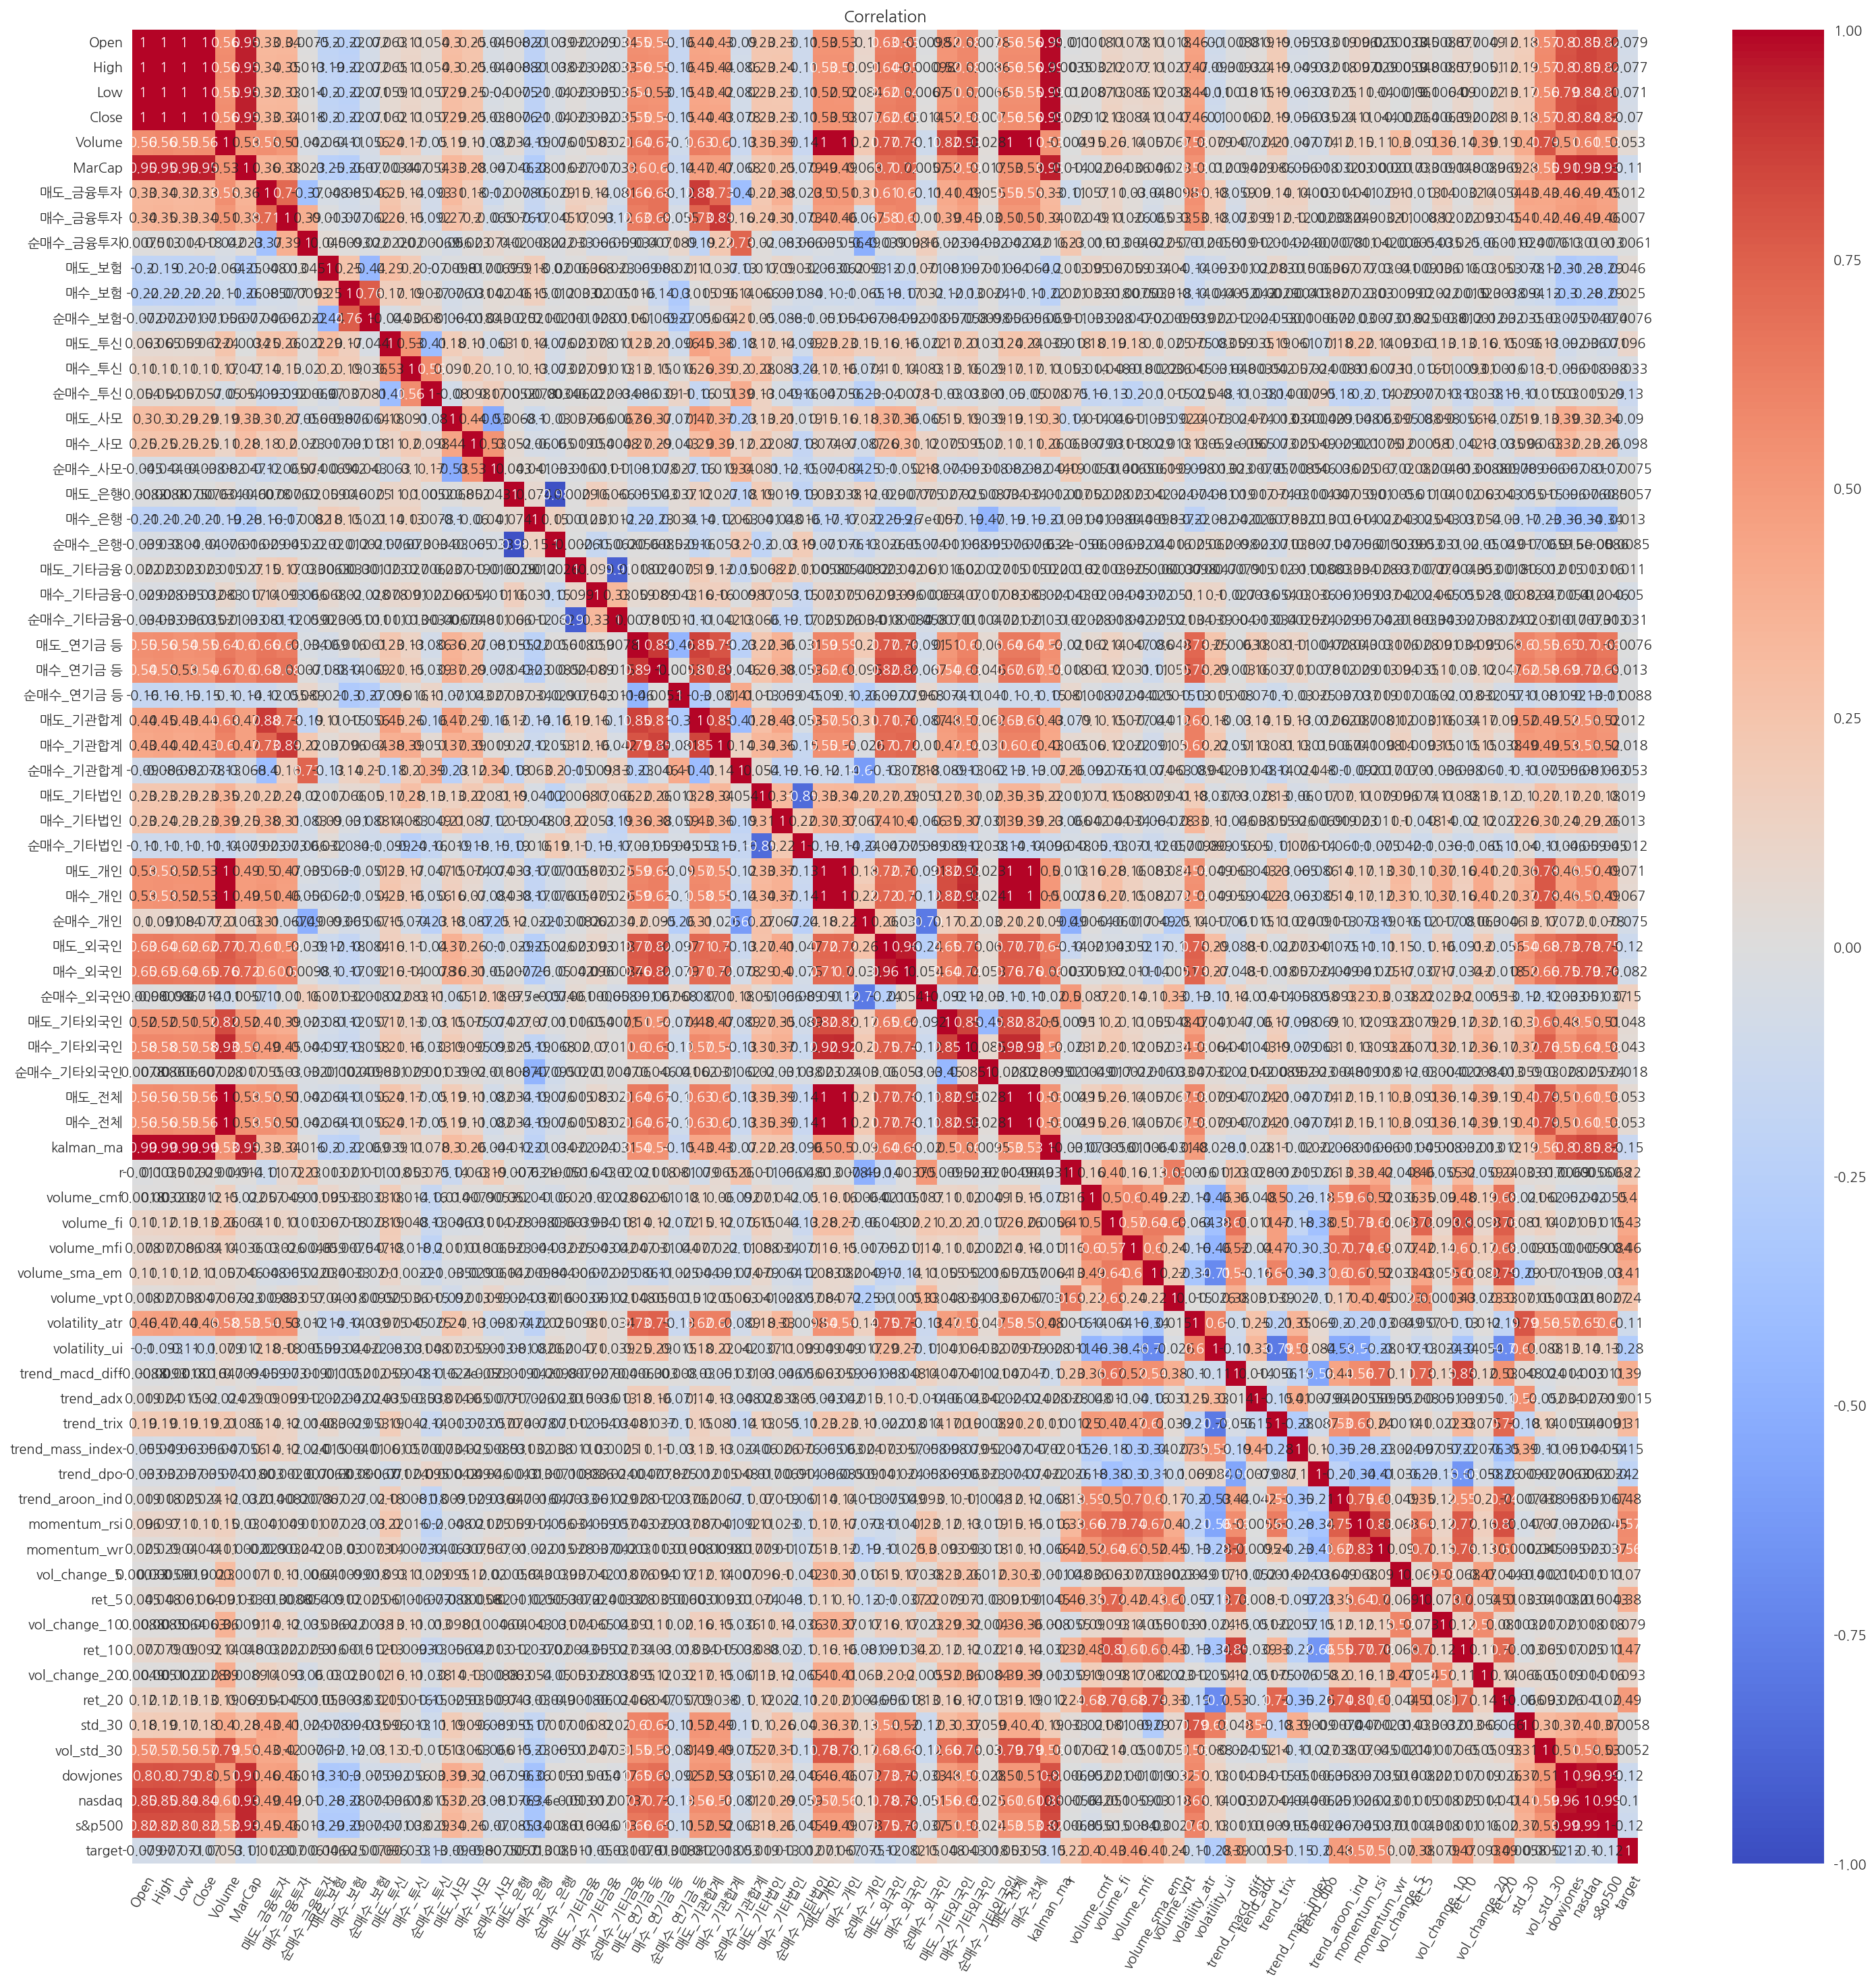

In [27]:
# # 피쳐 선택
# variables = ['transaction_real_price', 'exclusive_use_area', 'floor', 'adjusted_year_of_completion', 'lat', 'long', 'park_min', 'kind_min',
#              'subway_min', 'elem_min']

# 상관관계 행렬 계산
corr = df_corr.corr()

# Heatmap으로 시각화
plt.figure(figsize=(25, 25))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation')
plt.xticks(rotation=60)  # x 축 눈금값을 45도 기울임

plt.show()

In [28]:
corr['target'].sort_values(ascending = False)[1:].head(20)

momentum_rsi       0.5702
momentum_wr        0.5600
ret_20             0.4931
trend_aroon_ind    0.4821
ret_10             0.4680
volume_mfi         0.4629
volume_fi          0.4254
volume_sma_em      0.4115
volume_cmf         0.4017
trend_macd_diff    0.3856
ret_5              0.3779
trend_trix         0.3068
volume_vpt         0.2388
r                  0.2246
순매수_외국인            0.1515
매도_투신              0.0964
vol_change_20      0.0935
vol_change_10      0.0794
매도_개인              0.0712
vol_change_5       0.0702
Name: target, dtype: float64

In [29]:
corr['target'].sort_values(ascending = False)[1:].tail(20)

순매수_기관합계           -0.0525
Close              -0.0698
Low                -0.0714
순매수_개인             -0.0754
High               -0.0767
Open               -0.0787
매수_외국인             -0.0823
매도_사모              -0.0903
매수_사모              -0.0979
nasdaq             -0.1036
volatility_atr     -0.1079
MarCap             -0.1089
dowjones           -0.1222
s&p500             -0.1231
매도_외국인             -0.1246
순매수_투신             -0.1297
kalman_ma          -0.1451
trend_mass_index   -0.1543
trend_dpo          -0.2004
volatility_ui      -0.2759
Name: target, dtype: float64

### Test Set을 제외한 정규화 상호 정보 (Normalized Mutual Information, NMI)

In [30]:
# from sklearn.metrics import normalized_mutual_info_score

# # 정규화 상호 정보 계산
# nmi_matrix = pd.DataFrame(index=df_corr.columns, columns=df_corr.columns)

# for col1 in tqdm(df_corr.columns):
#     for col2 in df_corr.columns:
#         nmi = normalized_mutual_info_score(df_corr[col1], df_corr[col2])
#         nmi_matrix.loc[col1, col2] = nmi

# nmi_matrix = nmi_matrix.astype(float)

# # 시각화
# plt.figure(figsize=(25, 25))
# sns.heatmap(nmi_matrix, annot=True, cmap='viridis', fmt=".2f")
# plt.title('Normalized Mutual Information Matrix')
# plt.show()

In [31]:
# # 'target' 컬럼과 나머지 변수 간의 정규화 상호 정보 계산
# nmi_values = {}

# target_col = 'target'
# for col in tqdm(df_corr.columns):
#     if col != target_col:
#         nmi = normalized_mutual_info_score(df_corr[target_col], df_corr[col])
#         nmi_values[col] = nmi

# # 데이터프레임으로 변환
# nmi_df = pd.DataFrame.from_dict(nmi_values, orient='index', columns=['NMI'])
# nmi_df.sort_values(by='NMI', ascending=False, inplace=True)

# # 시각화
# plt.figure(figsize=(10, 6))
# sns.barplot(x=nmi_df.index, y='NMI', data=nmi_df, palette='viridis')
# plt.title('Normalized Mutual Information with Target')
# plt.xlabel('Features')
# plt.ylabel('NMI')
# plt.xticks(rotation=90)
# plt.show()

## 변수 선택

In [32]:
df_train_scaled.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'MarCap', '매도_금융투자',
       '매수_금융투자', '순매수_금융투자', '매도_보험', '매수_보험', '순매수_보험', '매도_투신', '매수_투신',
       '순매수_투신', '매도_사모', '매수_사모', '순매수_사모', '매도_은행', '매수_은행', '순매수_은행',
       '매도_기타금융', '매수_기타금융', '순매수_기타금융', '매도_연기금 등', '매수_연기금 등', '순매수_연기금 등',
       '매도_기관합계', '매수_기관합계', '순매수_기관합계', '매도_기타법인', '매수_기타법인', '순매수_기타법인',
       '매도_개인', '매수_개인', '순매수_개인', '매도_외국인', '매수_외국인', '순매수_외국인', '매도_기타외국인',
       '매수_기타외국인', '순매수_기타외국인', '매도_전체', '매수_전체', 'kalman_ma', 'r',
       'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_sma_em', 'volume_vpt',
       'volatility_atr', 'volatility_ui', 'trend_macd_diff', 'trend_adx',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_aroon_ind',
       'momentum_rsi', 'momentum_wr', 'vol_change_5', 'ret_5', 'vol_change_10',
       'ret_10', 'vol_change_20', 'ret_20', 'std_30', 'vol_std_30', 'dowjones',
       'nasdaq', 's&p500', 'target'],
      dtype='object')

In [33]:
# 제거하고 싶은 피쳐
removed_features = []
# ['Open', 'High', 'Low', 'Close', 'Volume', 'MarCap', '매도_금융투자',
#        '매수_금융투자', '순매수_금융투자', '매도_보험', '매수_보험', '순매수_보험', '매도_투신', '매수_투신',
#        '순매수_투신', '매도_사모', '매수_사모', '순매수_사모', '매도_은행', '매수_은행', '순매수_은행',
#        '매도_기타금융', '매수_기타금융', '순매수_기타금융', '매도_연기금 등', '매수_연기금 등', '순매수_연기금 등',
#        '매도_기관합계', '매수_기관합계', '순매수_기관합계', '매도_기타법인', '매수_기타법인', '순매수_기타법인',
#        '매도_개인', '매수_개인', '순매수_개인', '순매수_외국인', '매도_기타외국인',
#        '매수_기타외국인', '순매수_기타외국인', '매도_전체', '매수_전체'] 

In [34]:
train_data_ = df_train_scaled.copy()
train_data_ = train_data_.drop(columns=removed_features)
train_data_['target'] = train_data_['target'].apply(lambda x: 1 if x > 0 else 0)
train_data_

Open    High     Low   Close  Volume  MarCap  매도_금융투자  매수_금융투자  \
Date                                                                           
2014-03-07 -0.4666 -0.4730 -0.4641 -0.4725 -0.6616 -0.5339  -0.6351  -0.5345   
2014-03-10 -0.4945 -0.5093 -0.5030 -0.5196 -0.7152 -0.5558  -0.4186  -0.5536   
2014-03-11 -0.5186 -0.5180 -0.5048 -0.4976 -0.6103 -0.5457  -0.5954  -0.5361   
2014-03-12 -0.5175 -0.5312 -0.5531 -0.5704 -0.3443 -0.5804  -0.1611   0.0072   
2014-03-13 -0.5575 -0.5582 -0.5501 -0.5661 -0.5711 -0.5786  -0.2696  -0.0940   
...            ...     ...     ...     ...     ...     ...      ...      ...   
2023-04-24  0.8245  0.8045  0.8181  0.8026  1.5824  1.0235   0.4310   0.9440   
2023-04-25  0.8083  0.7803  0.7100  0.7225  1.4509  0.9679   1.0180   0.8701   
2023-04-26  0.7116  0.7053  0.7310  0.7127  2.1051  0.9630   0.6714   0.3984   
2023-04-27  0.6996  0.7064  0.6948  0.7383  0.9576  0.9810   2.2275   0.5229   
2023-04-28  0.7631  0.7478  0.7502  0.7515  1.0996  0.9918   1.3968   0.5622   

            순매수_금융투자   매도_보험  ...  vol_change_10  ret_10  vol_change_20  \
Date                          ...                                         
2014-03-07    0.1504  0.6048  ...         0.1630  0.1854        -0.3675   
2014-03-10   -0.2199  0.9693  ...         0.2574  0.0250         0.0553   
2014-03-11    0.0856  1.6533  ...         0.2226 -0.0644         0.1912   
2014-03-12    0.2882  1.7988  ...         1.4044 -0.5825         1.0374   
2014-03-13    0.2936  0.8239  ...         0.7037 -0.6611         0.8505   
...              ...     ...  ...            ...     ...            ...   
2023-04-24    0.8830 -1.0779  ...         0.7054  0.0741         2.1716   
2023-04-25   -0.1566 -0.8240  ...         0.3674 -0.6838         1.5570   
2023-04-26   -0.3801 -0.7764  ...         0.5028 -0.7580         2.6959   
2023-04-27   -2.6153 -0.6089  ...        -0.3243 -0.7554         0.3576   
2023-04-28   -1.2502 -0.9318  ...        -0.3248 -0.7965         0.1521   

            ret_20  std_30  vol_std_30  dowjones  nasdaq  s&p500  target  
Date                                                                      
2014-03-07  0.4594 -0.3537     -0.8335   -0.7048 -0.5115 -0.5504       0  
2014-03-10  0.2382 -0.3507     -0.8323   -0.7023 -0.5141 -0.5497       0  
2014-03-11  0.2439 -0.3400     -0.8469   -0.7051 -0.5144 -0.5503       0  
2014-03-12 -0.1230 -0.3625     -0.8623   -0.7107 -0.5189 -0.5563       0  
2014-03-13 -0.0108 -0.3777     -0.8682   -0.7116 -0.5162 -0.5559       0  
...            ...     ...         ...       ...     ...     ...     ...  
2023-04-24  0.8691  1.2420      1.2822    0.7346  0.7606  0.8725       0  
2023-04-25  0.3599  1.1040      1.2943    0.7401  0.7548  0.8747       0  
2023-04-26  0.2494  1.0124      1.3923    0.7116  0.7155  0.8335       0  
2023-04-27  0.2625  0.9070      1.2481    0.6926  0.7246  0.8236       0  
2023-04-28  0.1126  0.8247      1.1216    0.7360  0.7721  0.8736       0  

[2252 rows x 73 columns]

In [35]:
test_data_ = df_test_scaled.copy()
test_data_ = test_data_.drop(columns=removed_features)
test_data_['target'] = test_data_['target'].apply(lambda x: 1 if x > 0 else 0)
test_data_

Open    High     Low   Close  Volume  MarCap  매도_금융투자  매수_금융투자  \
Date                                                                           
2023-05-02  0.7452  0.7645  0.7819  0.8047  0.8540  1.0251   0.2854   0.9768   
2023-05-03  0.7594  0.7415  0.7694  0.7512  1.4612  0.9910   0.5997   0.0716   
2023-05-04  0.7239  0.7135  0.7420  0.7502  1.2050  0.9894   1.4158   0.4911   
2023-05-08  0.7787  0.7677  0.8004  0.7787  0.7061  1.0092  -0.1601   1.0412   
2023-05-09  0.7644  0.7425  0.7643  0.7714  1.0161  1.0045  -0.0165   0.1726   
...            ...     ...     ...     ...     ...     ...      ...      ...   
2024-04-29  1.1414  1.1375  1.1595  1.1835  0.1093  1.3877  -0.3561   0.3747   
2024-04-30  1.1825  1.1896  1.2110  1.1942  0.0756  1.3955  -0.2424   0.2245   
2024-05-02  1.1497  1.1490  1.1913  1.1747 -0.2760  1.3824  -0.0283  -0.4085   
2024-05-03  1.2081  1.1782  1.1862  1.1584 -0.3163  1.3710  -0.6717  -0.3697   
2024-05-07  1.2401  1.2448  1.2794  1.2925  0.3082  1.4605  -0.3060   1.7322   

            순매수_금융투자   매도_보험  ...  vol_change_10  ret_10  vol_change_20  \
Date                          ...                                         
2023-05-02    1.1644 -0.9481  ...        -0.2442 -0.5990        -0.3315   
2023-05-03   -0.7989 -0.8621  ...        -0.0295 -0.7938         0.1351   
2023-05-04   -1.3955  0.7859  ...        -0.3852 -0.8400         0.6188   
2023-05-08    1.9668 -0.6452  ...        -0.7710 -0.5844        -0.3124   
2023-05-09    0.3305 -0.8090  ...        -0.5615 -0.4206         0.6188   
...              ...     ...  ...            ...     ...            ...   
2024-04-29    1.1909 -0.4428  ...        -0.4078  0.1241        -0.1363   
2024-04-30    0.7685 -0.3806  ...        -0.4824  0.8155         0.3373   
2024-05-02   -0.5953 -0.5445  ...        -0.3834  1.0048        -1.0325   
2024-05-03    0.4755 -0.5561  ...        -0.7264  0.3858        -1.0976   
2024-05-07    3.3183 -0.2330  ...        -0.8482  1.4569         0.2377   

            ret_20  std_30  vol_std_30  dowjones  nasdaq  s&p500  target  
Date                                                                      
2023-05-02  0.3365  0.7029      0.9592    0.7547  0.7837  0.8941       0  
2023-05-03  0.0815  0.5739      0.8022    0.7243  0.7619  0.8637       0  
2023-05-04 -0.0422  0.4933      0.7209    0.7019  0.7528  0.8455       0  
2023-05-08  0.3546  0.4194      0.6855    0.7234  0.7874  0.8742       0  
2023-05-09  0.0708  0.3127      0.5627    0.7188  0.7910  0.8754       0  
...            ...     ...         ...       ...     ...     ...     ...  
2024-04-29 -0.5236  0.6122      0.2965    1.1014  1.3958  1.4819       1  
2024-04-30 -0.4985  0.6118      0.2811    1.1135  1.4049  1.4921       1  
2024-05-02 -0.5982  0.5981      0.2766    1.0735  1.3427  1.4304       1  
2024-05-03 -0.3148  0.6009      0.2483    1.1002  1.3815  1.4593       1  
2024-05-07 -0.1448  0.5765      0.0550    1.1521  1.4653  1.5328       1  

[248 rows x 73 columns]

## 2. 시퀀스 데이터 생성

### 학습 및 검증 데이터와 테스트 데이터로 분할

In [36]:
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequence = data.iloc[i:i + sequence_length].drop(columns=['target']).values
        
        # 다음날 추세 label 예측
        #label = data.iloc[i + sequence_length]['target']
        
        # 현재 시점 추세 label 예측
        label = data.iloc[i + sequence_length - 1]['target']
        
        sequences.append(sequence)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)

In [37]:
sequence_length = 20  # 시퀀스 길이

# 학습 및 검증 데이터 시퀀스 생성
train_val_sequences = []
train_val_labels = []

X_train_val, y_train_val = create_sequences(train_data_, sequence_length)

In [38]:
X_train_val.shape, y_train_val.shape

((2232, 20, 72), (2232,))

In [39]:
X_test, y_test = create_sequences(test_data_, sequence_length)
X_test.shape, y_test.shape

((228, 20, 72), (228,))

In [40]:
train_val_split = int(len(X_train_val)*0.8)
train_val_split

1785

In [41]:
y_train_val_int = y_train_val[:train_val_split].astype(int)
y_test_int = y_test.astype(int)

In [42]:
# 학습 데이터 0 / 1 비율
np.bincount(y_train_val_int)

array([ 709, 1076])

In [43]:
# 테스트 데이터 0 / 1 비율
np.bincount(y_test_int)

array([ 99, 129])

## 3. LSTM 모델 구성 및 학습

In [44]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.ensemble import BaggingClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1, l2
from tensorflow.keras import callbacks
import random
#from scikeras.wrappers import KerasClassifier 오류 발생 (optree)

## 실험

In [45]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'

In [46]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [47]:
def cw(df):
    c0, c1 = np.bincount(df.astype(int))
    w0 = (1 / c0) * (len(df)) / 2
    w1 = (1 / c1) * (len(df)) / 2
    return {0: w0, 1: w1}

In [48]:
optimizer = Adam(learning_rate=0.001)

In [49]:
from tensorflow.keras.layers import Layer, BatchNormalization
from tensorflow.keras.initializers import GlorotUniform, HeNormal, Orthogonal, HeUniform
from tensorflow.keras import backend as K

In [50]:
class InstanceNormalization(Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma',
                                     shape=(input_shape[-1],),
                                     initializer='ones',
                                     trainable=True)
        self.beta = self.add_weight(name='beta',
                                    shape=(input_shape[-1],),
                                    initializer='zeros',
                                    trainable=True)
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1], keepdims=True)
        normalized = (inputs - mean) / (K.sqrt(variance + self.epsilon))
        return self.gamma * normalized + self.beta

    def compute_output_shape(self, input_shape):
        return input_shape

In [51]:
def create_deep_rnn_model(layer='SimpleRNN', optimizer='adam', features=1):
    
    if layer == 'SimpleRNN':
        layer = SimpleRNN
    else:
        layer = LSTM
        
    model = Sequential()
    model.add(Input(shape=(sequence_length, features)))
    model.add(InstanceNormalization())
    model.add(layer(units=64, return_sequences=True, kernel_initializer=Orthogonal(gain=1.0)))
    model.add(InstanceNormalization())
    model.add(Dropout(0.5))
#     model.add(layer(units=64, return_sequences=True, kernel_initializer=Orthogonal(gain=1.0)))
#     model.add(InstanceNormalization())
#     model.add(Dropout(0.5))
    model.add(layer(units=32, return_sequences=False, kernel_initializer=Orthogonal(gain=1.0)))
    model.add(InstanceNormalization())
    model.add(Dropout(0.2))
#     model.add(Dense(units=32, activation='relu', kernel_initializer=HeUniform()))
#     model.add(BatchNormalization())
    model.add(Dense(units=16, activation='relu', kernel_initializer=HeUniform()))
    model.add(BatchNormalization())
    model.add(Dense(units=8, activation='relu', kernel_initializer=HeUniform()))
    model.add(BatchNormalization())
    model.add(Dense(units=4, activation='relu', kernel_initializer=HeUniform()))
    model.add(BatchNormalization())
    model.add(Dense(units=1, activation='sigmoid', kernel_initializer=GlorotUniform()))
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', 
                  metrics=['binary_accuracy', AUC()])
    return model

In [52]:
# TimeSeriesSplit 설정
tscv = TimeSeriesSplit(n_splits=9)

# 교차 검증 결과를 저장할 리스트
results = []

# 교차 검증
for i, (train_index, test_index) in enumerate(tscv.split(X_train_val)):
    X_train_cv, X_test_cv = X_train_val[train_index], X_train_val[test_index]
    y_train_cv, y_test_cv = y_train_val[train_index], y_train_val[test_index]
    
    set_seeds()
    #early_stopping_cb = callbacks.EarlyStopping(patience=10, monitor='binary_accuracy', restore_best_weights=True)
    
    model = create_deep_rnn_model(layer='LSTM', optimizer='adam', features=X_train_val.shape[2])
    model.fit(X_train_cv, y_train_cv, epochs=10, batch_size=16, verbose=1)#, class_weight=cw(y_train_cv)) #, callbacks=[early_stopping_cb])
    
    # 모델 평가
    loss = model.evaluate(X_test_cv, y_test_cv, verbose=1)
    results.append(loss[-2:])
    print(f'{i+1}-fold Test Accuracy | AUC: {loss[-2:]}')

Epoch 1/10
15/15 [==============================] - 31s 19ms/step - loss: 0.7267 - binary_accuracy: 0.5689 - auc: 0.6098
Epoch 2/10
15/15 [==============================] - 0s 9ms/step - loss: 0.5771 - binary_accuracy: 0.6889 - auc: 0.7545
Epoch 3/10
15/15 [==============================] - 0s 10ms/step - loss: 0.5226 - binary_accuracy: 0.7644 - auc: 0.8281
Epoch 4/10
15/15 [==============================] - 0s 9ms/step - loss: 0.5131 - binary_accuracy: 0.7511 - auc: 0.8541
Epoch 5/10
15/15 [==============================] - 0s 9ms/step - loss: 0.4936 - binary_accuracy: 0.7689 - auc: 0.8562
Epoch 6/10
15/15 [==============================] - 0s 9ms/step - loss: 0.4490 - binary_accuracy: 0.8089 - auc: 0.9101
Epoch 7/10
15/15 [==============================] - 0s 9ms/step - loss: 0.4383 - binary_accuracy: 0.8267 - auc: 0.9155
Epoch 8/10
15/15 [==============================] - 0s 9ms/step - loss: 0.4048 - binary_accuracy: 0.8489 - auc: 0.9417
Epoch 9/10
15/15 [===========================

In [53]:
results

[[0.713004469871521, 0.7239382266998291],
 [0.6143497824668884, 0.6532174348831177],
 [0.7309417128562927, 0.7177658677101135],
 [0.5022421479225159, 0.5949771404266357],
 [0.6681614518165588, 0.7813481092453003],
 [0.7578475475311279, 0.6794803142547607],
 [0.7219731211662292, 0.7859045267105103],
 [0.6188340783119202, 0.6026217937469482],
 [0.6502242088317871, 0.6913849115371704]]

In [54]:
val_mu = np.mean(results, axis=0)[0]
val_mu

0.6641753911972046

In [55]:
val_std = np.std(results, axis=0, ddof=1)[0]
val_std

0.07900031366987437

### 홀드아웃 샘플(Test Set)에 대한 예측 성능 평가 방식은 질문으로

In [56]:
set_seeds()
model = create_deep_rnn_model(layer='LSTM', optimizer='adam', features=X_train_val.shape[2])

model.fit(X_train_val, y_train_val, epochs=10, batch_size=16, verbose=1)#, class_weight=cw(y_train_val))

Epoch 1/10
140/140 [==============================] - 5s 10ms/step - loss: 0.6511 - binary_accuracy: 0.6344 - auc_9: 0.6831
Epoch 2/10
140/140 [==============================] - 1s 10ms/step - loss: 0.5564 - binary_accuracy: 0.7240 - auc_9: 0.7924
Epoch 3/10
140/140 [==============================] - 1s 10ms/step - loss: 0.5223 - binary_accuracy: 0.7419 - auc_9: 0.8193
Epoch 4/10
140/140 [==============================] - 1s 10ms/step - loss: 0.4739 - binary_accuracy: 0.7769 - auc_9: 0.8578
Epoch 5/10
140/140 [==============================] - 1s 9ms/step - loss: 0.4671 - binary_accuracy: 0.7845 - auc_9: 0.8588
Epoch 6/10
140/140 [==============================] - 1s 10ms/step - loss: 0.4107 - binary_accuracy: 0.8118 - auc_9: 0.8961
Epoch 7/10
140/140 [==============================] - 1s 10ms/step - loss: 0.3756 - binary_accuracy: 0.8365 - auc_9: 0.9145
Epoch 8/10
140/140 [==============================] - 1s 10ms/step - loss: 0.3389 - binary_accuracy: 0.8571 - auc_9: 0.9302
Epoch 9/1

In [57]:
evl = model.evaluate(X_test, y_test, verbose=1)
evl

8/8 [==============================] - 1s 5ms/step - loss: 1.1993 - binary_accuracy: 0.5658 - auc_9: 0.6326


[1.1993266344070435, 0.5657894611358643, 0.6326441764831543]

In [58]:
(evl[1] - val_mu) / val_std

-1.2453865749505042

In [59]:
len(y_test)

228

In [60]:
test = df_test.iloc[-len(y_test):]
test['target'] = test['target'].apply(lambda x: 1 if x > 0 else 0)
backtest_df = pd.DataFrame(index=test.index)
backtest_df['p'] = model.predict(X_test)
backtest_df['p'] = (backtest_df['p'] > 0.5).astype(int)

In [61]:
# 예측값 비율
backtest_df['p'].value_counts()

1    124
0    104
Name: p, dtype: int64

In [62]:
# 실제 타겟값의 비율
test['target'].value_counts()

1    129
0     99
Name: target, dtype: int64

              precision    recall  f1-score   support

           0       0.48      0.51      0.49        99
           1       0.60      0.58      0.59       129

    accuracy                           0.55       228
   macro avg       0.54      0.54      0.54       228
weighted avg       0.55      0.55      0.55       228



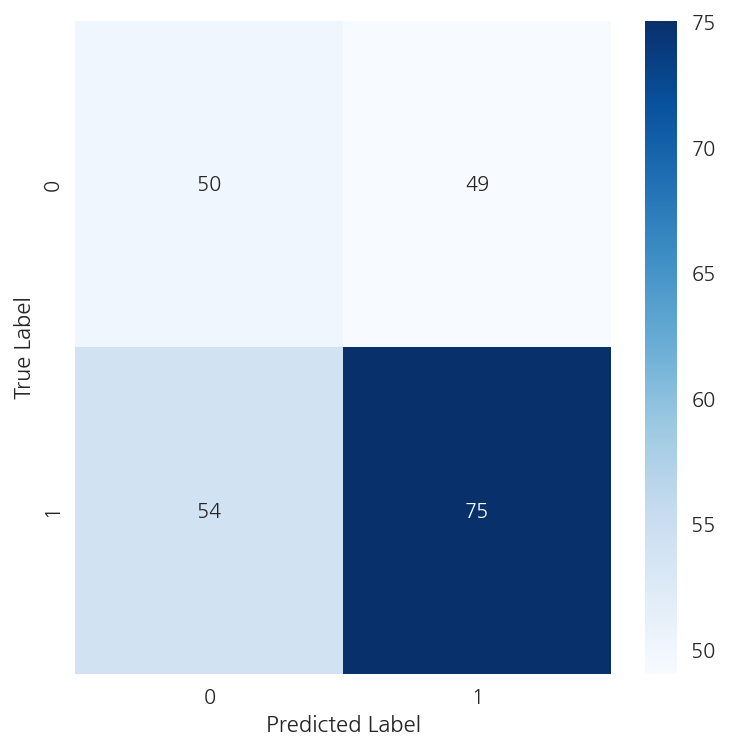

In [63]:
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. 분류 보고서 확인
print(classification_report(test['target'], backtest_df['p']))

# 2. 히트맵 시각화
plt.figure(figsize=(6, 6))
cm2 = confusion_matrix(test['target'], backtest_df['p'])
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 표본 외 경제적 성능 평가

In [64]:
# 매매 포지션 진입, 변경, 청산이 발생한 시점 횟수
sum(backtest_df['p'].diff() != 0) + 1

19

In [65]:
# 포지션 변경에 따른 증권사 수수료 / 거래세
pc = (0.00015 * 2  + 0.0018)

# 슬리피지 적용
sp = 0.001

In [66]:
backtest_df['p'] = np.where(backtest_df['p'] == 0, -1, 1)
backtest_df['r'] = df_test.loc[test.index]['r']
backtest_df['s'] = backtest_df['p'] * backtest_df['r']
backtest_df['s_'] = np.where(backtest_df['p'].diff() != 0,
                      backtest_df['s'] - pc - sp, backtest_df['s'])
backtest_df['s_'].iloc[0] -= pc
backtest_df['s_'].iloc[-1] -= pc
backtest_df

p           r           s          s_
Date                                             
2023-06-01  1 -3.0896e-03 -3.0896e-03 -8.2896e-03
2023-06-02  1  1.2451e-02  1.2451e-02  1.2451e-02
2023-06-05  1  5.3865e-03  5.3865e-03  5.3865e-03
2023-06-07  1  7.2644e-05  7.2644e-05  7.2644e-05
2023-06-08  1 -1.8177e-03 -1.8177e-03 -1.8177e-03
...        ..         ...         ...         ...
2024-04-29 -1  1.1644e-02 -1.1644e-02 -1.1644e-02
2024-04-30 -1  1.7176e-03 -1.7176e-03 -1.7176e-03
2024-05-02 -1 -3.1289e-03  3.1289e-03  3.1289e-03
2024-05-03 -1 -2.6193e-03  2.6193e-03  2.6193e-03
2024-05-07 -1  2.1339e-02 -2.1339e-02 -2.3439e-02

[228 rows x 4 columns]

In [67]:
backtest_df[['r', 's', 's_']].sum().apply(np.exp)

r     1.0610
s     0.8222
s_    0.7743
dtype: float64

In [68]:
backtest_df[['r', 's', 's_']].sum().apply(np.exp) - 1

r     0.0610
s    -0.1778
s_   -0.2257
dtype: float64

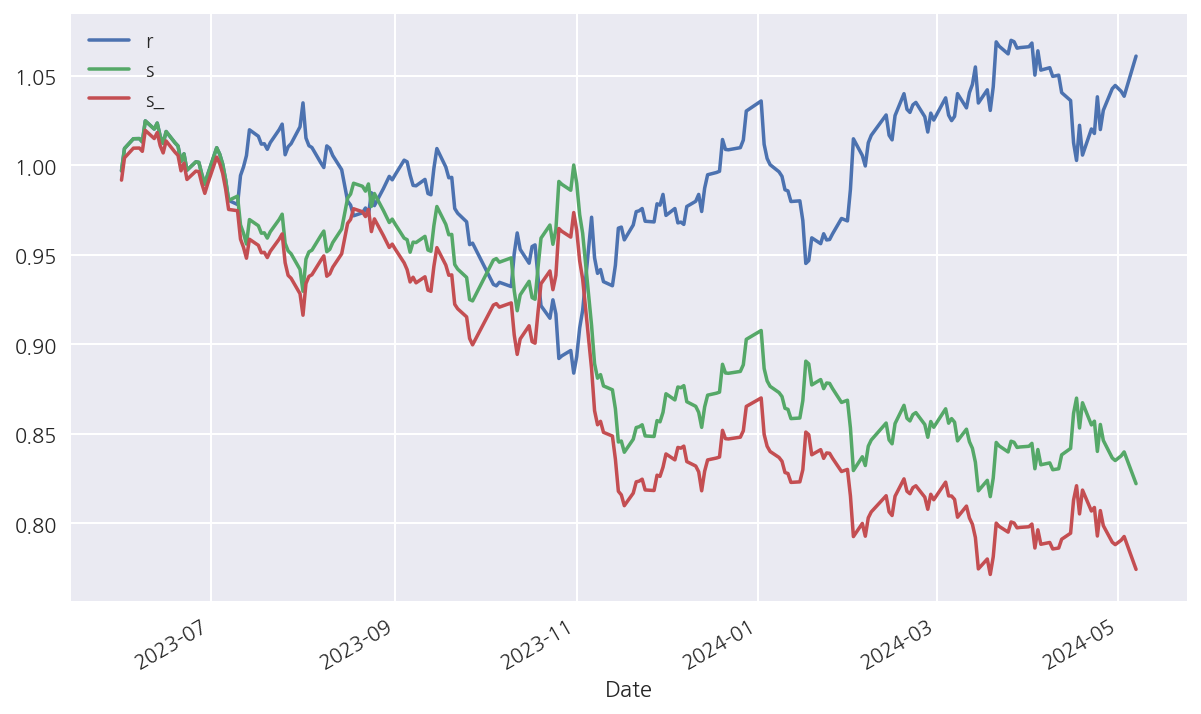

In [69]:
backtest_df[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6));

### 예측 추세

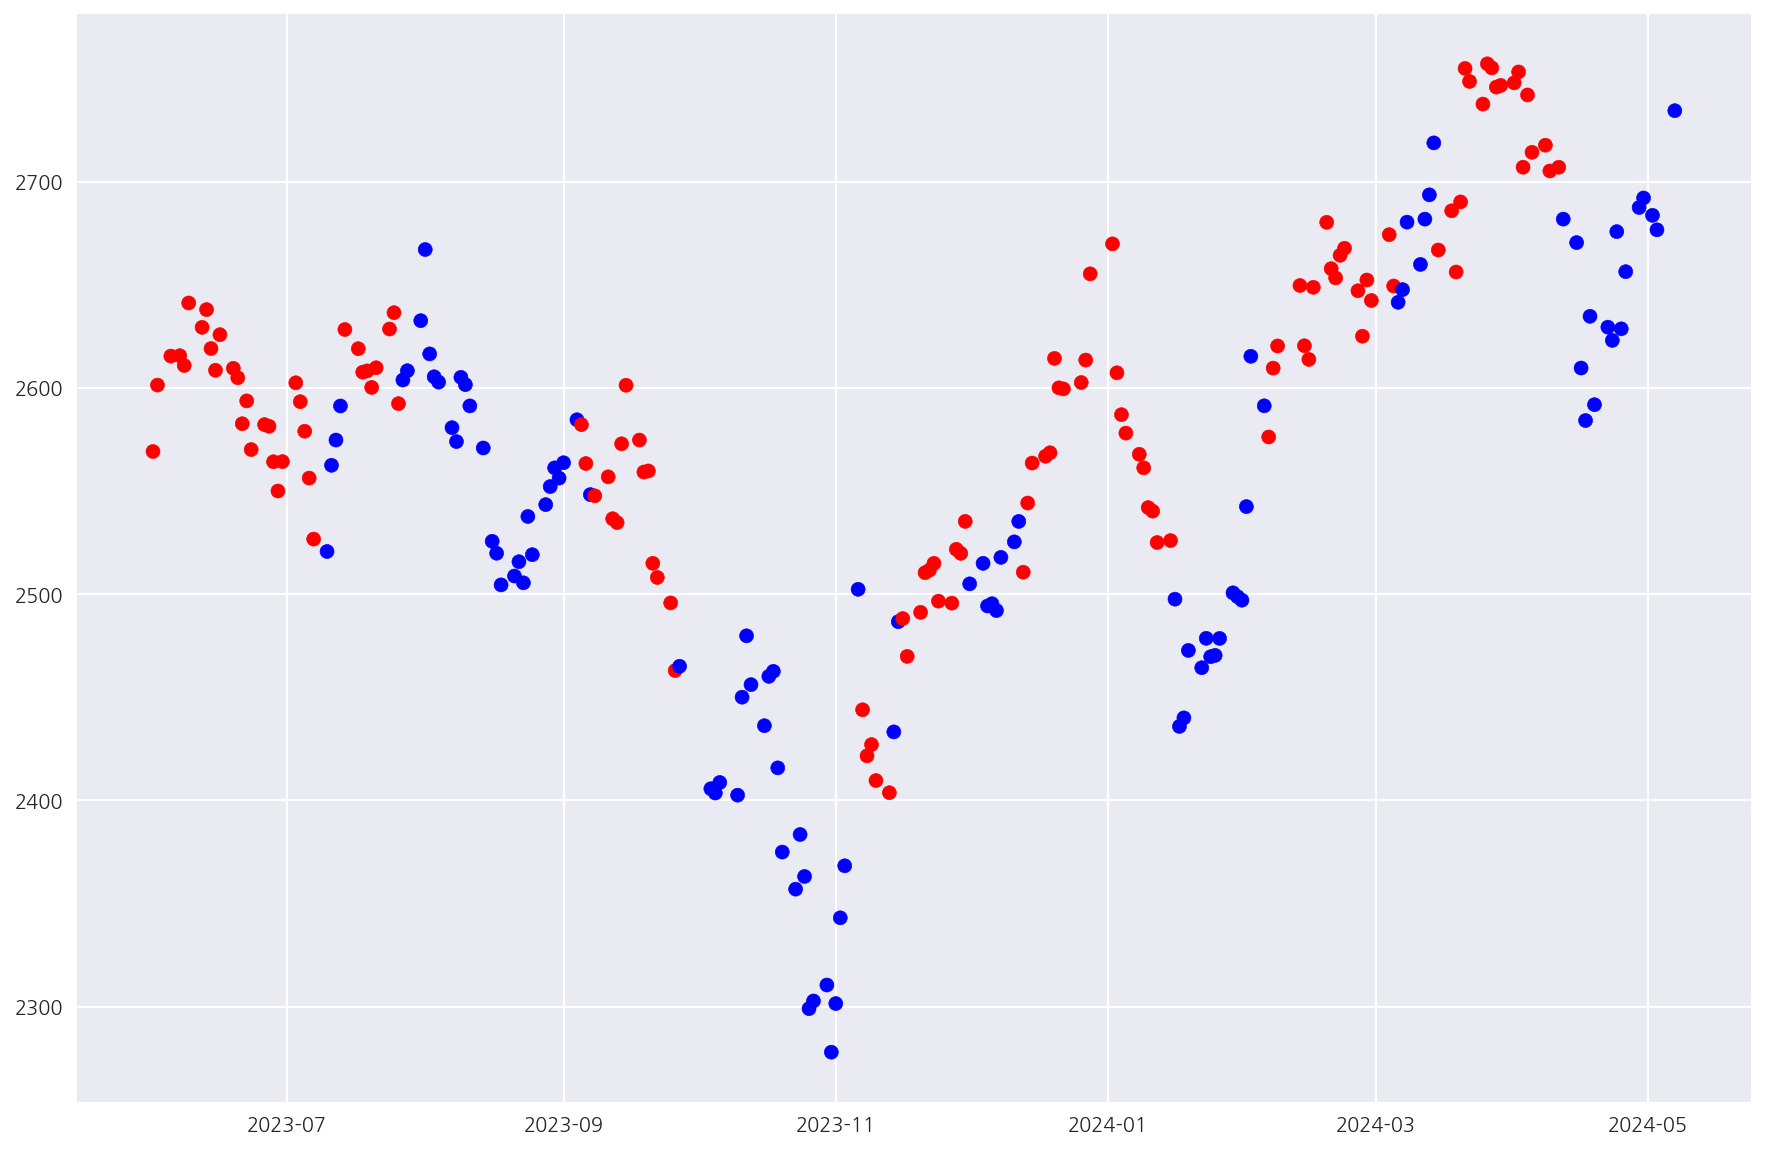

In [70]:
sub_data = df_test['Close'].loc[backtest_df['p'].index]
c_sig = backtest_df['p']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

### 실제 추세

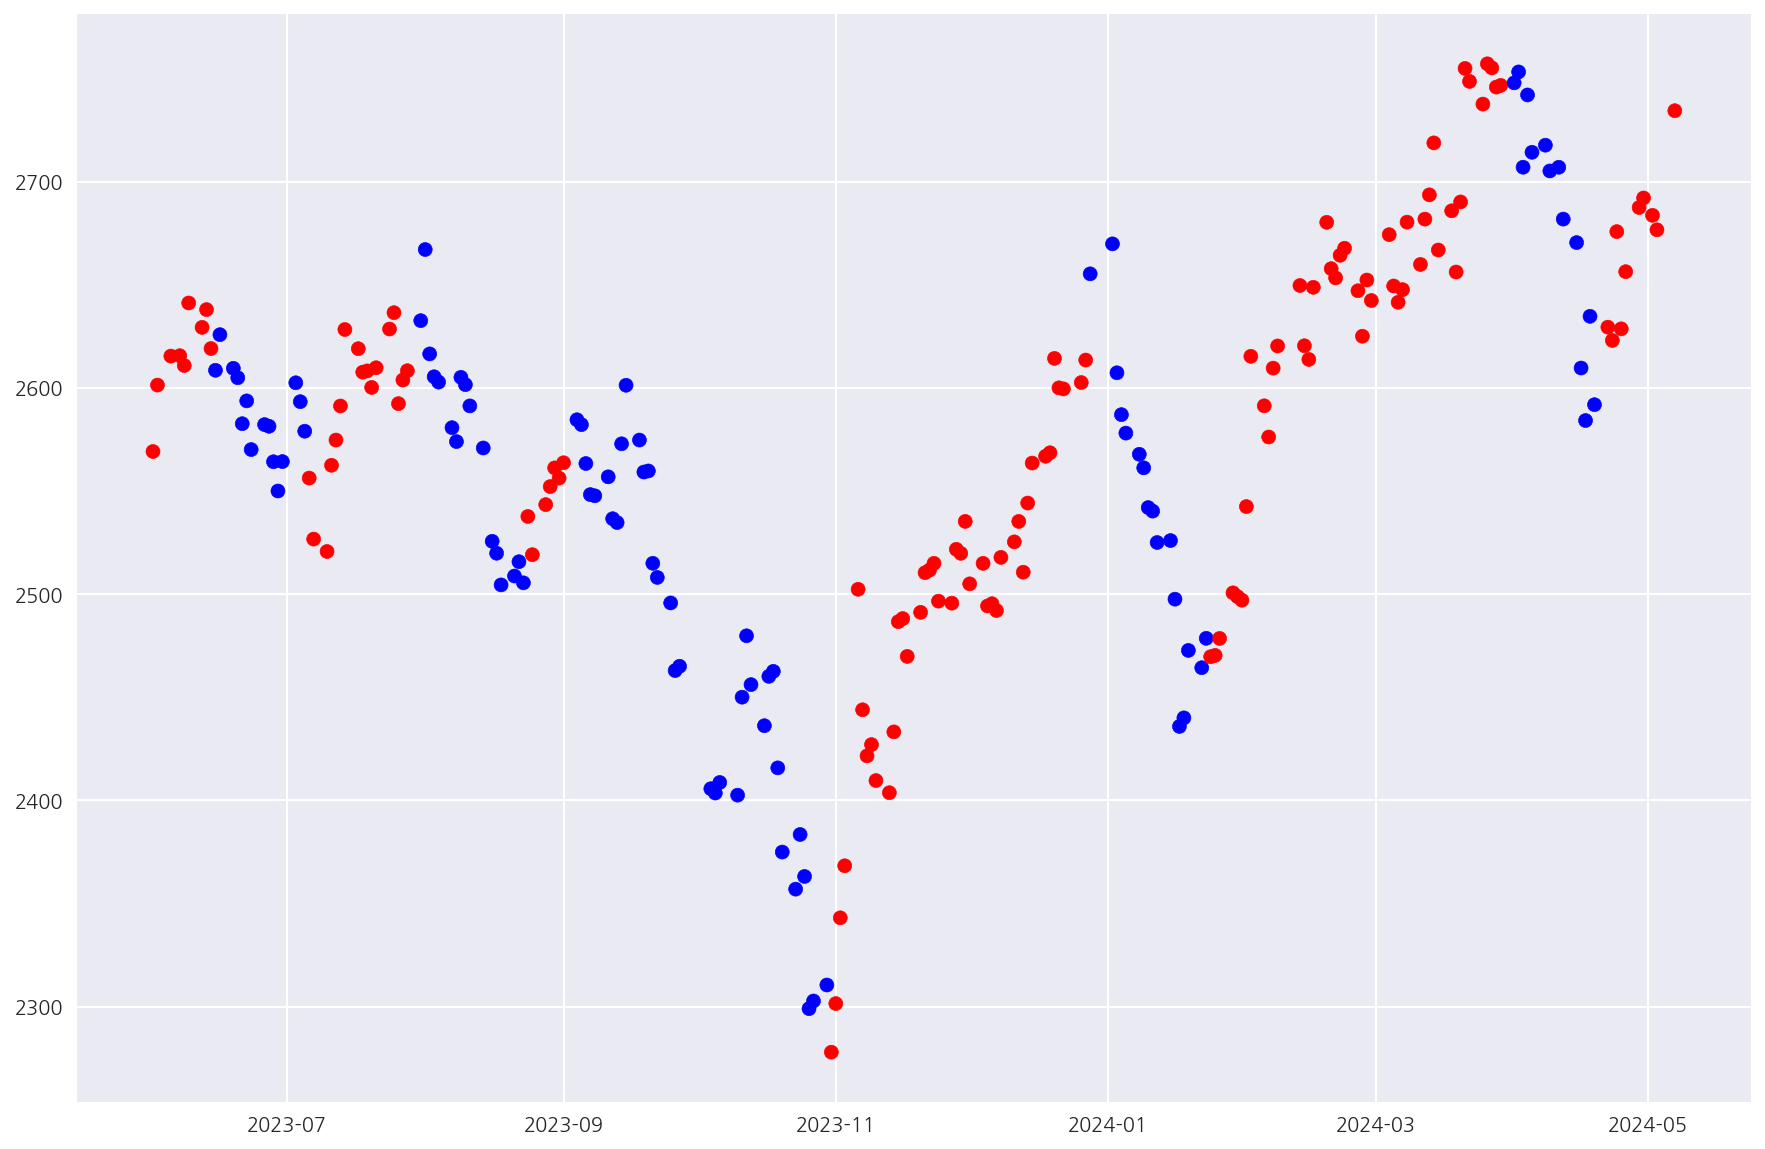

In [71]:
sub_data = df_test['Close'].loc[backtest_df['p'].index]
c_sig = df_test['target'].loc[backtest_df['p'].index]
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

### 메모
1. epoch 15 / 20 / 25 에 따라 성능이 달라진다.

### Blocked Cross Validation

In [72]:
def block_cross_validation(X, y, n_blocks):
    
    block_size = len(X) // n_blocks
    results = []

    for i in range(n_blocks):
        test_index = np.arange(i * block_size, (i + 1) * block_size)
        train_index = np.setdiff1d(np.arange(len(X)), test_index)
        
        X_train_cv, X_test_cv = X[train_index], X[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]

        set_seeds()
        model = create_deep_rnn_model(layer='LSTM', optimizer='adam', features=X_train_val.shape[2])
        model.fit(X_train_cv, y_train_cv, epochs=10, batch_size=16, verbose=1)#, class_weight=cw(y_train_cv)) #, callbacks=[early_stopping_cb])
        
        # 모델 평가
        loss = model.evaluate(X_test_cv, y_test_cv, verbose=1)
        results.append(loss[-2:])
        
        print(f'Block {i+1} Test Accuracy : {loss[-2:]}')

    return results, block_size

n_blocks = 9
results, block_size = block_cross_validation(X_train_val, y_train_val, n_blocks)

Epoch 1/10
124/124 [==============================] - 4s 8ms/step - loss: 0.6485 - binary_accuracy: 0.6391 - auc_10: 0.6836
Epoch 2/10
124/124 [==============================] - 1s 8ms/step - loss: 0.5737 - binary_accuracy: 0.7056 - auc_10: 0.7617
Epoch 3/10
124/124 [==============================] - 1s 8ms/step - loss: 0.5367 - binary_accuracy: 0.7354 - auc_10: 0.7986
Epoch 4/10
124/124 [==============================] - 1s 8ms/step - loss: 0.5107 - binary_accuracy: 0.7676 - auc_10: 0.8249
Epoch 5/10
124/124 [==============================] - 1s 8ms/step - loss: 0.4670 - binary_accuracy: 0.7878 - auc_10: 0.8554
Epoch 6/10
124/124 [==============================] - 1s 8ms/step - loss: 0.4367 - binary_accuracy: 0.8049 - auc_10: 0.8690
Epoch 7/10
124/124 [==============================] - 1s 7ms/step - loss: 0.4122 - binary_accuracy: 0.8196 - auc_10: 0.8885
Epoch 8/10
124/124 [==============================] - 1s 7ms/step - loss: 0.3660 - binary_accuracy: 0.8478 - auc_10: 0.9142
Epoch 9/

In [73]:
results

[[0.75, 0.8315601348876953],
 [0.6572580933570862, 0.7382702231407166],
 [0.5846773982048035, 0.5613499283790588],
 [0.5483871102333069, 0.5469866394996643],
 [0.5887096524238586, 0.6178977489471436],
 [0.7661290168762207, 0.8334308862686157],
 [0.7983871102333069, 0.8537763953208923],
 [0.5524193644523621, 0.5633660554885864],
 [0.6290322542190552, 0.7820706367492676]]

In [74]:
val_mu = np.mean(results, axis=0)[0]
val_mu

0.6527777777777778

In [75]:
val_std = np.std(results, axis=0, ddof=1)[0]
val_std

0.09604574020604471

### 홀드아웃 샘플(Test Set)에 대한 예측 성능 평가 방식은 질문으로

In [76]:
X_blocked = X_train_val[-block_size:]
y_blocked = y_train_val[-block_size:]

In [77]:
X_blocked.shape, y_blocked.shape

((248, 20, 72), (248,))

In [78]:
set_seeds()
model = create_deep_rnn_model(layer='LSTM', optimizer='adam', features=X_train_val.shape[2])

model.fit(X_blocked, y_blocked, epochs=10, batch_size=16, verbose=1)#, class_weight=cw(y_train_val))

Epoch 1/10
16/16 [==============================] - 4s 9ms/step - loss: 0.6236 - binary_accuracy: 0.6734 - auc_19: 0.7006
Epoch 2/10
16/16 [==============================] - 0s 9ms/step - loss: 0.5338 - binary_accuracy: 0.7379 - auc_19: 0.7921
Epoch 3/10
16/16 [==============================] - 0s 9ms/step - loss: 0.4683 - binary_accuracy: 0.8065 - auc_19: 0.8540
Epoch 4/10
16/16 [==============================] - 0s 10ms/step - loss: 0.4250 - binary_accuracy: 0.8347 - auc_19: 0.9004
Epoch 5/10
16/16 [==============================] - 0s 9ms/step - loss: 0.3867 - binary_accuracy: 0.8669 - auc_19: 0.9330
Epoch 6/10
16/16 [==============================] - 0s 9ms/step - loss: 0.3930 - binary_accuracy: 0.8629 - auc_19: 0.9081
Epoch 7/10
16/16 [==============================] - 0s 9ms/step - loss: 0.3696 - binary_accuracy: 0.8710 - auc_19: 0.9272
Epoch 8/10
16/16 [==============================] - 0s 9ms/step - loss: 0.3391 - binary_accuracy: 0.8871 - auc_19: 0.9474
Epoch 9/10
16/16 [=====

In [79]:
evl = model.evaluate(X_test, y_test, verbose=1)
evl

8/8 [==============================] - 1s 5ms/step - loss: 0.8341 - binary_accuracy: 0.5921 - auc_19: 0.6084


[0.8340924978256226, 0.5921052694320679, 0.6084488034248352]

In [80]:
(evl[1] - val_mu) / val_std

-0.631704313127793

In [81]:
len(y_test)

228

In [82]:
test = df_test.iloc[-len(y_test):]
test['target'] = test['target'].apply(lambda x: 1 if x > 0 else 0)
backtest_df = pd.DataFrame(index=test.index)
backtest_df['p'] = model.predict(X_test)
backtest_df['p'] = (backtest_df['p'] > 0.5).astype(int)

In [83]:
# 예측값 비율
backtest_df['p'].value_counts()

0    130
1     98
Name: p, dtype: int64

In [84]:
# 실제 타겟값의 비율
test['target'].value_counts()

1    129
0     99
Name: target, dtype: int64

              precision    recall  f1-score   support

           0       0.49      0.65      0.56        99
           1       0.64      0.49      0.56       129

    accuracy                           0.56       228
   macro avg       0.57      0.57      0.56       228
weighted avg       0.58      0.56      0.56       228



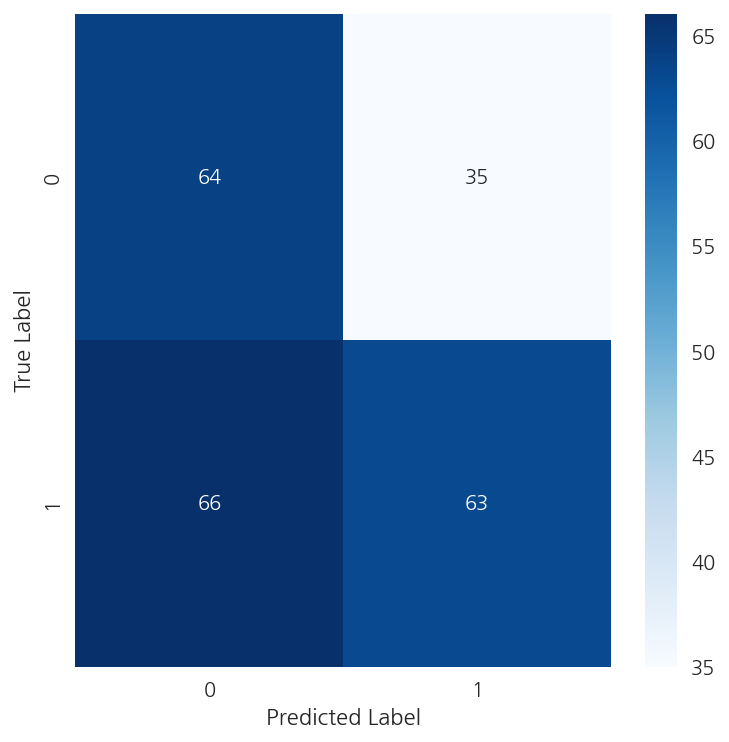

In [85]:
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. 분류 보고서 확인
print(classification_report(test['target'], backtest_df['p']))

# 2. 히트맵 시각화
plt.figure(figsize=(6, 6))
cm2 = confusion_matrix(test['target'], backtest_df['p'])
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 표본 외 경제적 성능 평가

In [86]:
# 매매 포지션 진입, 변경, 청산이 발생한 시점 횟수
sum(backtest_df['p'].diff() != 0) + 1

19

In [87]:
# 포지션 변경에 따른 증권사 수수료 / 거래세
pc = (0.00015 * 2  + 0.0018)

# 슬리피지 적용
sp = 0.001

In [88]:
backtest_df['p'] = np.where(backtest_df['p'] == 0, -1, 1)
backtest_df['r'] = df_test.loc[test.index]['r']
backtest_df['s'] = backtest_df['p'] * backtest_df['r']
backtest_df['s_'] = np.where(backtest_df['p'].diff() != 0,
                      backtest_df['s'] - pc - sp, backtest_df['s'])
backtest_df['s_'].iloc[0] -= pc
backtest_df['s_'].iloc[-1] -= pc
backtest_df

p           r           s          s_
Date                                             
2023-06-01  1 -3.0896e-03 -3.0896e-03 -8.2896e-03
2023-06-02  1  1.2451e-02  1.2451e-02  1.2451e-02
2023-06-05  1  5.3865e-03  5.3865e-03  5.3865e-03
2023-06-07  1  7.2644e-05  7.2644e-05  7.2644e-05
2023-06-08  1 -1.8177e-03 -1.8177e-03 -1.8177e-03
...        ..         ...         ...         ...
2024-04-29 -1  1.1644e-02 -1.1644e-02 -1.1644e-02
2024-04-30 -1  1.7176e-03 -1.7176e-03 -1.7176e-03
2024-05-02 -1 -3.1289e-03  3.1289e-03  3.1289e-03
2024-05-03 -1 -2.6193e-03  2.6193e-03  2.6193e-03
2024-05-07 -1  2.1339e-02 -2.1339e-02 -2.3439e-02

[228 rows x 4 columns]

In [89]:
backtest_df[['r', 's', 's_']].sum().apply(np.exp)

r     1.0610
s     0.8754
s_    0.8245
dtype: float64

In [90]:
backtest_df[['r', 's', 's_']].sum().apply(np.exp) - 1

r     0.0610
s    -0.1246
s_   -0.1755
dtype: float64

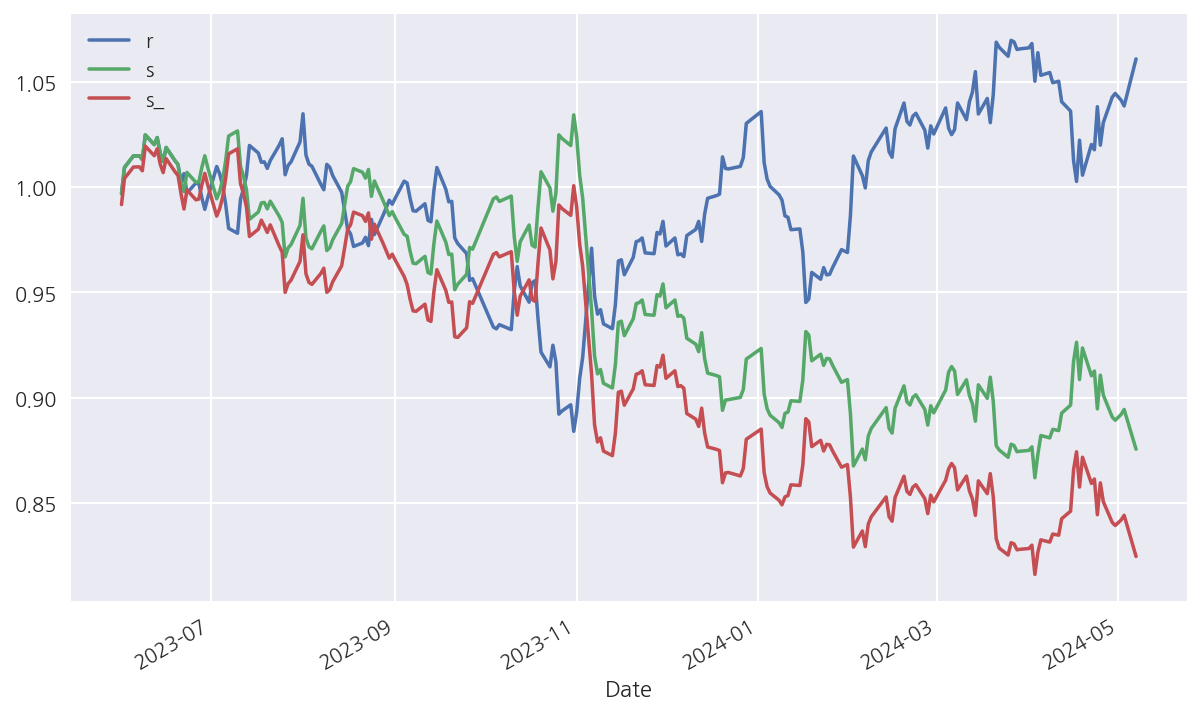

In [91]:
backtest_df[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6));

### 예측 추세

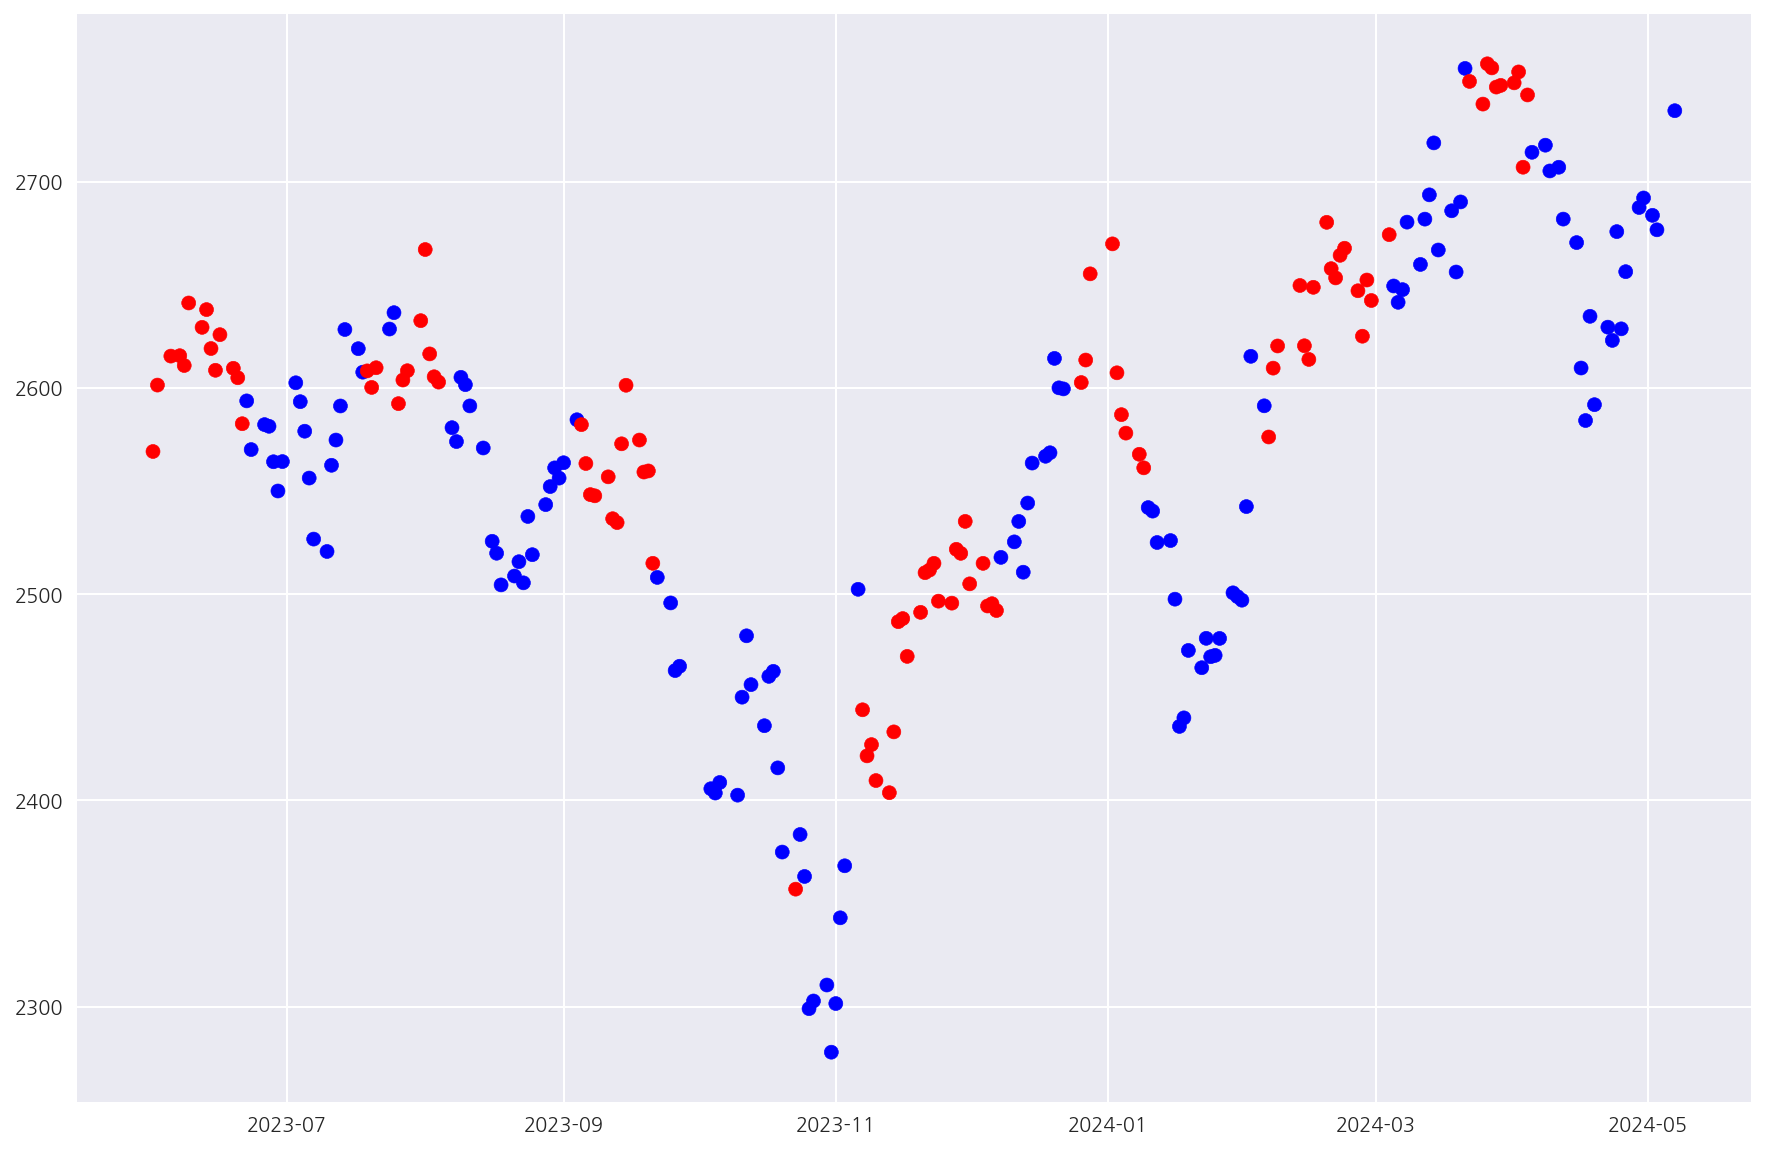

In [92]:
sub_data = df_test['Close'].loc[backtest_df['p'].index]
c_sig = backtest_df['p']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

### 실제 추세

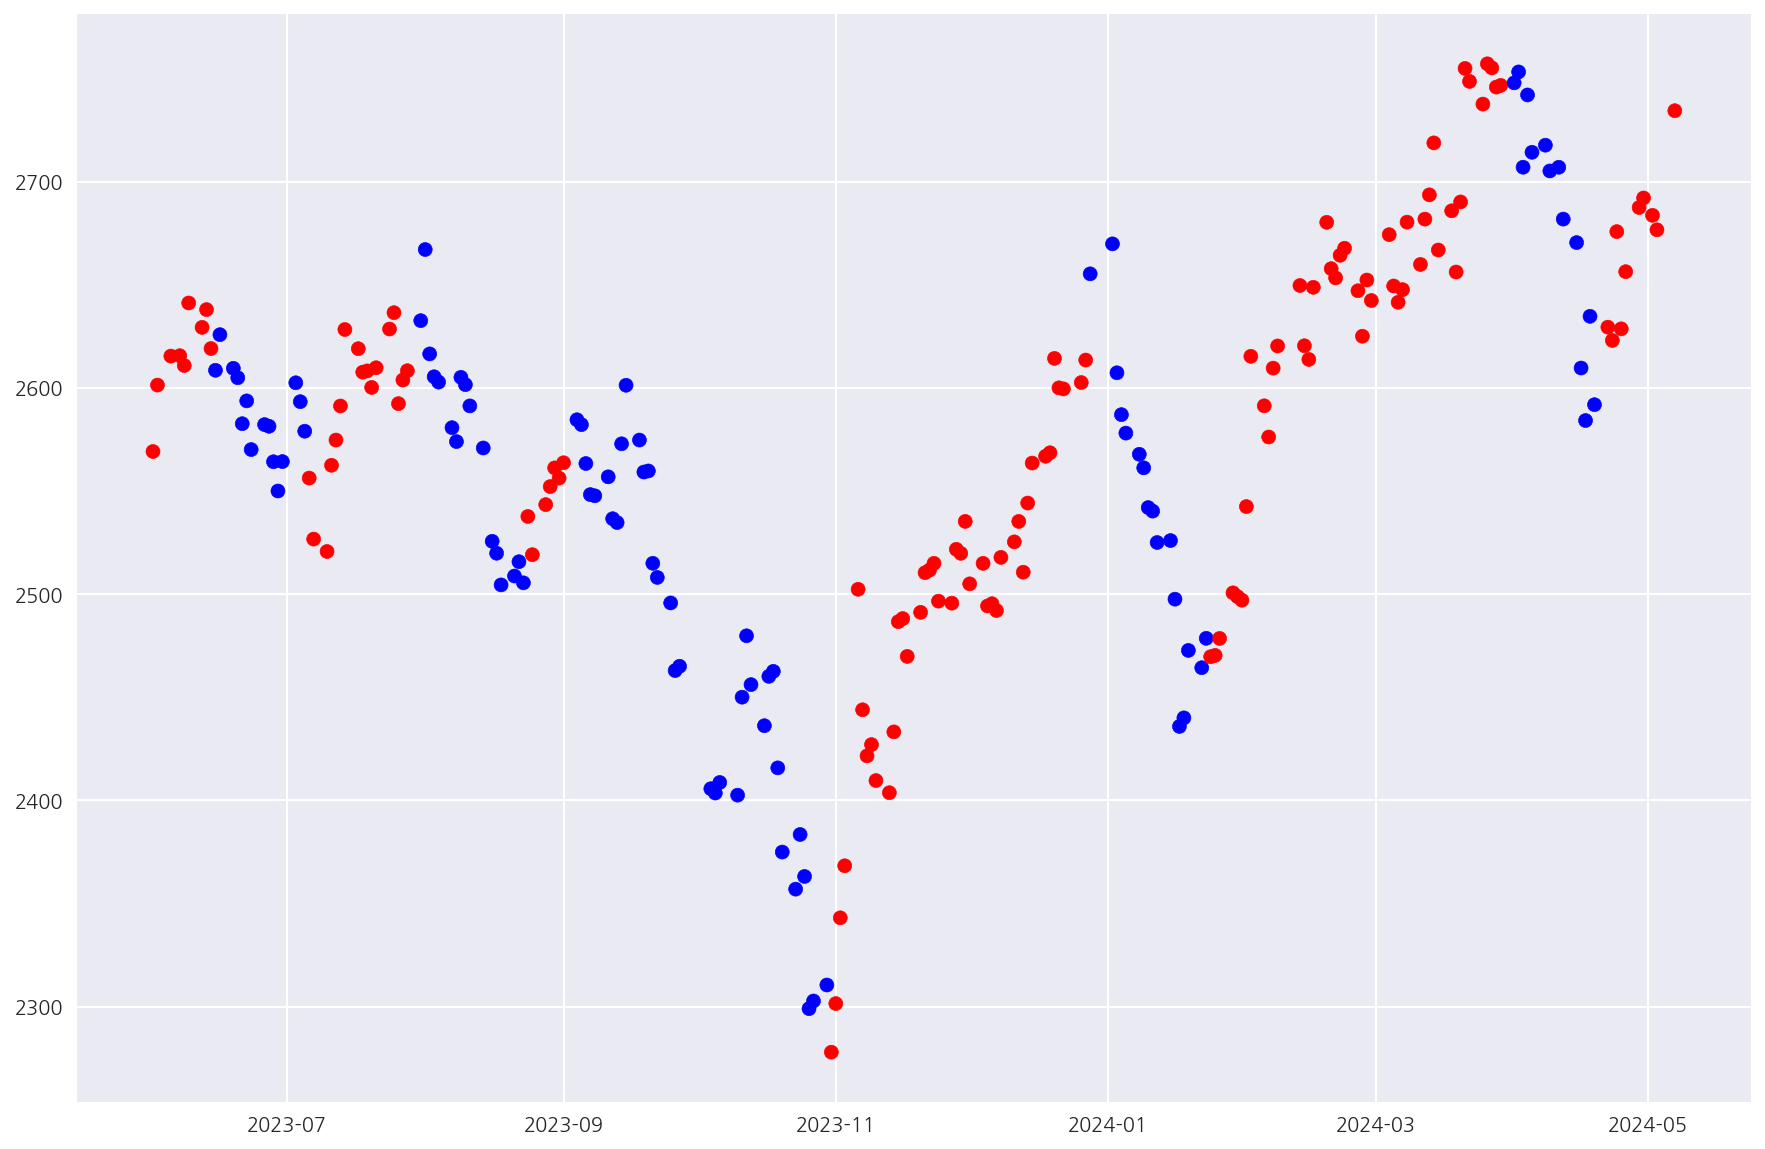

In [93]:
sub_data = df_test['Close'].loc[backtest_df['p'].index]
c_sig = df_test['target'].loc[backtest_df['p'].index]
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

### Advanced B CV

In [94]:
# 테스트 블록 크기, 훈련 블록의 배수, 스플릿 수 설정
test_block_size = 250
train_block_factor = 4
n_splits = 9

    
results = []
for i in range(n_splits):
    test_start = i * test_block_size
    test_end = test_start + test_block_size
    
    train_start = max(0, test_start - train_block_factor * test_block_size)
    train_end = test_start
    
    X_train_cv, X_test_cv = X_train_val[train_start:train_end], X_train_val[test_start:test_end]
    y_train_cv, y_test_cv = y_train_val[train_start:train_end], y_train_val[test_start:test_end]
    if len(X_train_cv) == 0 or len(X_test_cv) != test_block_size:
        continue
        
        
    set_seeds()
    model = create_deep_rnn_model(layer='LSTM', optimizer='adam', features=X_train_val.shape[2])
    model.fit(X_train_cv, y_train_cv, epochs=10, batch_size=16, verbose=1)#, class_weight=cw(y_train_cv)) #, callbacks=[early_stopping_cb])
    
    # 모델 평가
    loss = model.evaluate(X_test_cv, y_test_cv, verbose=1)
    results.append(loss[-2:])
    
    print(f'Block {i} Test Accuracy : {loss[-2:]}')

Epoch 1/10
16/16 [==============================] - 3s 10ms/step - loss: 0.6974 - binary_accuracy: 0.5640 - auc_20: 0.6703
Epoch 2/10
16/16 [==============================] - 0s 9ms/step - loss: 0.5801 - binary_accuracy: 0.6640 - auc_20: 0.7963
Epoch 3/10
16/16 [==============================] - 0s 9ms/step - loss: 0.5478 - binary_accuracy: 0.7120 - auc_20: 0.8254
Epoch 4/10
16/16 [==============================] - 0s 10ms/step - loss: 0.5199 - binary_accuracy: 0.7480 - auc_20: 0.8565
Epoch 5/10
16/16 [==============================] - 0s 10ms/step - loss: 0.4741 - binary_accuracy: 0.7840 - auc_20: 0.8915
Epoch 6/10
16/16 [==============================] - 0s 9ms/step - loss: 0.4677 - binary_accuracy: 0.7920 - auc_20: 0.8814
Epoch 7/10
16/16 [==============================] - 0s 9ms/step - loss: 0.4145 - binary_accuracy: 0.8640 - auc_20: 0.9385
Epoch 8/10
16/16 [==============================] - 0s 10ms/step - loss: 0.3930 - binary_accuracy: 0.8440 - auc_20: 0.9433
Epoch 9/10
16/16 [==

In [95]:
test_start, test_end 

(2000, 2250)

In [96]:
train_start, train_end

(1000, 2000)

In [97]:
len(X_train_cv), len(X_test_cv)

(1000, 232)

In [98]:
results

[[0.6520000100135803, 0.7146197557449341],
 [0.6240000128746033, 0.6083034873008728],
 [0.6840000152587891, 0.6930481195449829],
 [0.5239999890327454, 0.5802572965621948],
 [0.7200000286102295, 0.7899844646453857],
 [0.6480000019073486, 0.6581579446792603],
 [0.6159999966621399, 0.6667447090148926]]

In [99]:
val_mu = np.mean(results, axis=0)[0]
val_mu

0.638285722051348

In [100]:
val_std = np.std(results, axis=0, ddof=1)[0]
val_std

0.06165959947119822

### 홀드아웃 샘플(Test Set)에 대한 예측 성능 평가 방식은 질문으로

In [101]:
X_blocked = X_train_val[-test_block_size* train_block_factor:]
y_blocked = y_train_val[-test_block_size* train_block_factor:]

In [102]:
X_blocked.shape, y_blocked.shape

((1000, 20, 72), (1000,))

In [103]:
set_seeds()
model = create_deep_rnn_model(layer='LSTM', optimizer='adam', features=X_train_val.shape[2])

model.fit(X_blocked, y_blocked, epochs=10, batch_size=16, verbose=1)#, class_weight=cw(y_train_val))

Epoch 1/10
63/63 [==============================] - 4s 9ms/step - loss: 0.6752 - binary_accuracy: 0.6310 - auc_27: 0.6553
Epoch 2/10
63/63 [==============================] - 1s 9ms/step - loss: 0.5708 - binary_accuracy: 0.7150 - auc_27: 0.7582
Epoch 3/10
63/63 [==============================] - 1s 9ms/step - loss: 0.5567 - binary_accuracy: 0.7310 - auc_27: 0.7798
Epoch 4/10
63/63 [==============================] - 1s 9ms/step - loss: 0.4927 - binary_accuracy: 0.7770 - auc_27: 0.8522
Epoch 5/10
63/63 [==============================] - 1s 9ms/step - loss: 0.4709 - binary_accuracy: 0.7850 - auc_27: 0.8613
Epoch 6/10
63/63 [==============================] - 1s 9ms/step - loss: 0.4377 - binary_accuracy: 0.8020 - auc_27: 0.8876
Epoch 7/10
63/63 [==============================] - 1s 9ms/step - loss: 0.3917 - binary_accuracy: 0.8340 - auc_27: 0.9083
Epoch 8/10
63/63 [==============================] - 1s 10ms/step - loss: 0.3522 - binary_accuracy: 0.8670 - auc_27: 0.9304
Epoch 9/10
63/63 [=====

In [104]:
evl = model.evaluate(X_test, y_test, verbose=1)
evl

8/8 [==============================] - 1s 5ms/step - loss: 0.9907 - binary_accuracy: 0.6447 - auc_27: 0.6559


[0.990692138671875, 0.6447368264198303, 0.655860960483551]

In [105]:
(evl[1] - val_mu) / val_std

0.10462449357128337

In [106]:
len(y_test)

228

In [107]:
test = df_test.iloc[-len(y_test):]
test['target'] = test['target'].apply(lambda x: 1 if x > 0 else 0)
backtest_df = pd.DataFrame(index=test.index)
backtest_df['p'] = model.predict(X_test)
backtest_df['p'] = (backtest_df['p'] > 0.5).astype(int)

In [108]:
# 예측값 비율
backtest_df['p'].value_counts()

1    130
0     98
Name: p, dtype: int64

In [109]:
# 실제 타겟값의 비율
test['target'].value_counts()

1    129
0     99
Name: target, dtype: int64

              precision    recall  f1-score   support

           0       0.55      0.55      0.55        99
           1       0.65      0.66      0.66       129

    accuracy                           0.61       228
   macro avg       0.60      0.60      0.60       228
weighted avg       0.61      0.61      0.61       228



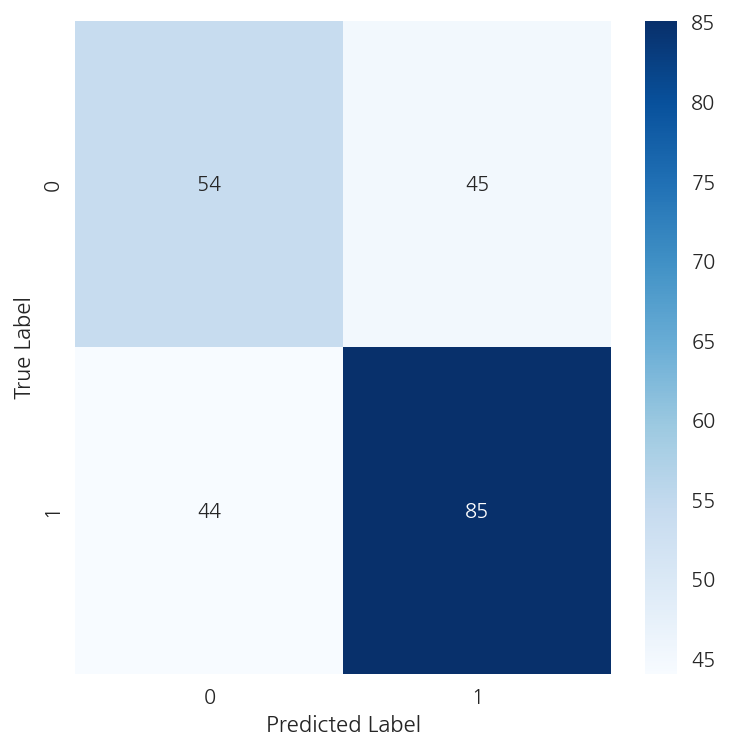

In [110]:
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. 분류 보고서 확인
print(classification_report(test['target'], backtest_df['p']))

# 2. 히트맵 시각화
plt.figure(figsize=(6, 6))
cm2 = confusion_matrix(test['target'], backtest_df['p'])
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 표본 외 경제적 성능 평가

In [111]:
# 매매 포지션 진입, 변경, 청산이 발생한 시점 횟수
sum(backtest_df['p'].diff() != 0) + 1

15

In [112]:
# 포지션 변경에 따른 증권사 수수료 / 거래세
pc = (0.00015 * 2  + 0.0018)

# 슬리피지 적용
sp = 0.001

In [113]:
backtest_df['p'] = np.where(backtest_df['p'] == 0, -1, 1)
backtest_df['r'] = df_test.loc[test.index]['r']
backtest_df['s'] = backtest_df['p'] * backtest_df['r']
backtest_df['s_'] = np.where(backtest_df['p'].diff() != 0,
                      backtest_df['s'] - pc - sp, backtest_df['s'])
backtest_df['s_'].iloc[0] -= pc
backtest_df['s_'].iloc[-1] -= pc
backtest_df

p           r           s          s_
Date                                             
2023-06-01  1 -3.0896e-03 -3.0896e-03 -8.2896e-03
2023-06-02  1  1.2451e-02  1.2451e-02  1.2451e-02
2023-06-05  1  5.3865e-03  5.3865e-03  5.3865e-03
2023-06-07  1  7.2644e-05  7.2644e-05  7.2644e-05
2023-06-08  1 -1.8177e-03 -1.8177e-03 -1.8177e-03
...        ..         ...         ...         ...
2024-04-29 -1  1.1644e-02 -1.1644e-02 -1.1644e-02
2024-04-30 -1  1.7176e-03 -1.7176e-03 -1.7176e-03
2024-05-02 -1 -3.1289e-03  3.1289e-03  3.1289e-03
2024-05-03 -1 -2.6193e-03  2.6193e-03  2.6193e-03
2024-05-07 -1  2.1339e-02 -2.1339e-02 -2.3439e-02

[228 rows x 4 columns]

In [114]:
backtest_df[['r', 's', 's_']].sum().apply(np.exp)

r     1.0610
s     1.0277
s_    0.9799
dtype: float64

In [115]:
backtest_df[['r', 's', 's_']].sum().apply(np.exp) - 1

r     0.0610
s     0.0277
s_   -0.0201
dtype: float64

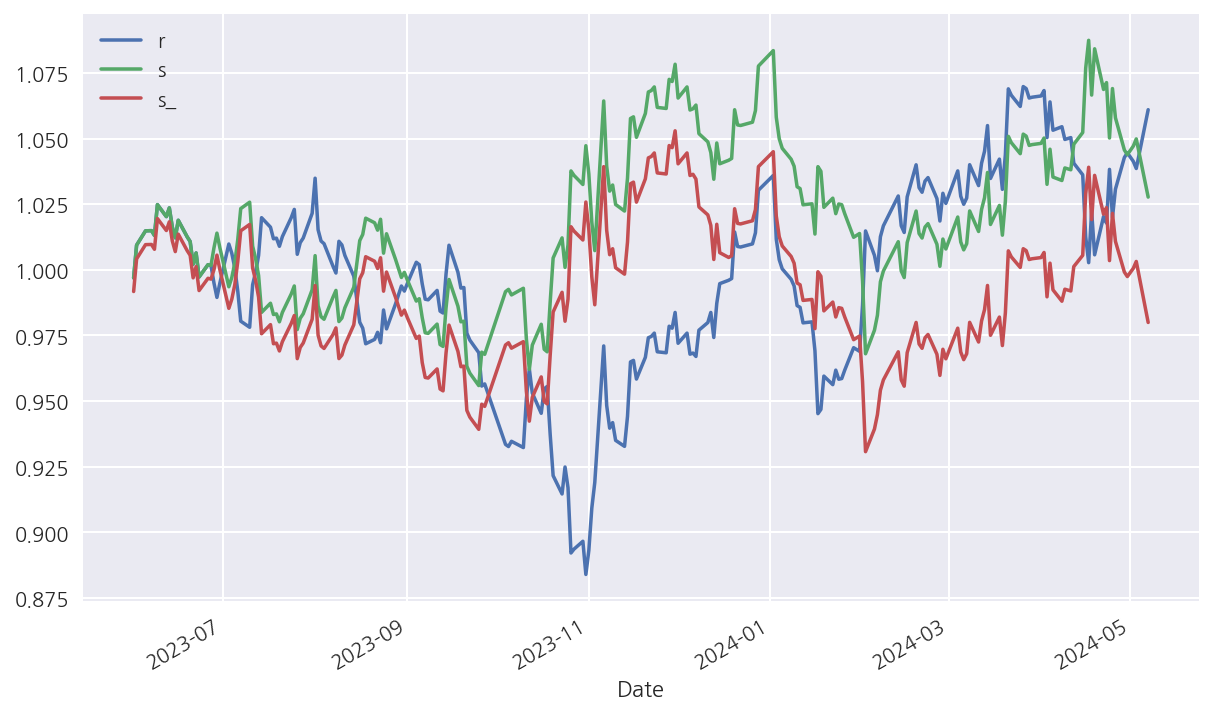

In [116]:
backtest_df[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6));

### 예측 추세

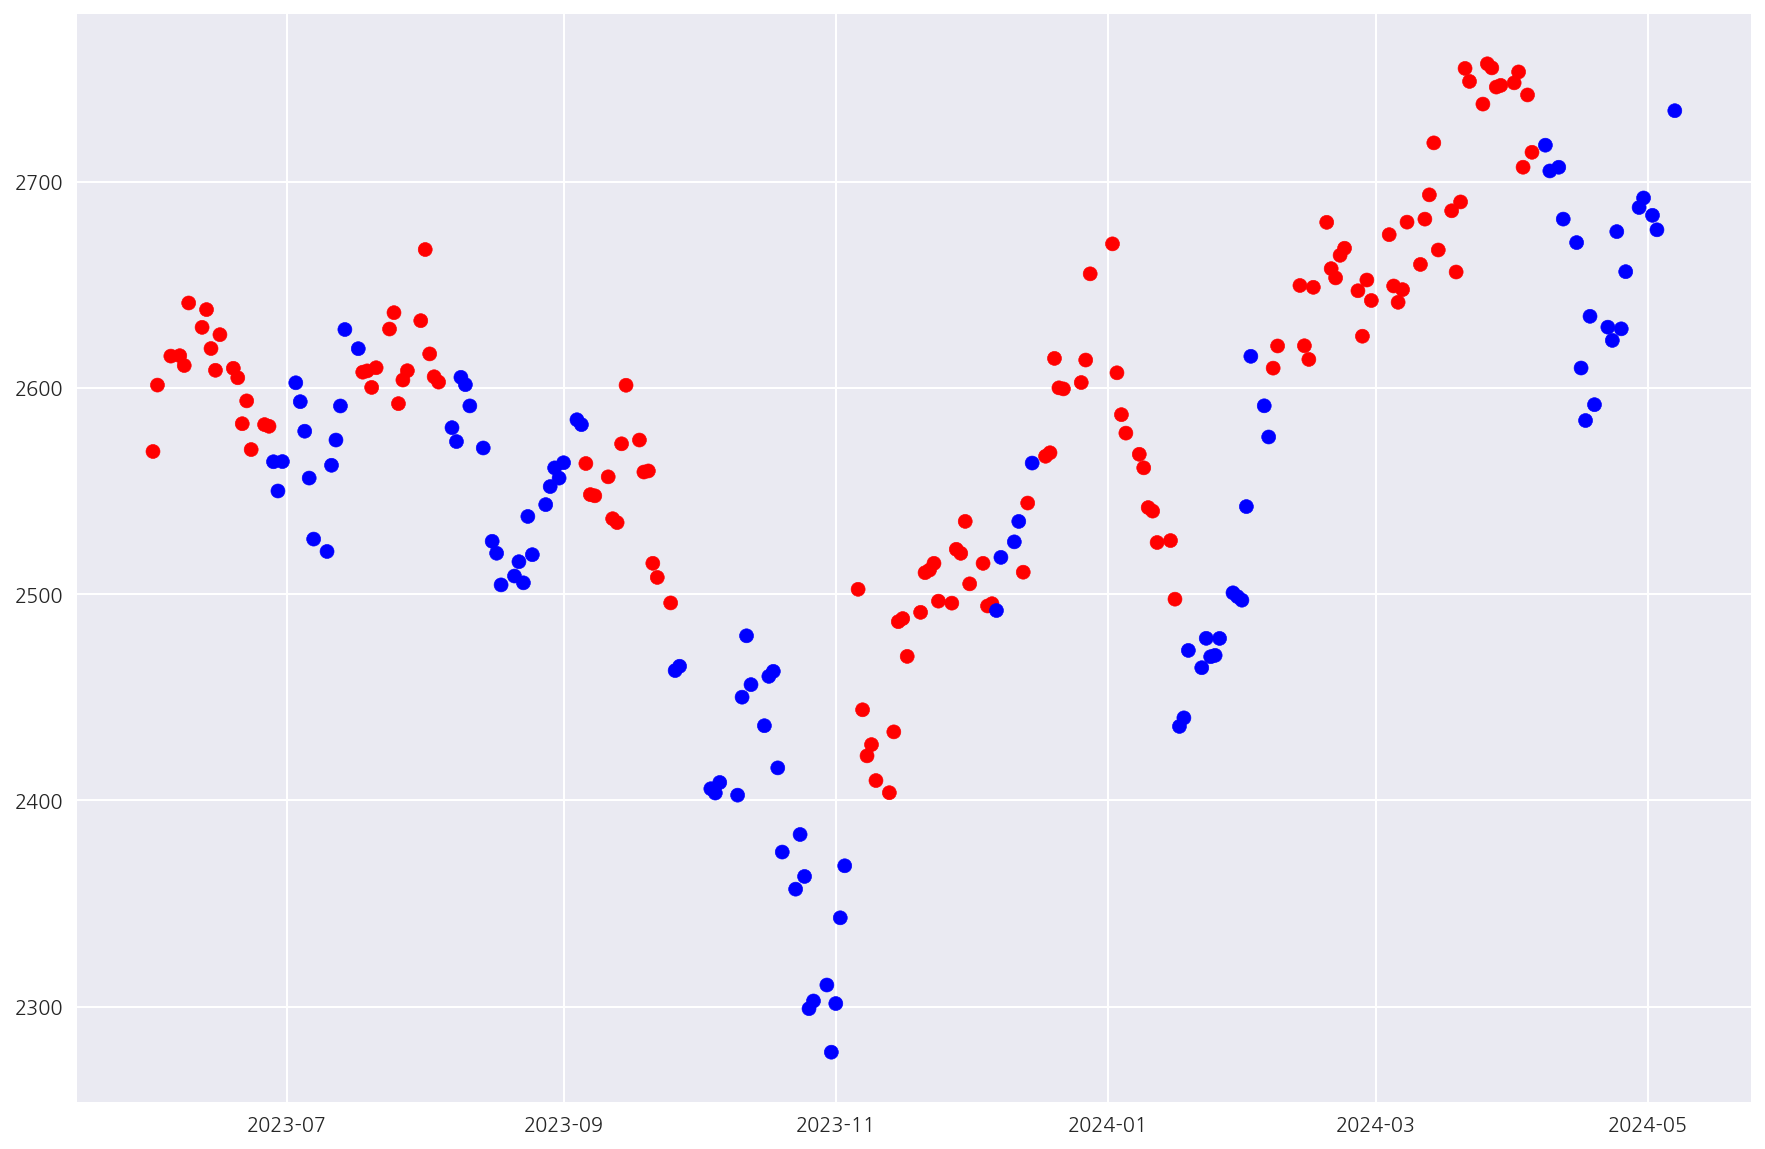

In [117]:
sub_data = df_test['Close'].loc[backtest_df['p'].index]
c_sig = backtest_df['p']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

### 실제 추세

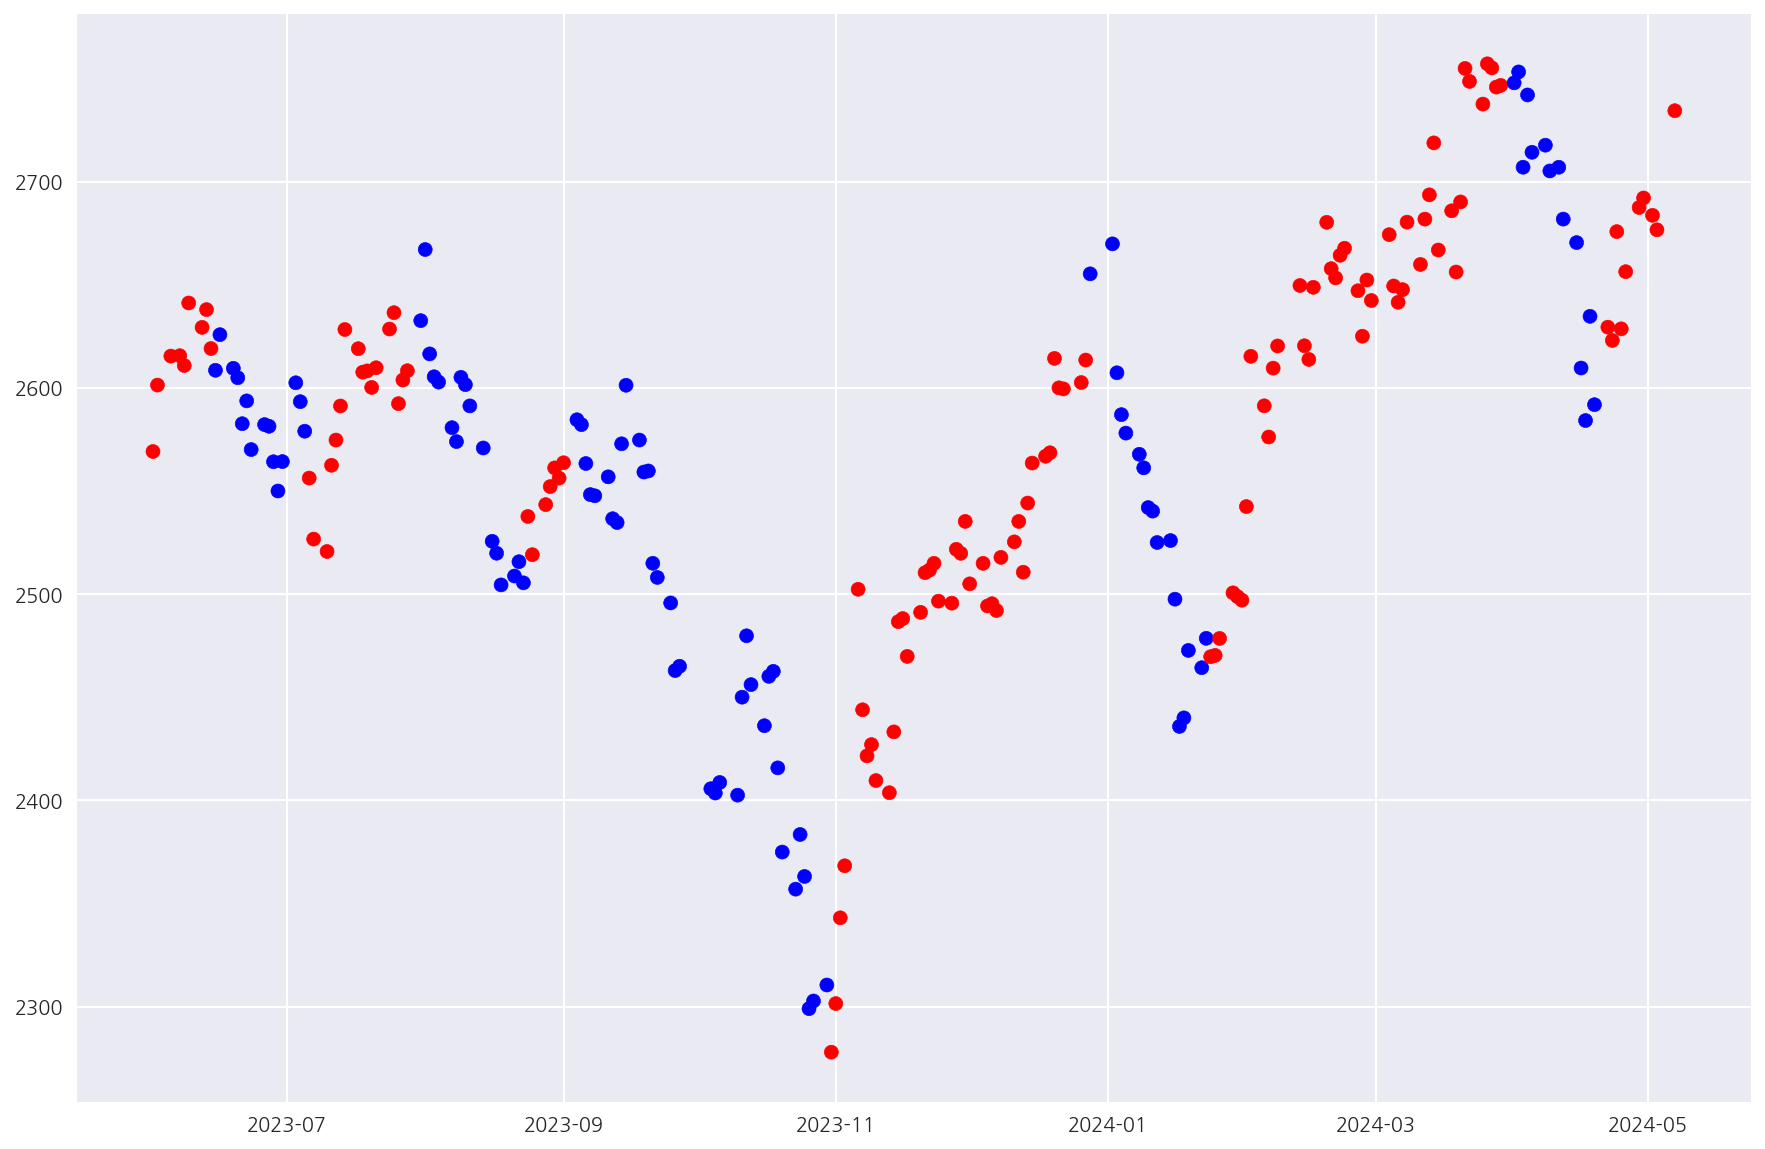

In [118]:
sub_data = df_test['Close'].loc[backtest_df['p'].index]
c_sig = df_test['target'].loc[backtest_df['p'].index]
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

### PCA and Feature Importance

In [164]:
from sklearn.preprocessing import StandardScaler
scaler_ = StandardScaler()

In [165]:
scaler_ = StandardScaler() # StandardScaler  RobustScaler
X_features_ = df_train.columns.values[~(df_train.columns.values == 'target')]
scaled_df_train = scaler_.fit_transform(df_train.loc[:, X_features])
scaled_df_train = pd.DataFrame(scaled_df_train, index=df_train.index, columns=df_train.loc[:, X_features].columns)
scaled_df_train

Open    High     Low   Close  Volume  MarCap  매도_금융투자  매수_금융투자  \
Date                                                                           
2014-03-07 -0.8790 -0.8917 -0.8784 -0.8902 -0.9730 -1.1500  -0.9156  -0.8166   
2014-03-10 -0.9121 -0.9349 -0.9246 -0.9458 -1.0243 -1.1841  -0.7020  -0.8360   
2014-03-11 -0.9407 -0.9453 -0.9267 -0.9199 -0.9238 -1.1684  -0.8765  -0.8183   
2014-03-12 -0.9394 -0.9610 -0.9840 -1.0059 -0.6692 -1.2225  -0.4481  -0.2674   
2014-03-13 -0.9869 -0.9932 -0.9804 -1.0008 -0.8863 -1.2199  -0.5551  -0.3700   
...            ...     ...     ...     ...     ...     ...      ...      ...   
2023-04-24  0.6531  0.6289  0.6418  0.6161  1.1751  1.2857   0.1359   0.6825   
2023-04-25  0.6339  0.6002  0.5136  0.5215  1.0492  1.1987   0.7150   0.6076   
2023-04-26  0.5191  0.5109  0.5386  0.5100  1.6754  1.1911   0.3731   0.1293   
2023-04-27  0.5049  0.5121  0.4956  0.5401  0.5770  1.2192   1.9081   0.2555   
2023-04-28  0.5802  0.5615  0.5612  0.5558  0.7130  1.2362   1.0886   0.2954   

            순매수_금융투자   매도_보험  ...   ret_5  vol_change_10  ret_10  \
Date                          ...                                  
2014-03-07    0.1200  0.2815  ... -0.1483         0.0328  0.2085   
2014-03-10   -0.1859  0.5660  ... -0.2565         0.1410  0.0322   
2014-03-11    0.0665  1.0998  ...  0.1778         0.1011 -0.0660   
2014-03-12    0.2338  1.2134  ... -0.8684         1.4548 -0.6352   
2014-03-13    0.2383  0.4525  ... -0.9211         0.6522 -0.7216   
...              ...     ...  ...     ...            ...     ...   
2023-04-24    0.7250 -1.0318  ... -0.8987         0.6541  0.0861   
2023-04-25   -0.1336 -0.8336  ... -1.3904         0.2669 -0.7466   
2023-04-26   -0.3181 -0.7965  ... -1.5232         0.4220 -0.8281   
2023-04-27   -2.1642 -0.6658  ... -1.1498        -0.5254 -0.8252   
2023-04-28   -1.0367 -0.9178  ... -0.7502        -0.5259 -0.8704   

            vol_change_20  ret_20  std_30  vol_std_30  dowjones  nasdaq  \
Date                                                                      
2014-03-07        -0.5811  0.4935 -0.6553     -1.0020   -1.3452 -1.1615   
2014-03-10        -0.1066  0.2651 -0.6525     -1.0010   -1.3403 -1.1662   
2014-03-11         0.0460  0.2710 -0.6423     -1.0141   -1.3457 -1.1667   
2014-03-12         0.9955 -0.1077 -0.6637     -1.0278   -1.3565 -1.1748   
2014-03-13         0.7858  0.0081 -0.6780     -1.0330   -1.3583 -1.1700   
...                   ...     ...     ...         ...       ...     ...   
2023-04-24         2.2685  0.9164  0.8562      0.8858    1.4267  1.1174   
2023-04-25         1.5788  0.3907  0.7254      0.8966    1.4373  1.1070   
2023-04-26         2.8569  0.2767  0.6387      0.9840    1.3823  1.0368   
2023-04-27         0.2327  0.2902  0.5388      0.8554    1.3458  1.0530   
2023-04-28         0.0021  0.1354  0.4608      0.7425    1.4294  1.1380   

            s&p500  
Date                
2014-03-07 -1.2473  
2014-03-10 -1.2461  
2014-03-11 -1.2472  
2014-03-12 -1.2585  
2014-03-13 -1.2578  
...            ...  
2023-04-24  1.4303  
2023-04-25  1.4344  
2023-04-26  1.3568  
2023-04-27  1.3383  
2023-04-28  1.4324  

[2252 rows x 72 columns]

In [166]:
# PCA 불러오기  
from sklearn.decomposition import PCA

# PCA 적용
pca = PCA().fit(scaled_df_train)
pca

PCA()

In [167]:
# Explained Variance의 누적합 계산  
explained_variance_ratio = pca.explained_variance_ratio_ # explained_variance_ratio_: Explained Variance 비율을 계산해 주는 함수
cumulative_explained_variance = np.cumsum(explained_variance_ratio) # cumsum: 각 원소의 누적합을 계산하는 함수

In [168]:
explained_variance_ratio

array([0.2558, 0.1263, 0.064 , 0.0527, 0.0461, 0.0388, 0.0333, 0.0289,
       0.0273, 0.0254, 0.0244, 0.0217, 0.0209, 0.0192, 0.0184, 0.0166,
       0.0162, 0.0136, 0.0134, 0.0127, 0.0119, 0.0107, 0.01  , 0.0089,
       0.0074, 0.0072, 0.0069, 0.0068, 0.0062, 0.0057, 0.005 , 0.0049,
       0.0045, 0.0039, 0.0037, 0.0035, 0.0029, 0.0028, 0.0023, 0.0019,
       0.0018, 0.0014, 0.0012, 0.0011, 0.0006, 0.0004, 0.0002, 0.0002,
       0.0002, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ])

In [169]:
cumulative_explained_variance

array([0.2558, 0.3821, 0.4462, 0.4989, 0.5449, 0.5837, 0.6171, 0.646 ,
       0.6733, 0.6987, 0.7231, 0.7449, 0.7658, 0.785 , 0.8034, 0.82  ,
       0.8362, 0.8498, 0.8632, 0.8759, 0.8879, 0.8985, 0.9085, 0.9174,
       0.9248, 0.932 , 0.9388, 0.9456, 0.9518, 0.9576, 0.9626, 0.9675,
       0.972 , 0.9758, 0.9795, 0.983 , 0.9859, 0.9886, 0.991 , 0.9929,
       0.9947, 0.9961, 0.9973, 0.9983, 0.9989, 0.9993, 0.9996, 0.9998,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ])

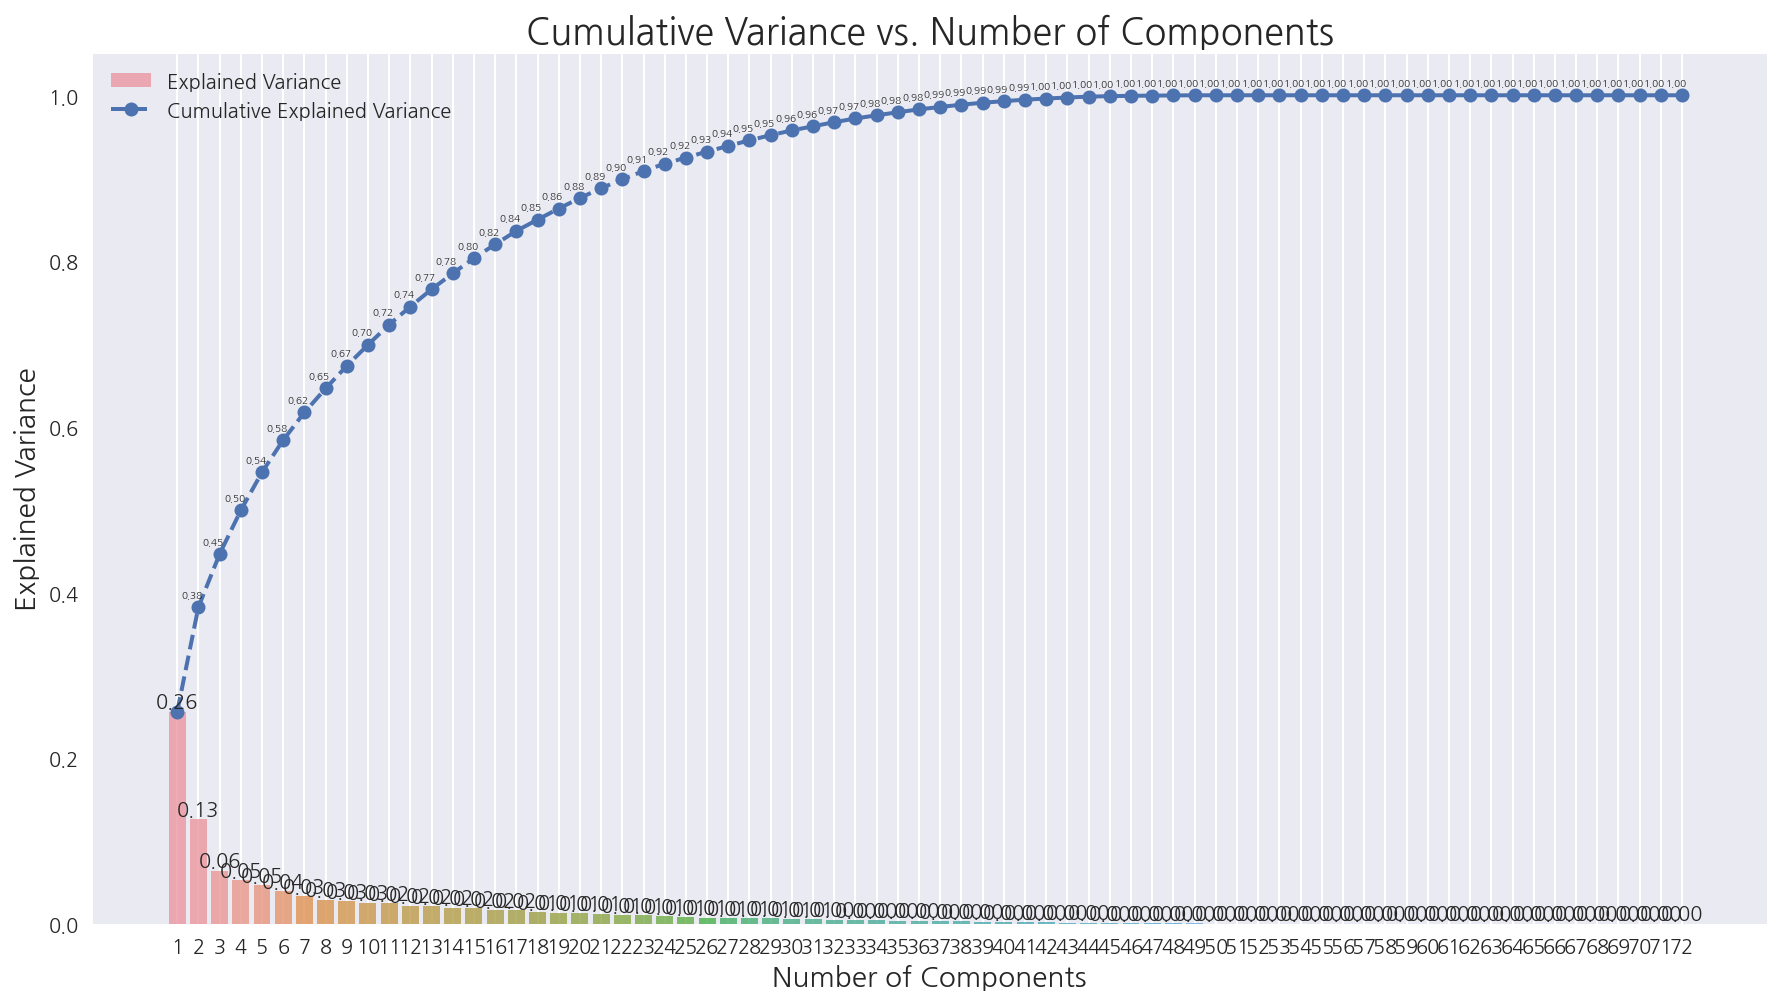

In [170]:
plt.figure(figsize=(15, 8)) 

# 각 성분의 설명된 분포에 대한 막대 그래프
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)), y=explained_variance_ratio, alpha=0.8)

# 누적 분포에 대한 선 그래프
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance, marker='o', linestyle='--', linewidth=2)

# 레이블과 제목 설정
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# 눈금 및 범례 사용자 정의
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot],
           labels=['Explained Variance', 'Cumulative Explained Variance'])  

# 두 그래프의 분산 값 표시
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=5)

plt.grid(axis='both')   
plt.show()

In [274]:
# n개의 주성분을 유지하는 PCA 선언 
pca = PCA(n_components=0.9)

# 기존 data를 pca에 fit_transform
pca_df_train = pca.fit_transform(scaled_df_train)

# 압축된 데이터 셋 생성
pca_df_train = pd.DataFrame(pca_df_train, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# 인덱스 다시 추가
pca_df_train.index = scaled_df_train.index

# 타깃값 다시 추가
pca_df_train['target'] = df_train['target']

In [275]:
pca_df_train

PC1     PC2     PC3     PC4     PC5     PC6     PC7     PC8  \
Date                                                                         
2014-03-07 -5.0596 -2.4234  0.4690  0.1449  1.8859  1.9046 -0.4365 -1.0856   
2014-03-10 -5.1613 -1.0602  0.7927 -0.6827  1.8198  0.8899  0.4819  0.5227   
2014-03-11 -4.9879 -1.8811  0.7761 -0.0372  1.3463  0.3150  0.7651  0.4451   
2014-03-12 -3.5228 -0.1424  2.9499 -1.3191  2.7963  1.1641  0.8083  0.1434   
2014-03-13 -4.5313  0.1361  1.6866 -0.0385  2.4416  0.8226  1.2614  0.5787   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2023-04-24  5.4885 -0.8053  0.9591 -2.8212  0.5913 -1.6306  0.8218  0.6962   
2023-04-25  5.5777  1.3326  0.7666 -1.6421  0.8649  0.1501  1.7025  0.4533   
2023-04-26  5.6420  1.2860  1.3736 -2.2754  1.5539 -1.6839  1.4372 -0.0476   
2023-04-27  4.0746  1.4349 -0.3111 -1.9745 -1.1119  0.5445  0.7451 -0.0071   
2023-04-28  4.6227  1.3363 -0.7750 -0.5423  0.6475  1.1955  0.1224  0.2892   

               PC9    PC10  ...    PC21    PC22    PC23    PC24    PC25  \
Date                        ...                                           
2014-03-07  0.1033  1.0950  ...  0.2636 -0.1076 -0.6388 -0.2464 -0.4356   
2014-03-10 -0.3089 -0.7115  ...  0.2932 -0.3348 -1.0198 -0.4995 -0.0708   
2014-03-11 -0.4036 -0.3406  ...  0.4719 -0.5094 -1.1124 -0.1664 -0.1706   
2014-03-12  0.3730 -2.3215  ...  0.4539  0.2890 -0.8932 -0.0082  0.1569   
2014-03-13 -0.3810 -0.8770  ...  0.8475 -0.1449 -0.8067 -0.1198  0.0288   
...            ...     ...  ...     ...     ...     ...     ...     ...   
2023-04-24 -0.7730 -1.0944  ...  0.3424 -0.3338  0.0929 -0.4886 -0.4900   
2023-04-25 -1.1448 -1.4256  ... -1.0086  0.1774 -0.2245  0.2390  0.0529   
2023-04-26 -1.1324 -0.4742  ... -0.6771 -0.5247 -0.0936  0.3245  0.0042   
2023-04-27 -0.8436  0.2119  ... -1.4687 -0.1554 -0.0474  0.7200  0.0889   
2023-04-28 -0.7579 -0.0096  ... -1.1417 -0.7532  0.0740  0.0737  0.1164   

              PC26    PC27    PC28    PC29  target  
Date                                                
2014-03-07 -0.1642 -1.4481 -0.3489 -0.9346    -1.0  
2014-03-10 -0.5035 -0.3900 -0.4997 -0.5709    -1.0  
2014-03-11 -0.3135  0.0062  0.4763 -0.5488    -1.0  
2014-03-12 -0.2317 -0.5681 -0.4379 -1.2077    -1.0  
2014-03-13 -0.9484  0.4481  0.0341 -0.7493    -1.0  
...            ...     ...     ...     ...     ...  
2023-04-24 -1.3747  0.6203 -0.2389  0.0067    -1.0  
2023-04-25 -1.0237  0.6641 -0.8644 -0.3904    -1.0  
2023-04-26 -1.3158  1.0377 -0.9532  0.3562    -1.0  
2023-04-27 -0.8035  0.0507 -0.1473  0.0563    -1.0  
2023-04-28 -0.3454  0.6324 -0.3561 -0.1801    -1.0  

[2252 rows x 30 columns]

In [276]:
scaler_ = StandardScaler() # StandardScaler  RobustScaler
scaled_df_test = scaler_.fit_transform(df_test.loc[:, X_features_])
scaled_df_test = pd.DataFrame(scaled_df_test, index=df_test.index, columns=df_test.loc[:, X_features].columns)

In [277]:
pca_df_test = pca.transform(scaled_df_test)

# 압축된 데이터 셋 생성
pca_df_test = pd.DataFrame(pca_df_test, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# 인덱스 다시 추가
pca_df_test.index = scaled_df_test.index

# 타깃값 다시 추가
pca_df_test['target'] = df_test['target']

In [278]:
pca_df_test

PC1     PC2     PC3     PC4     PC5     PC6     PC7     PC8  \
Date                                                                         
2023-05-02  0.8316 -1.3828  1.7376  0.7237  2.6655 -0.7067 -0.8135  0.1673   
2023-05-03  2.2191 -0.2783  4.3859 -2.4959  2.4281 -2.8316 -0.5756  0.4295   
2023-05-04  0.7980 -0.0168  4.8581 -1.7685  2.6002 -1.3295  0.0904  1.5067   
2023-05-08 -0.9947 -0.2682  0.8478  1.2583  3.1139 -0.8084  0.2751  1.1421   
2023-05-09  0.1068 -0.1751  2.4956 -0.4685  3.3390 -2.6863 -0.3280  0.1810   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2024-04-29  1.0841  0.8251 -4.1726  2.7005 -0.3138 -1.1647  0.3580 -1.3131   
2024-04-30  1.8089  0.3820 -3.3966  0.7521 -1.2428 -0.0285 -0.6939 -0.3916   
2024-05-02 -0.4886  0.9145 -4.0644 -1.2558 -2.5767 -0.1223 -1.6466 -0.8692   
2024-05-03 -1.0128  0.2393 -4.8013 -0.8466 -2.0454  0.2396 -1.7025 -0.6100   
2024-05-07  3.1156 -2.2052 -4.3959  3.3845 -0.8624 -0.3889  0.2121 -0.2562   

               PC9    PC10  ...    PC21    PC22    PC23    PC24    PC25  \
Date                        ...                                           
2023-05-02 -2.6274  2.0348  ... -1.6489 -1.1858  1.8250 -1.0212 -0.1015   
2023-05-03 -1.3469  1.7870  ... -0.4613 -0.9036  3.0847 -0.3706  0.1509   
2023-05-04 -1.4573  2.2026  ...  0.9599 -0.7985  0.8868  3.5620 -0.3061   
2023-05-08 -1.4596  2.2886  ...  0.0874 -0.3848  2.1933 -0.5787 -0.5199   
2023-05-09 -1.3241  1.9360  ... -0.1513 -0.7612  1.4935  0.5533 -0.4046   
...            ...     ...  ...     ...     ...     ...     ...     ...   
2024-04-29  0.6919  0.9131  ...  0.6310  0.2456 -1.2693  0.6109 -0.9336   
2024-04-30  1.2296 -0.6598  ...  0.9344 -1.0050 -0.5682 -0.4815 -1.3823   
2024-05-02  1.4235 -0.8094  ... -0.0428 -0.3502 -0.9534 -0.3459 -1.2238   
2024-05-03  1.5780 -0.1131  ... -0.2637 -0.3222 -0.8585 -0.5403 -1.4310   
2024-05-07 -0.1847 -0.0105  ...  0.8145 -0.4507 -1.3498  0.3307 -1.4686   

              PC26    PC27    PC28    PC29  target  
Date                                                
2023-05-02  0.8813  0.5266  0.5964  0.1781    -1.0  
2023-05-03  1.6663  0.1926 -0.1029  0.1387    -1.0  
2023-05-04  1.0465  0.1452  0.6295  1.8452    -1.0  
2023-05-08  1.2418  0.7808  0.1922  0.1267    -1.0  
2023-05-09  0.3386  0.2223 -0.3539 -0.4834    -1.0  
...            ...     ...     ...     ...     ...  
2024-04-29  0.0122  0.1841  0.1087 -0.8027     1.0  
2024-04-30  0.1548  0.4317 -0.5242 -0.4333     1.0  
2024-05-02 -0.0128 -0.8915  0.6839 -1.2589     1.0  
2024-05-03 -0.0189 -0.6742  0.1675 -1.4355     1.0  
2024-05-07 -0.0824  0.0961 -0.0145 -0.0133     1.0  

[248 rows x 30 columns]

### Test Set을 제외한 상관관계 분석

In [279]:
# df_corr = pca_df_train.copy()

# # target 값을 다음날 값으로 가져온다.
# # df_corr['target'] = df_corr['target'].shift(-1)

# df_corr.dropna(inplace=True)

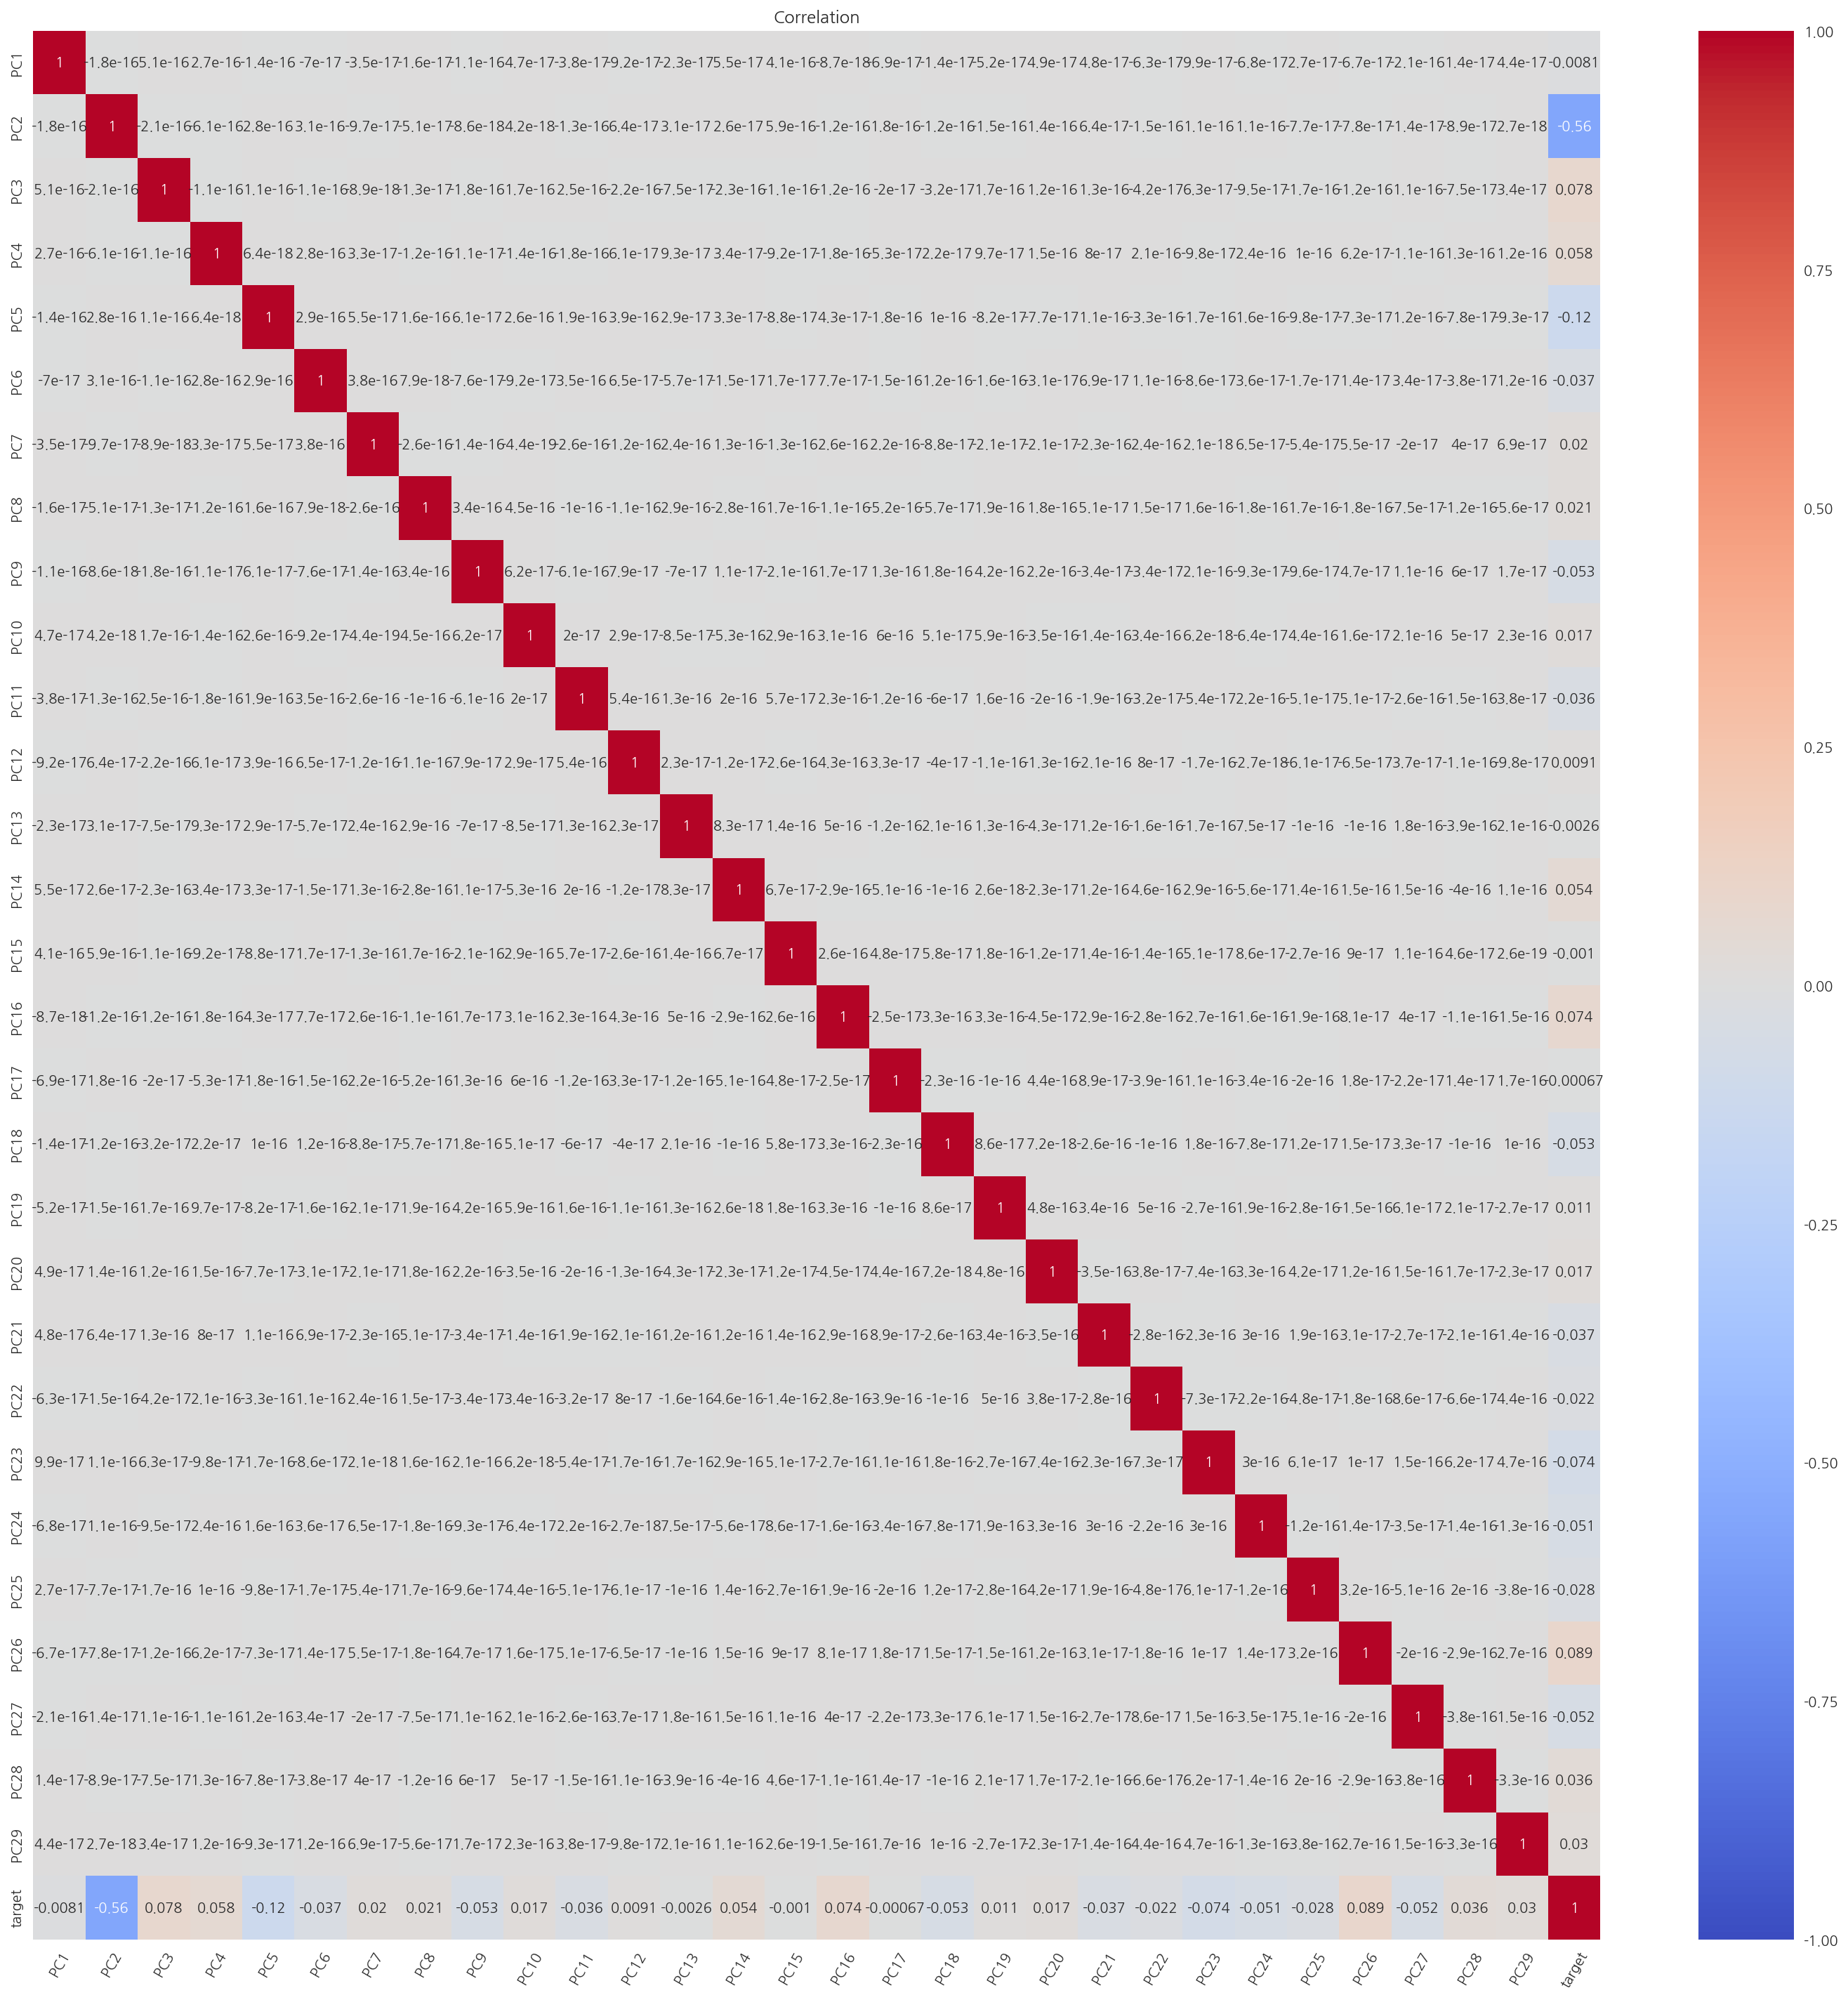

In [280]:
# # # 피쳐 선택
# # variables = ['transaction_real_price', 'exclusive_use_area', 'floor', 'adjusted_year_of_completion', 'lat', 'long', 'park_min', 'kind_min',
# #              'subway_min', 'elem_min']

# # 상관관계 행렬 계산
# corr = df_corr.corr()

# # Heatmap으로 시각화
# plt.figure(figsize=(25, 25))
# sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation')
# plt.xticks(rotation=60)  # x 축 눈금값을 45도 기울임

# plt.show()

In [281]:
corr['PC1']

PC1       1.0000e+00
PC2      -1.8463e-16
PC3       5.1253e-16
PC4       2.6550e-16
PC5      -1.4203e-16
PC6      -7.0434e-17
PC7      -3.4874e-17
PC8      -1.6060e-17
PC9      -1.1440e-16
PC10      4.7268e-17
PC11     -3.8432e-17
PC12     -9.2433e-17
PC13     -2.3460e-17
PC14      5.4970e-17
PC15      4.1273e-16
PC16     -8.7362e-18
PC17     -6.8971e-17
PC18     -1.3687e-17
PC19     -5.2116e-17
PC20      4.9458e-17
PC21      4.7758e-17
PC22     -6.2568e-17
PC23      9.8834e-17
PC24     -6.7625e-17
PC25      2.6896e-17
PC26     -6.7079e-17
PC27     -2.1371e-16
PC28      1.3579e-17
PC29      4.3738e-17
target   -8.1446e-03
Name: PC1, dtype: float64

In [282]:
corr['target']

PC1      -0.0081
PC2      -0.5559
PC3       0.0782
PC4       0.0576
PC5      -0.1228
PC6      -0.0366
PC7       0.0203
PC8       0.0214
PC9      -0.0527
PC10      0.0166
PC11     -0.0362
PC12      0.0091
PC13     -0.0026
PC14      0.0540
PC15     -0.0010
PC16      0.0738
PC17     -0.0007
PC18     -0.0525
PC19      0.0106
PC20      0.0166
PC21     -0.0373
PC22     -0.0219
PC23     -0.0744
PC24     -0.0512
PC25     -0.0283
PC26      0.0885
PC27     -0.0518
PC28      0.0363
PC29      0.0299
target    1.0000
Name: target, dtype: float64

In [283]:
corr['target'].sort_values(ascending = False)[1:].head(20)

PC26    0.0885
PC3     0.0782
PC16    0.0738
PC4     0.0576
PC14    0.0540
PC28    0.0363
PC29    0.0299
PC8     0.0214
PC7     0.0203
PC20    0.0166
PC10    0.0166
PC19    0.0106
PC12    0.0091
PC17   -0.0007
PC15   -0.0010
PC13   -0.0026
PC1    -0.0081
PC22   -0.0219
PC25   -0.0283
PC11   -0.0362
Name: target, dtype: float64

In [284]:
corr['target'].sort_values(ascending = False)[1:].tail(20)

PC20    0.0166
PC10    0.0166
PC19    0.0106
PC12    0.0091
PC17   -0.0007
PC15   -0.0010
PC13   -0.0026
PC1    -0.0081
PC22   -0.0219
PC25   -0.0283
PC11   -0.0362
PC6    -0.0366
PC21   -0.0373
PC24   -0.0512
PC27   -0.0518
PC18   -0.0525
PC9    -0.0527
PC23   -0.0744
PC5    -0.1228
PC2    -0.5559
Name: target, dtype: float64

### Test Set을 제외한 정규화 상호 정보 (Normalized Mutual Information, NMI)

100%|██████████| 30/30 [00:02<00:00, 12.10it/s]


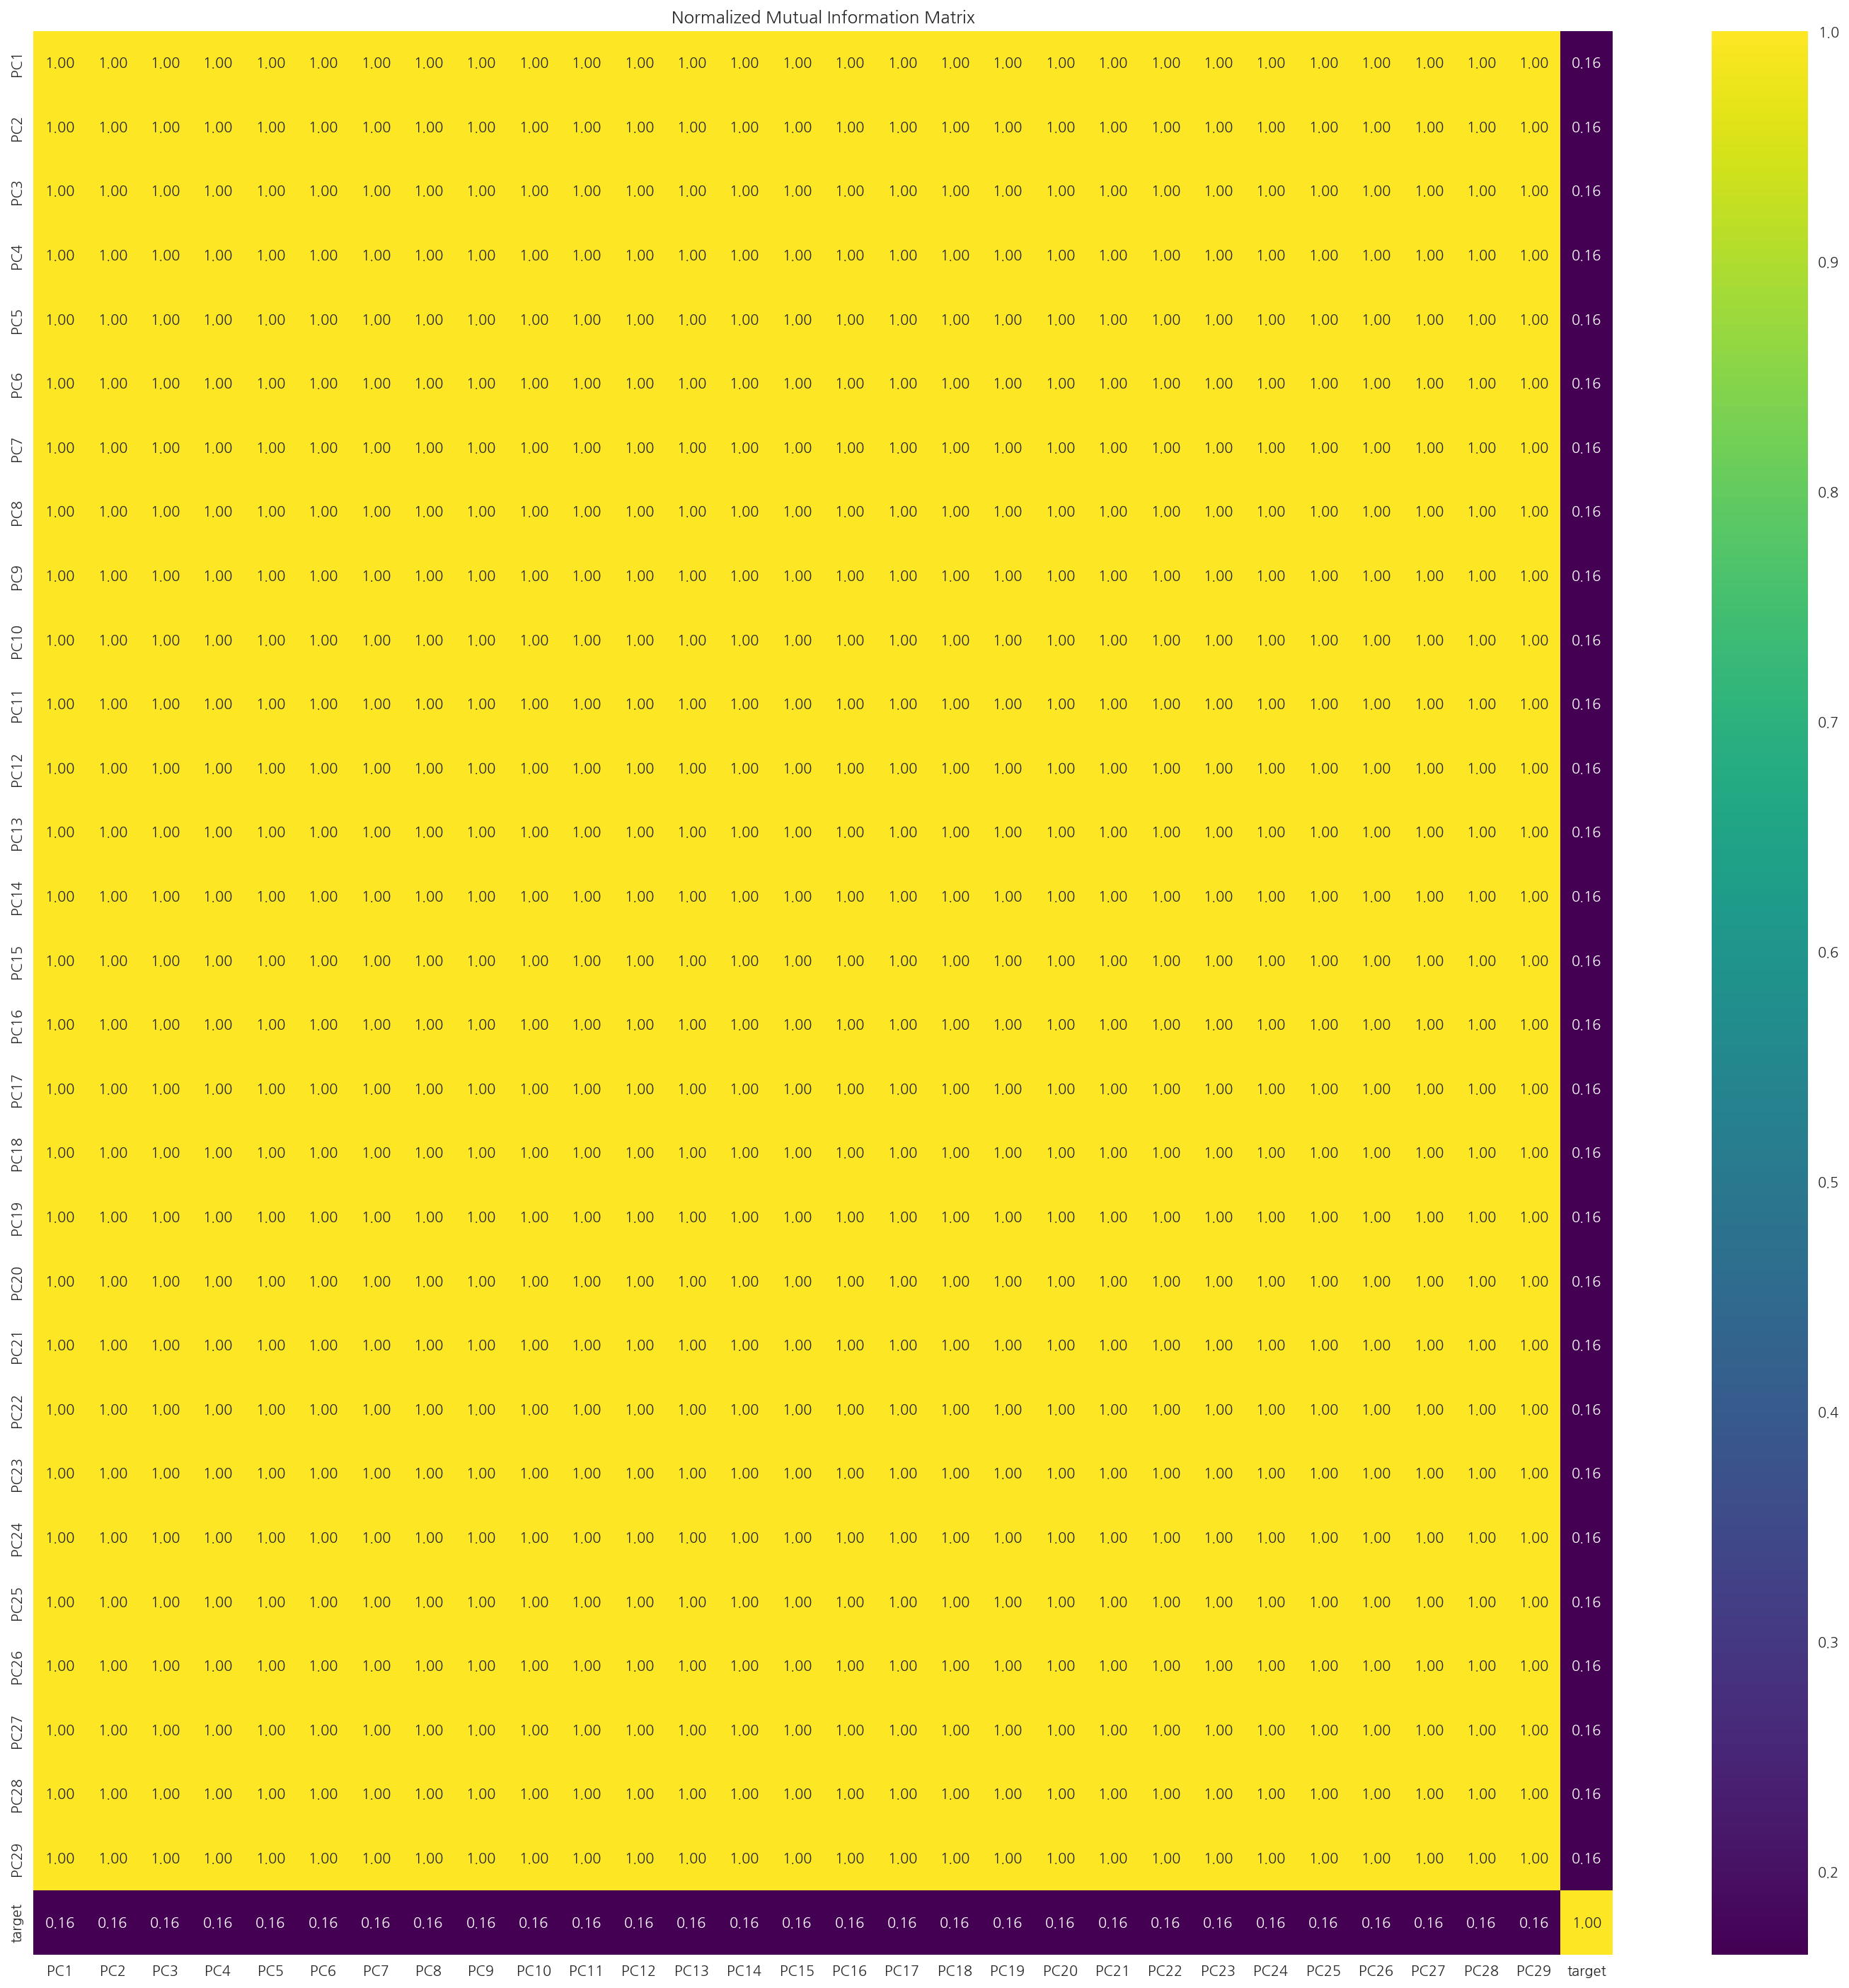

In [285]:
# from sklearn.metrics import normalized_mutual_info_score

# # 정규화 상호 정보 계산
# nmi_matrix = pd.DataFrame(index=df_corr.columns, columns=df_corr.columns)

# for col1 in tqdm(df_corr.columns):
#     for col2 in df_corr.columns:
#         nmi = normalized_mutual_info_score(df_corr[col1], df_corr[col2])
#         nmi_matrix.loc[col1, col2] = nmi

# nmi_matrix = nmi_matrix.astype(float)

# # 시각화
# plt.figure(figsize=(25, 25))
# sns.heatmap(nmi_matrix, annot=True, cmap='viridis', fmt=".2f")
# plt.title('Normalized Mutual Information Matrix')
# plt.show()

100%|██████████| 30/30 [00:00<00:00, 406.68it/s]


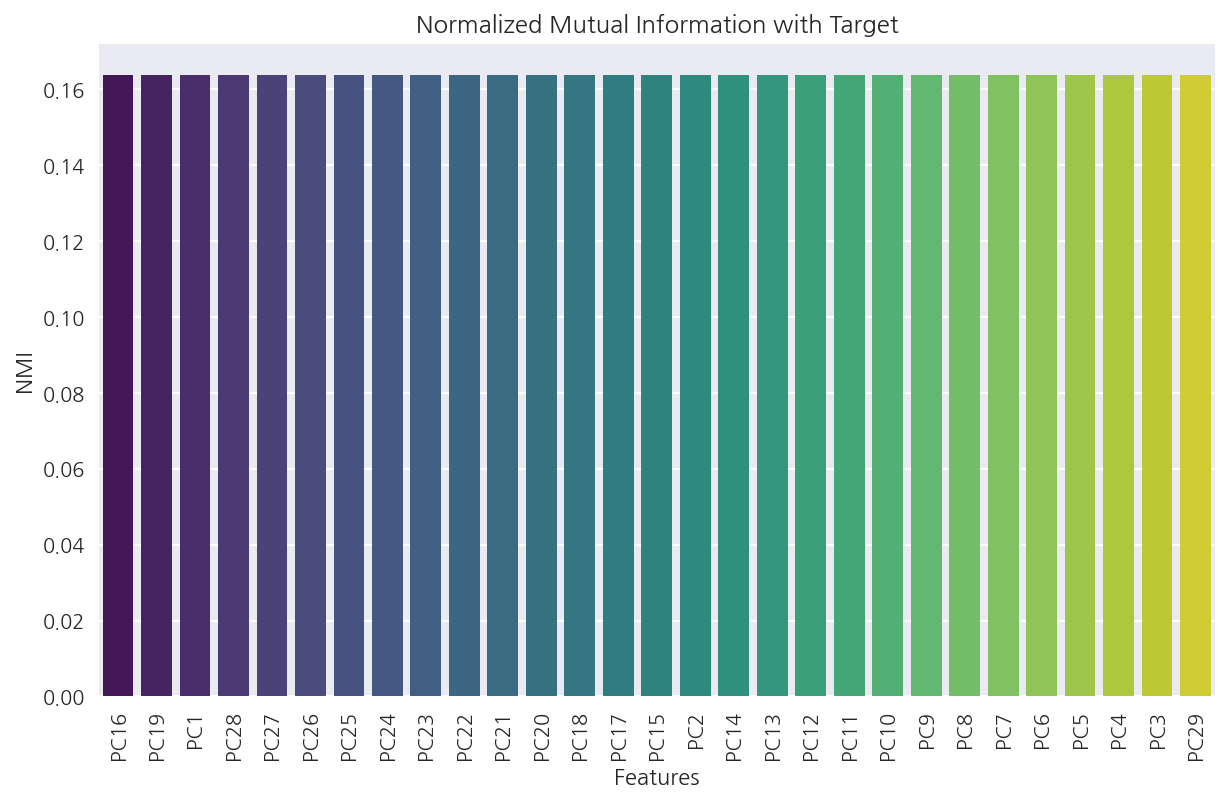

In [286]:
# # 'target' 컬럼과 나머지 변수 간의 정규화 상호 정보 계산
# nmi_values = {}

# target_col = 'target'
# for col in tqdm(df_corr.columns):
#     if col != target_col:
#         nmi = normalized_mutual_info_score(df_corr[target_col], df_corr[col])
#         nmi_values[col] = nmi

# # 데이터프레임으로 변환
# nmi_df = pd.DataFrame.from_dict(nmi_values, orient='index', columns=['NMI'])
# nmi_df.sort_values(by='NMI', ascending=False, inplace=True)

# # 시각화
# plt.figure(figsize=(10, 6))
# sns.barplot(x=nmi_df.index, y='NMI', data=nmi_df, palette='viridis')
# plt.title('Normalized Mutual Information with Target')
# plt.xlabel('Features')
# plt.ylabel('NMI')
# plt.xticks(rotation=90)
# plt.show()

## 변수 선택

In [287]:
pca_df_train.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28',
       'PC29', 'target'],
      dtype='object')

In [288]:
# 제거하고 싶은 피쳐
removed_features = []
# ['Open', 'High', 'Low', 'Close', 'Volume', 'MarCap', '매도_금융투자',
#        '매수_금융투자', '순매수_금융투자', '매도_보험', '매수_보험', '순매수_보험', '매도_투신', '매수_투신',
#        '순매수_투신', '매도_사모', '매수_사모', '순매수_사모', '매도_은행', '매수_은행', '순매수_은행',
#        '매도_기타금융', '매수_기타금융', '순매수_기타금융', '매도_연기금 등', '매수_연기금 등', '순매수_연기금 등',
#        '매도_기관합계', '매수_기관합계', '순매수_기관합계', '매도_기타법인', '매수_기타법인', '순매수_기타법인',
#        '매도_개인', '매수_개인', '순매수_개인', '순매수_외국인', '매도_기타외국인',
#        '매수_기타외국인', '순매수_기타외국인', '매도_전체', '매수_전체'] 

In [289]:
train_data_ = pca_df_train.copy()
train_data_ = train_data_.drop(columns=removed_features)
train_data_['target'] = train_data_['target'].apply(lambda x: 1 if x > 0 else 0)
train_data_

PC1     PC2     PC3     PC4     PC5     PC6     PC7     PC8  \
Date                                                                         
2014-03-07 -5.0596 -2.4234  0.4690  0.1449  1.8859  1.9046 -0.4365 -1.0856   
2014-03-10 -5.1613 -1.0602  0.7927 -0.6827  1.8198  0.8899  0.4819  0.5227   
2014-03-11 -4.9879 -1.8811  0.7761 -0.0372  1.3463  0.3150  0.7651  0.4451   
2014-03-12 -3.5228 -0.1424  2.9499 -1.3191  2.7963  1.1641  0.8083  0.1434   
2014-03-13 -4.5313  0.1361  1.6866 -0.0385  2.4416  0.8226  1.2614  0.5787   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2023-04-24  5.4885 -0.8053  0.9591 -2.8212  0.5913 -1.6306  0.8218  0.6962   
2023-04-25  5.5777  1.3326  0.7666 -1.6421  0.8649  0.1501  1.7025  0.4533   
2023-04-26  5.6420  1.2860  1.3736 -2.2754  1.5539 -1.6839  1.4372 -0.0476   
2023-04-27  4.0746  1.4349 -0.3111 -1.9745 -1.1119  0.5445  0.7451 -0.0071   
2023-04-28  4.6227  1.3363 -0.7750 -0.5423  0.6475  1.1955  0.1224  0.2892   

               PC9    PC10  ...    PC21    PC22    PC23    PC24    PC25  \
Date                        ...                                           
2014-03-07  0.1033  1.0950  ...  0.2636 -0.1076 -0.6388 -0.2464 -0.4356   
2014-03-10 -0.3089 -0.7115  ...  0.2932 -0.3348 -1.0198 -0.4995 -0.0708   
2014-03-11 -0.4036 -0.3406  ...  0.4719 -0.5094 -1.1124 -0.1664 -0.1706   
2014-03-12  0.3730 -2.3215  ...  0.4539  0.2890 -0.8932 -0.0082  0.1569   
2014-03-13 -0.3810 -0.8770  ...  0.8475 -0.1449 -0.8067 -0.1198  0.0288   
...            ...     ...  ...     ...     ...     ...     ...     ...   
2023-04-24 -0.7730 -1.0944  ...  0.3424 -0.3338  0.0929 -0.4886 -0.4900   
2023-04-25 -1.1448 -1.4256  ... -1.0086  0.1774 -0.2245  0.2390  0.0529   
2023-04-26 -1.1324 -0.4742  ... -0.6771 -0.5247 -0.0936  0.3245  0.0042   
2023-04-27 -0.8436  0.2119  ... -1.4687 -0.1554 -0.0474  0.7200  0.0889   
2023-04-28 -0.7579 -0.0096  ... -1.1417 -0.7532  0.0740  0.0737  0.1164   

              PC26    PC27    PC28    PC29  target  
Date                                                
2014-03-07 -0.1642 -1.4481 -0.3489 -0.9346       0  
2014-03-10 -0.5035 -0.3900 -0.4997 -0.5709       0  
2014-03-11 -0.3135  0.0062  0.4763 -0.5488       0  
2014-03-12 -0.2317 -0.5681 -0.4379 -1.2077       0  
2014-03-13 -0.9484  0.4481  0.0341 -0.7493       0  
...            ...     ...     ...     ...     ...  
2023-04-24 -1.3747  0.6203 -0.2389  0.0067       0  
2023-04-25 -1.0237  0.6641 -0.8644 -0.3904       0  
2023-04-26 -1.3158  1.0377 -0.9532  0.3562       0  
2023-04-27 -0.8035  0.0507 -0.1473  0.0563       0  
2023-04-28 -0.3454  0.6324 -0.3561 -0.1801       0  

[2252 rows x 30 columns]

In [290]:
test_data_ = pca_df_test.copy()
test_data_ = test_data_.drop(columns=removed_features)
test_data_['target'] = test_data_['target'].apply(lambda x: 1 if x > 0 else 0)
test_data_

PC1     PC2     PC3     PC4     PC5     PC6     PC7     PC8  \
Date                                                                         
2023-05-02  0.8316 -1.3828  1.7376  0.7237  2.6655 -0.7067 -0.8135  0.1673   
2023-05-03  2.2191 -0.2783  4.3859 -2.4959  2.4281 -2.8316 -0.5756  0.4295   
2023-05-04  0.7980 -0.0168  4.8581 -1.7685  2.6002 -1.3295  0.0904  1.5067   
2023-05-08 -0.9947 -0.2682  0.8478  1.2583  3.1139 -0.8084  0.2751  1.1421   
2023-05-09  0.1068 -0.1751  2.4956 -0.4685  3.3390 -2.6863 -0.3280  0.1810   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2024-04-29  1.0841  0.8251 -4.1726  2.7005 -0.3138 -1.1647  0.3580 -1.3131   
2024-04-30  1.8089  0.3820 -3.3966  0.7521 -1.2428 -0.0285 -0.6939 -0.3916   
2024-05-02 -0.4886  0.9145 -4.0644 -1.2558 -2.5767 -0.1223 -1.6466 -0.8692   
2024-05-03 -1.0128  0.2393 -4.8013 -0.8466 -2.0454  0.2396 -1.7025 -0.6100   
2024-05-07  3.1156 -2.2052 -4.3959  3.3845 -0.8624 -0.3889  0.2121 -0.2562   

               PC9    PC10  ...    PC21    PC22    PC23    PC24    PC25  \
Date                        ...                                           
2023-05-02 -2.6274  2.0348  ... -1.6489 -1.1858  1.8250 -1.0212 -0.1015   
2023-05-03 -1.3469  1.7870  ... -0.4613 -0.9036  3.0847 -0.3706  0.1509   
2023-05-04 -1.4573  2.2026  ...  0.9599 -0.7985  0.8868  3.5620 -0.3061   
2023-05-08 -1.4596  2.2886  ...  0.0874 -0.3848  2.1933 -0.5787 -0.5199   
2023-05-09 -1.3241  1.9360  ... -0.1513 -0.7612  1.4935  0.5533 -0.4046   
...            ...     ...  ...     ...     ...     ...     ...     ...   
2024-04-29  0.6919  0.9131  ...  0.6310  0.2456 -1.2693  0.6109 -0.9336   
2024-04-30  1.2296 -0.6598  ...  0.9344 -1.0050 -0.5682 -0.4815 -1.3823   
2024-05-02  1.4235 -0.8094  ... -0.0428 -0.3502 -0.9534 -0.3459 -1.2238   
2024-05-03  1.5780 -0.1131  ... -0.2637 -0.3222 -0.8585 -0.5403 -1.4310   
2024-05-07 -0.1847 -0.0105  ...  0.8145 -0.4507 -1.3498  0.3307 -1.4686   

              PC26    PC27    PC28    PC29  target  
Date                                                
2023-05-02  0.8813  0.5266  0.5964  0.1781       0  
2023-05-03  1.6663  0.1926 -0.1029  0.1387       0  
2023-05-04  1.0465  0.1452  0.6295  1.8452       0  
2023-05-08  1.2418  0.7808  0.1922  0.1267       0  
2023-05-09  0.3386  0.2223 -0.3539 -0.4834       0  
...            ...     ...     ...     ...     ...  
2024-04-29  0.0122  0.1841  0.1087 -0.8027       1  
2024-04-30  0.1548  0.4317 -0.5242 -0.4333       1  
2024-05-02 -0.0128 -0.8915  0.6839 -1.2589       1  
2024-05-03 -0.0189 -0.6742  0.1675 -1.4355       1  
2024-05-07 -0.0824  0.0961 -0.0145 -0.0133       1  

[248 rows x 30 columns]

## 2. 시퀀스 데이터 생성

### 학습 및 검증 데이터와 테스트 데이터로 분할

In [291]:
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequence = data.iloc[i:i + sequence_length].drop(columns=['target']).values
        
        # 다음날 추세 label 예측
        #label = data.iloc[i + sequence_length]['target']
        
        # 현재 시점 추세 label 예측
        label = data.iloc[i + sequence_length - 1]['target']
        
        sequences.append(sequence)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)

In [292]:
sequence_length = 20  # 시퀀스 길이

# 학습 및 검증 데이터 시퀀스 생성
train_val_sequences = []
train_val_labels = []

X_train_val, y_train_val = create_sequences(train_data_, sequence_length)

In [293]:
X_train_val.shape, y_train_val.shape

((2232, 20, 29), (2232,))

In [294]:
X_test, y_test = create_sequences(test_data_, sequence_length)
X_test.shape, y_test.shape

((228, 20, 29), (228,))

In [295]:
train_val_split = int(len(X_train_val)*0.8)
train_val_split

1785

In [296]:
y_train_val_int = y_train_val[:train_val_split].astype(int)
y_test_int = y_test.astype(int)

In [297]:
# 학습 데이터 0 / 1 비율
np.bincount(y_train_val_int)

array([ 709, 1076])

In [298]:
# 테스트 데이터 0 / 1 비율
np.bincount(y_test_int)

array([ 99, 129])

## 3. LSTM 모델 구성 및 학습

In [299]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.ensemble import BaggingClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1, l2
from tensorflow.keras import callbacks
import random
#from scikeras.wrappers import KerasClassifier 오류 발생 (optree)

## 실험

In [300]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'

In [301]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [302]:
def cw(df):
    c0, c1 = np.bincount(df.astype(int))
    w0 = (1 / c0) * (len(df)) / 2
    w1 = (1 / c1) * (len(df)) / 2
    return {0: w0, 1: w1}

In [303]:
optimizer = Adam(learning_rate=0.001)

In [304]:
from tensorflow.keras.layers import Layer, BatchNormalization
from tensorflow.keras.initializers import GlorotUniform, HeNormal, Orthogonal, HeUniform
from tensorflow.keras import backend as K

In [305]:
class InstanceNormalization(Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma',
                                     shape=(input_shape[-1],),
                                     initializer='ones',
                                     trainable=True)
        self.beta = self.add_weight(name='beta',
                                    shape=(input_shape[-1],),
                                    initializer='zeros',
                                    trainable=True)
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1], keepdims=True)
        normalized = (inputs - mean) / (K.sqrt(variance + self.epsilon))
        return self.gamma * normalized + self.beta

    def compute_output_shape(self, input_shape):
        return input_shape

In [306]:
def create_deep_rnn_model(layer='SimpleRNN', optimizer='adam', features=1):
    
    if layer == 'SimpleRNN':
        layer = SimpleRNN
    else:
        layer = LSTM
        
    model = Sequential()
    model.add(Input(shape=(sequence_length, features)))
    model.add(InstanceNormalization())
    model.add(layer(units=64, return_sequences=True, kernel_initializer=Orthogonal(gain=1.0)))
    model.add(InstanceNormalization())
    model.add(Dropout(0.5))
#     model.add(layer(units=64, return_sequences=True, kernel_initializer=Orthogonal(gain=1.0)))
#     model.add(InstanceNormalization())
#     model.add(Dropout(0.5))
    model.add(layer(units=32, return_sequences=False, kernel_initializer=Orthogonal(gain=1.0)))
    model.add(InstanceNormalization())
    model.add(Dropout(0.2))
#     model.add(Dense(units=32, activation='relu', kernel_initializer=HeUniform()))
#     model.add(BatchNormalization())
    model.add(Dense(units=16, activation='relu', kernel_initializer=HeUniform()))
    model.add(BatchNormalization())
    model.add(Dense(units=8, activation='relu', kernel_initializer=HeUniform()))
    model.add(BatchNormalization())
    model.add(Dense(units=4, activation='relu', kernel_initializer=HeUniform()))
    model.add(BatchNormalization())
    model.add(Dense(units=1, activation='sigmoid', kernel_initializer=GlorotUniform()))
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', 
                  metrics=['binary_accuracy', AUC()])
    return model

In [307]:
# TimeSeriesSplit 설정
tscv = TimeSeriesSplit(n_splits=9)

# 교차 검증 결과를 저장할 리스트
results = []

# 교차 검증
for i, (train_index, test_index) in enumerate(tscv.split(X_train_val)):
    X_train_cv, X_test_cv = X_train_val[train_index], X_train_val[test_index]
    y_train_cv, y_test_cv = y_train_val[train_index], y_train_val[test_index]
    
    set_seeds()
    #early_stopping_cb = callbacks.EarlyStopping(patience=10, monitor='binary_accuracy', restore_best_weights=True)
    
    model = create_deep_rnn_model(layer='LSTM', optimizer='adam', features=X_train_val.shape[2])
    model.fit(X_train_cv, y_train_cv, epochs=10, batch_size=16, verbose=1)#, class_weight=cw(y_train_cv)) #, callbacks=[early_stopping_cb])
    
    # 모델 평가
    loss = model.evaluate(X_test_cv, y_test_cv, verbose=1)
    results.append(loss[-2:])
    print(f'{i+1}-fold Test Accuracy | AUC: {loss[-2:]}')

Epoch 1/10
15/15 [==============================] - 4s 10ms/step - loss: 0.8830 - binary_accuracy: 0.4311 - auc_56: 0.4373
Epoch 2/10
15/15 [==============================] - 0s 10ms/step - loss: 0.6488 - binary_accuracy: 0.6000 - auc_56: 0.6706
Epoch 3/10
15/15 [==============================] - 0s 10ms/step - loss: 0.6543 - binary_accuracy: 0.6178 - auc_56: 0.6624
Epoch 4/10
15/15 [==============================] - 0s 11ms/step - loss: 0.5864 - binary_accuracy: 0.6844 - auc_56: 0.7533
Epoch 5/10
15/15 [==============================] - 0s 11ms/step - loss: 0.5495 - binary_accuracy: 0.7111 - auc_56: 0.7940
Epoch 6/10
15/15 [==============================] - 0s 9ms/step - loss: 0.5486 - binary_accuracy: 0.6933 - auc_56: 0.8140
Epoch 7/10
15/15 [==============================] - 0s 9ms/step - loss: 0.4926 - binary_accuracy: 0.7822 - auc_56: 0.8815
Epoch 8/10
15/15 [==============================] - 0s 9ms/step - loss: 0.4820 - binary_accuracy: 0.7733 - auc_56: 0.8948
Epoch 9/10
15/15 [=

In [308]:
results

[[0.6322869658470154, 0.6399211287498474],
 [0.6412556171417236, 0.6686992049217224],
 [0.695067286491394, 0.536838948726654],
 [0.573991060256958, 0.5836529731750488],
 [0.6547085046768188, 0.6921008825302124],
 [0.6367713212966919, 0.5409538745880127],
 [0.834080696105957, 0.8311874866485596],
 [0.4932735562324524, 0.43595507740974426],
 [0.6008968353271484, 0.6632448434829712]]

In [309]:
val_mu = np.mean(results, axis=0)[0]
val_mu

0.6402590937084622

In [310]:
val_std = np.std(results, axis=0, ddof=1)[0]
val_std

0.09246745193370959

### 홀드아웃 샘플(Test Set)에 대한 예측 성능 평가 방식은 질문으로

In [311]:
set_seeds()
model = create_deep_rnn_model(layer='LSTM', optimizer='adam', features=X_train_val.shape[2])

model.fit(X_train_val, y_train_val, epochs=10, batch_size=16, verbose=1)#, class_weight=cw(y_train_val))

Epoch 1/10
140/140 [==============================] - 5s 9ms/step - loss: 0.7160 - binary_accuracy: 0.5694 - auc_65: 0.5941
Epoch 2/10
140/140 [==============================] - 1s 9ms/step - loss: 0.6066 - binary_accuracy: 0.6667 - auc_65: 0.7213
Epoch 3/10
140/140 [==============================] - 1s 10ms/step - loss: 0.5809 - binary_accuracy: 0.6864 - auc_65: 0.7464
Epoch 4/10
140/140 [==============================] - 1s 9ms/step - loss: 0.5593 - binary_accuracy: 0.7124 - auc_65: 0.7793
Epoch 5/10
140/140 [==============================] - 1s 9ms/step - loss: 0.5142 - binary_accuracy: 0.7594 - auc_65: 0.8261
Epoch 6/10
140/140 [==============================] - 1s 9ms/step - loss: 0.4785 - binary_accuracy: 0.7728 - auc_65: 0.8535
Epoch 7/10
140/140 [==============================] - 1s 9ms/step - loss: 0.4513 - binary_accuracy: 0.8002 - auc_65: 0.8686
Epoch 8/10
140/140 [==============================] - 1s 9ms/step - loss: 0.3965 - binary_accuracy: 0.8329 - auc_65: 0.9032
Epoch 9

In [312]:
evl = model.evaluate(X_test, y_test, verbose=1)
evl

8/8 [==============================] - 1s 5ms/step - loss: 1.2305 - binary_accuracy: 0.5351 - auc_65: 0.5251


[1.2305364608764648, 0.5350877046585083, 0.5250567197799683]

In [313]:
(evl[1] - val_mu) / val_std

-1.137388203638961

In [314]:
len(y_test)

228

In [315]:
test = df_test.iloc[-len(y_test):]
test['target'] = test['target'].apply(lambda x: 1 if x > 0 else 0)
backtest_df = pd.DataFrame(index=test.index)
backtest_df['p'] = model.predict(X_test)
backtest_df['p'] = (backtest_df['p'] > 0.5).astype(int)

In [316]:
# 예측값 비율
backtest_df['p'].value_counts()

1    157
0     71
Name: p, dtype: int64

In [317]:
# 실제 타겟값의 비율
test['target'].value_counts()

1    129
0     99
Name: target, dtype: int64

              precision    recall  f1-score   support

           0       0.44      0.31      0.36        99
           1       0.57      0.69      0.62       129

    accuracy                           0.53       228
   macro avg       0.50      0.50      0.49       228
weighted avg       0.51      0.53      0.51       228



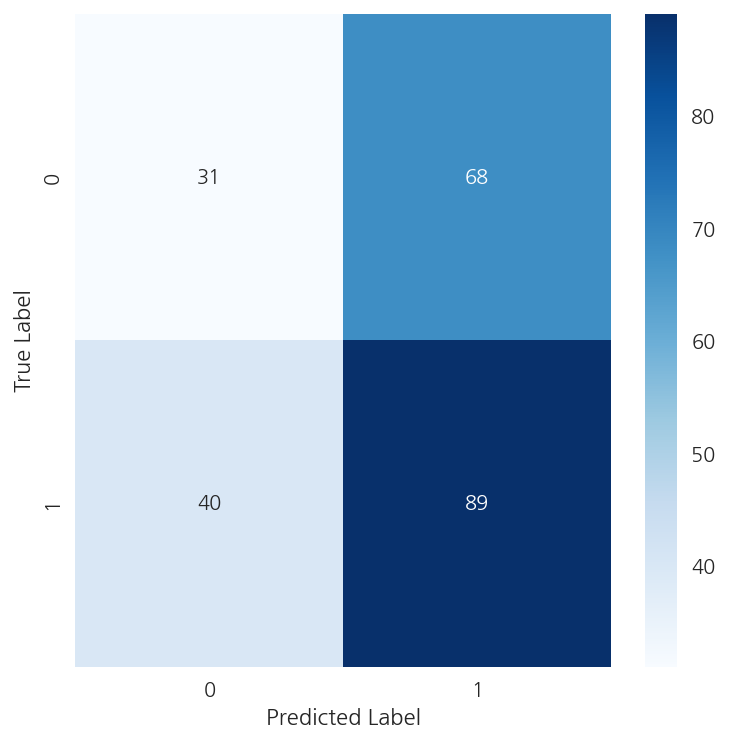

In [318]:
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. 분류 보고서 확인
print(classification_report(test['target'], backtest_df['p']))

# 2. 히트맵 시각화
plt.figure(figsize=(6, 6))
cm2 = confusion_matrix(test['target'], backtest_df['p'])
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 표본 외 경제적 성능 평가

In [319]:
# 매매 포지션 진입, 변경, 청산이 발생한 시점 횟수
sum(backtest_df['p'].diff() != 0) + 1

26

In [320]:
# 포지션 변경에 따른 증권사 수수료 / 거래세
pc = (0.00015 * 2  + 0.0018)

# 슬리피지 적용
sp = 0.001

In [321]:
backtest_df['p'] = np.where(backtest_df['p'] == 0, -1, 1)
backtest_df['r'] = df_test.loc[test.index]['r']
backtest_df['s'] = backtest_df['p'] * backtest_df['r']
backtest_df['s_'] = np.where(backtest_df['p'].diff() != 0,
                      backtest_df['s'] - pc - sp, backtest_df['s'])
backtest_df['s_'].iloc[0] -= pc
backtest_df['s_'].iloc[-1] -= pc
backtest_df

p           r           s          s_
Date                                             
2023-06-01  1 -3.0896e-03 -3.0896e-03 -8.2896e-03
2023-06-02  1  1.2451e-02  1.2451e-02  1.2451e-02
2023-06-05  1  5.3865e-03  5.3865e-03  5.3865e-03
2023-06-07  1  7.2644e-05  7.2644e-05  7.2644e-05
2023-06-08  1 -1.8177e-03 -1.8177e-03 -1.8177e-03
...        ..         ...         ...         ...
2024-04-29  1  1.1644e-02  1.1644e-02  1.1644e-02
2024-04-30 -1  1.7176e-03 -1.7176e-03 -4.8176e-03
2024-05-02 -1 -3.1289e-03  3.1289e-03  3.1289e-03
2024-05-03 -1 -2.6193e-03  2.6193e-03  2.6193e-03
2024-05-07  1  2.1339e-02  2.1339e-02  1.6139e-02

[228 rows x 4 columns]

In [322]:
backtest_df[['r', 's', 's_']].sum().apply(np.exp)

r     1.0610
s     0.8152
s_    0.7513
dtype: float64

In [323]:
backtest_df[['r', 's', 's_']].sum().apply(np.exp) - 1

r     0.0610
s    -0.1848
s_   -0.2487
dtype: float64

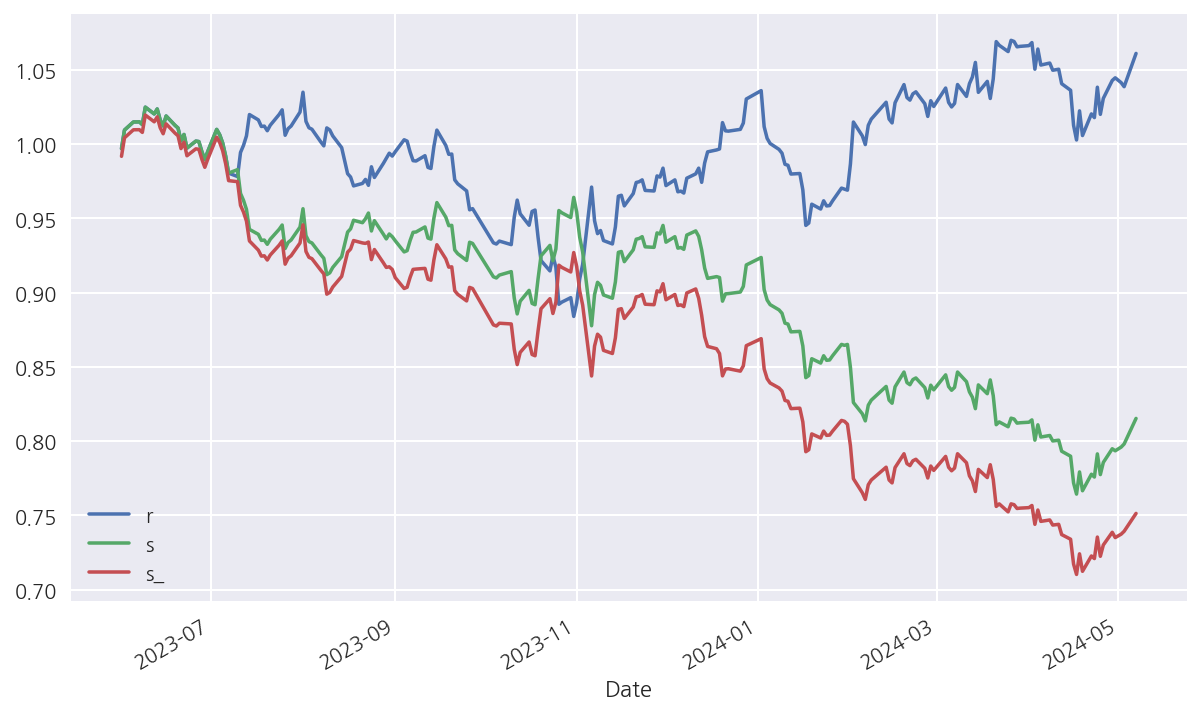

In [324]:
backtest_df[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6));

### 예측 추세

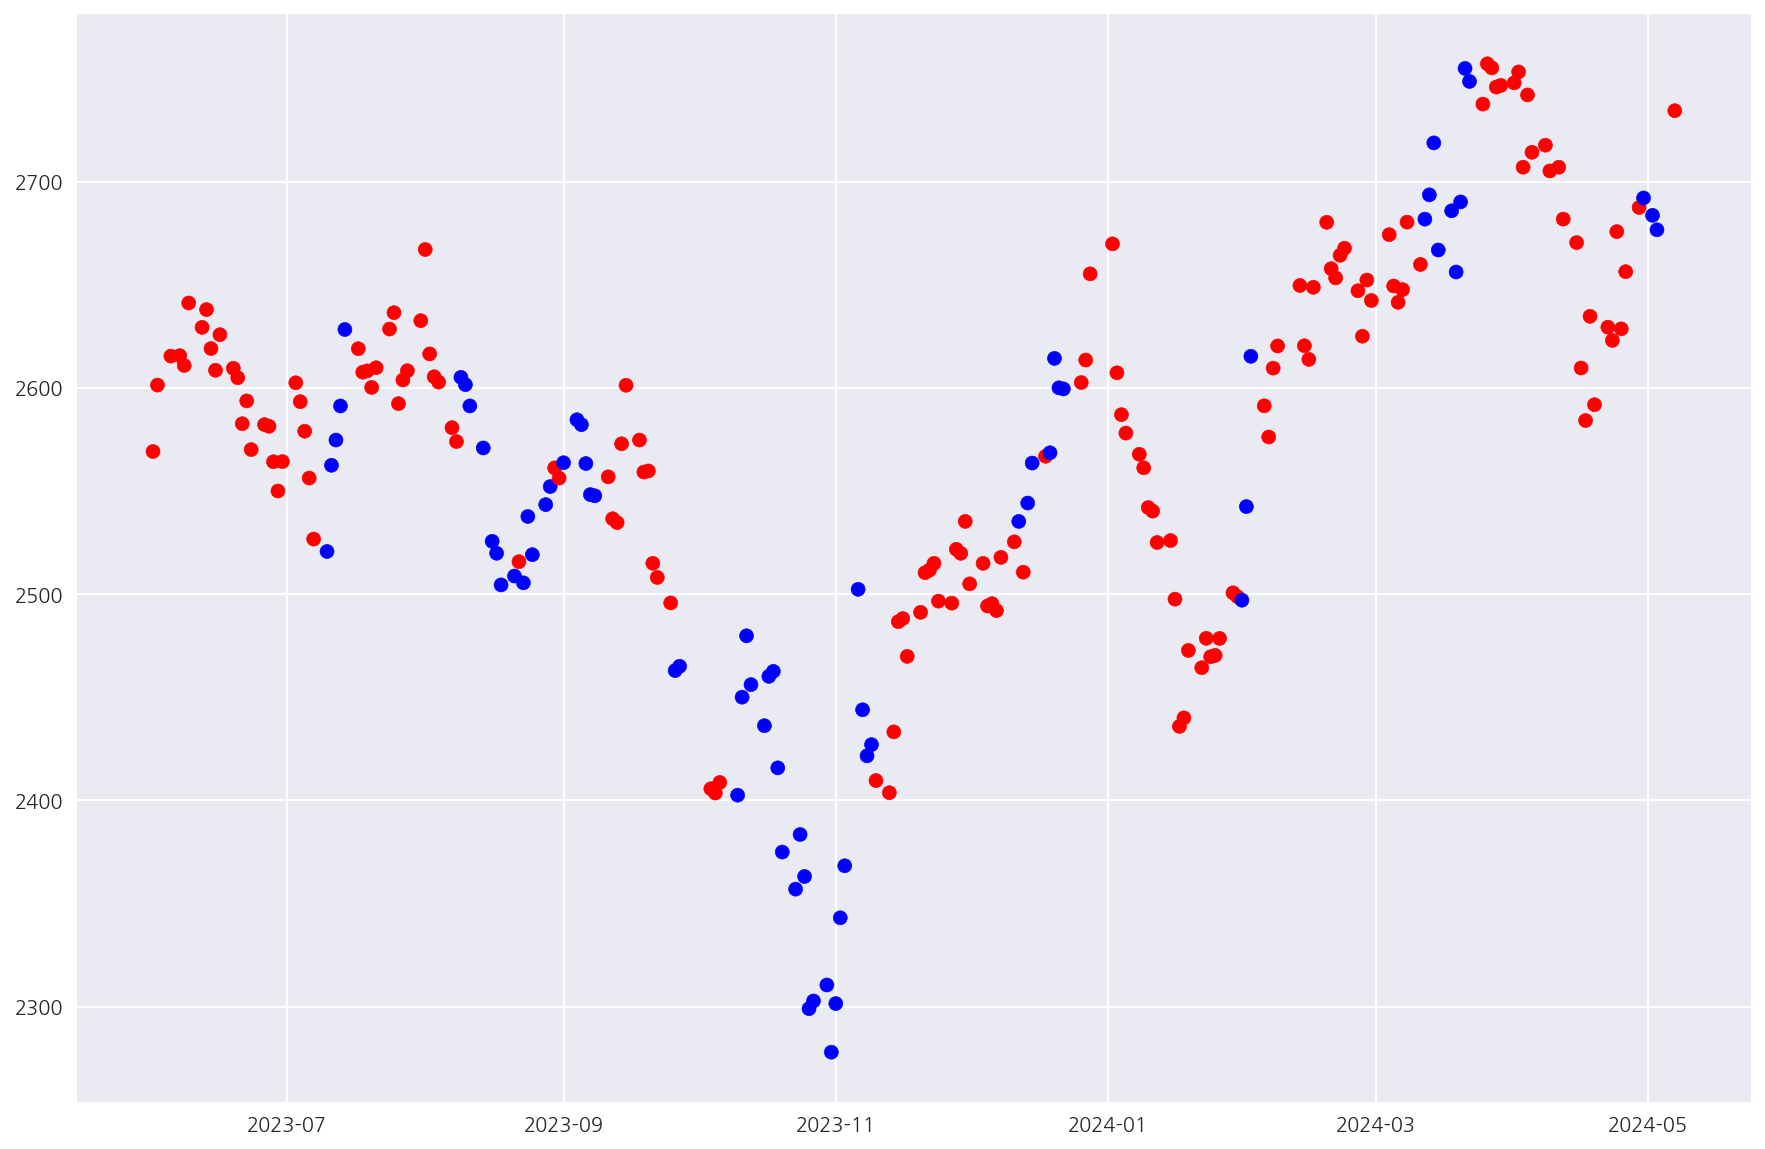

In [325]:
sub_data = df_test['Close'].loc[backtest_df['p'].index]
c_sig = backtest_df['p']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

### 실제 추세

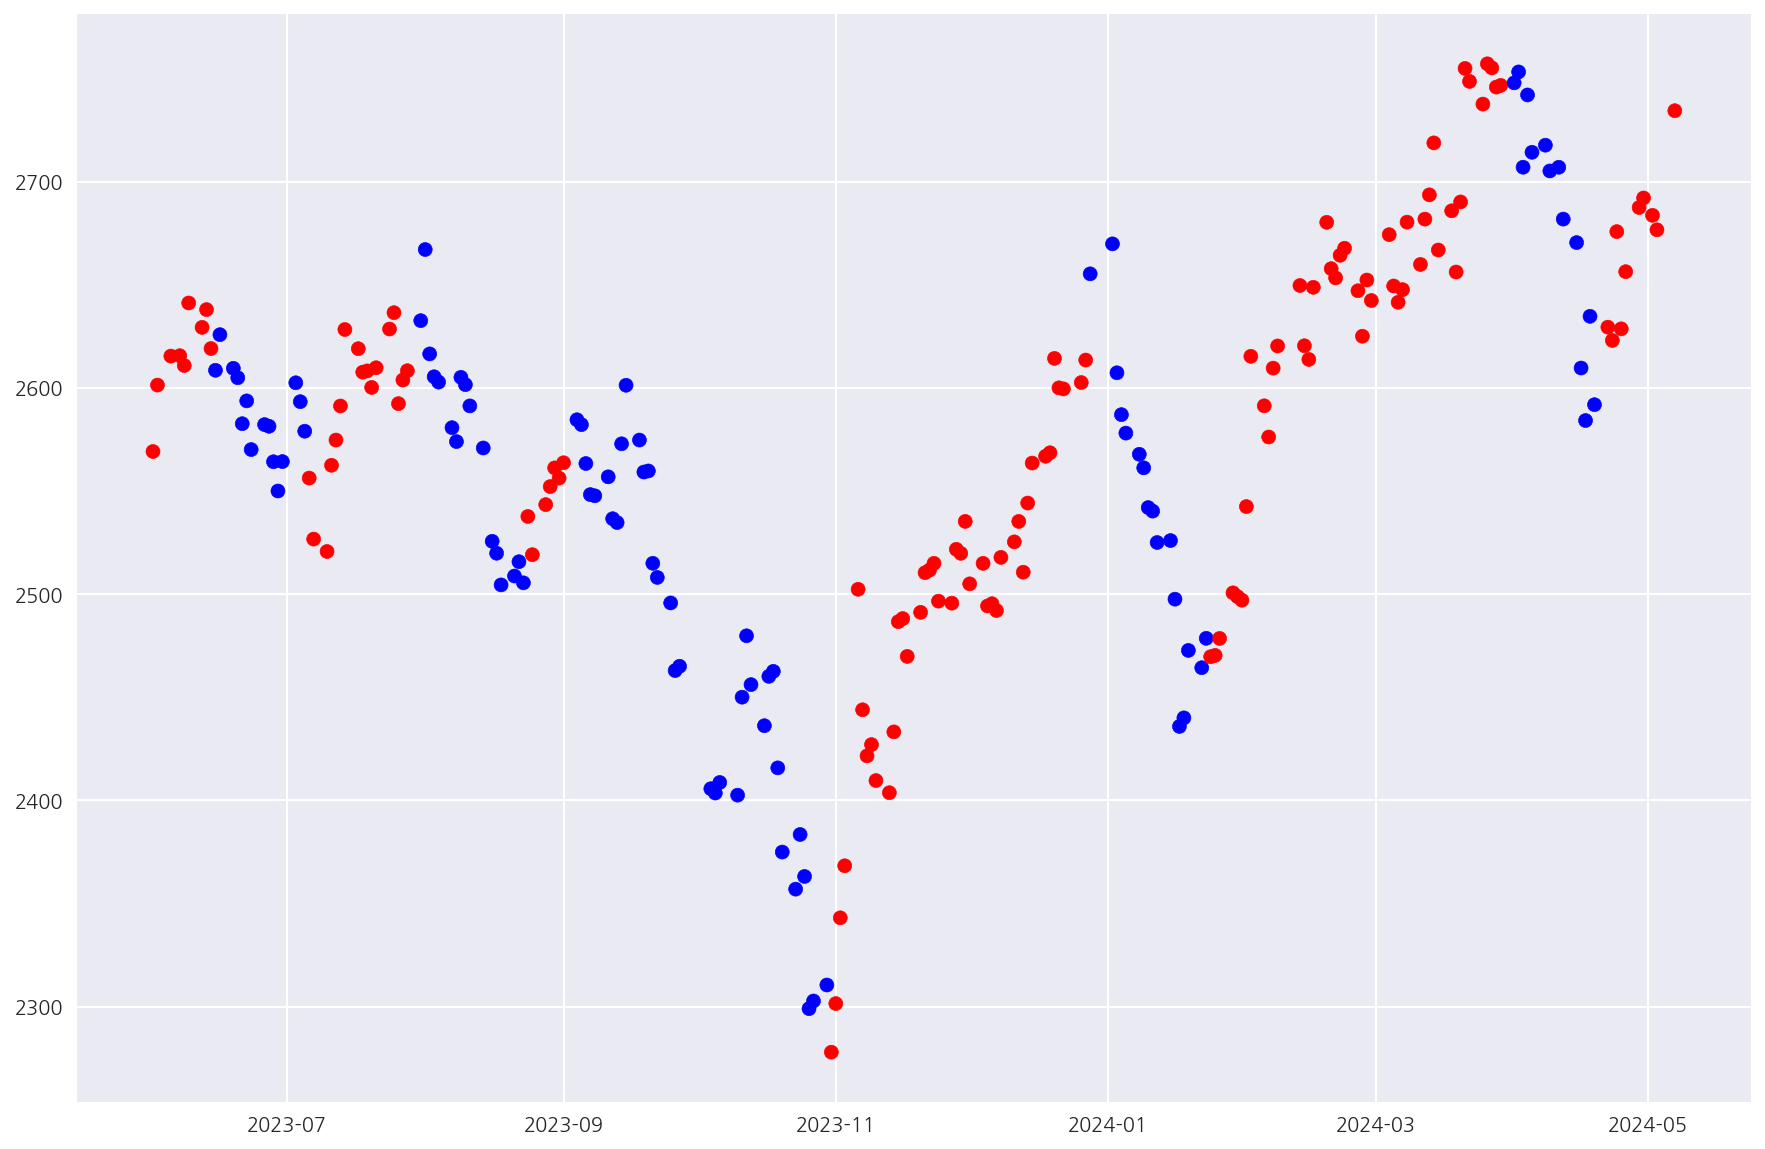

In [326]:
sub_data = df_test['Close'].loc[backtest_df['p'].index]
c_sig = df_test['target'].loc[backtest_df['p'].index]
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

### 메모
1. epoch 15 / 20 / 25 에 따라 성능이 달라진다.

### Blocked Cross Validation

In [327]:
def block_cross_validation(X, y, n_blocks):
    
    block_size = len(X) // n_blocks
    results = []

    for i in range(n_blocks):
        test_index = np.arange(i * block_size, (i + 1) * block_size)
        train_index = np.setdiff1d(np.arange(len(X)), test_index)
        
        X_train_cv, X_test_cv = X[train_index], X[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]

        set_seeds()
        model = create_deep_rnn_model(layer='LSTM', optimizer='adam', features=X_train_val.shape[2])
        model.fit(X_train_cv, y_train_cv, epochs=10, batch_size=16, verbose=1)#, class_weight=cw(y_train_cv)) #, callbacks=[early_stopping_cb])
        
        # 모델 평가
        loss = model.evaluate(X_test_cv, y_test_cv, verbose=1)
        results.append(loss[-2:])
        
        print(f'Block {i+1} Test Accuracy : {loss[-2:]}')

    return results, block_size

n_blocks = 9
results, block_size = block_cross_validation(X_train_val, y_train_val, n_blocks)

Epoch 1/10
124/124 [==============================] - 4s 7ms/step - loss: 0.7143 - binary_accuracy: 0.5665 - auc_66: 0.6037
Epoch 2/10
124/124 [==============================] - 1s 7ms/step - loss: 0.6296 - binary_accuracy: 0.6336 - auc_66: 0.6849
Epoch 3/10
124/124 [==============================] - 1s 8ms/step - loss: 0.5987 - binary_accuracy: 0.6689 - auc_66: 0.7271
Epoch 4/10
124/124 [==============================] - 1s 8ms/step - loss: 0.5616 - binary_accuracy: 0.7213 - auc_66: 0.7805
Epoch 5/10
124/124 [==============================] - 1s 8ms/step - loss: 0.5364 - binary_accuracy: 0.7414 - auc_66: 0.8062
Epoch 6/10
124/124 [==============================] - 1s 7ms/step - loss: 0.4836 - binary_accuracy: 0.7747 - auc_66: 0.8500
Epoch 7/10
124/124 [==============================] - 1s 7ms/step - loss: 0.4527 - binary_accuracy: 0.8024 - auc_66: 0.8666
Epoch 8/10
124/124 [==============================] - 1s 7ms/step - loss: 0.4024 - binary_accuracy: 0.8276 - auc_66: 0.8988
Epoch 9/

In [328]:
results

[[0.6854838728904724, 0.755827009677887],
 [0.5685483813285828, 0.667046308517456],
 [0.6290322542190552, 0.6116515398025513],
 [0.6048387289047241, 0.608769416809082],
 [0.5725806355476379, 0.6290837526321411],
 [0.7217742204666138, 0.8007416129112244],
 [0.7338709831237793, 0.8273241519927979],
 [0.5483871102333069, 0.5614560842514038],
 [0.5, 0.5712316036224365]]

In [329]:
val_mu = np.mean(results, axis=0)[0]
val_mu

0.6182795763015747

In [330]:
val_std = np.std(results, axis=0, ddof=1)[0]
val_std

0.08087166420152445

### 홀드아웃 샘플(Test Set)에 대한 예측 성능 평가 방식은 질문으로

In [331]:
X_blocked = X_train_val[-block_size:]
y_blocked = y_train_val[-block_size:]

In [332]:
X_blocked.shape, y_blocked.shape

((248, 20, 29), (248,))

In [333]:
set_seeds()
model = create_deep_rnn_model(layer='LSTM', optimizer='adam', features=X_train_val.shape[2])

model.fit(X_blocked, y_blocked, epochs=10, batch_size=16, verbose=1)#, class_weight=cw(y_train_val))

Epoch 1/10
16/16 [==============================] - 4s 9ms/step - loss: 0.7692 - binary_accuracy: 0.5524 - auc_75: 0.5132
Epoch 2/10
16/16 [==============================] - 0s 10ms/step - loss: 0.6426 - binary_accuracy: 0.6250 - auc_75: 0.6787
Epoch 3/10
16/16 [==============================] - 0s 10ms/step - loss: 0.5602 - binary_accuracy: 0.7137 - auc_75: 0.7626
Epoch 4/10
16/16 [==============================] - 0s 9ms/step - loss: 0.5258 - binary_accuracy: 0.7500 - auc_75: 0.8169
Epoch 5/10
16/16 [==============================] - 0s 10ms/step - loss: 0.4718 - binary_accuracy: 0.7863 - auc_75: 0.8689
Epoch 6/10
16/16 [==============================] - 0s 9ms/step - loss: 0.4798 - binary_accuracy: 0.7621 - auc_75: 0.8547
Epoch 7/10
16/16 [==============================] - 0s 9ms/step - loss: 0.4197 - binary_accuracy: 0.8347 - auc_75: 0.9160
Epoch 8/10
16/16 [==============================] - 0s 9ms/step - loss: 0.4259 - binary_accuracy: 0.8347 - auc_75: 0.9133
Epoch 9/10
16/16 [===

In [334]:
evl = model.evaluate(X_test, y_test, verbose=1)
evl

8/8 [==============================] - 1s 5ms/step - loss: 0.9015 - binary_accuracy: 0.5000 - auc_75: 0.4610


[0.9014896154403687, 0.5, 0.4610445499420166]

In [335]:
(evl[1] - val_mu) / val_std

-1.46255895027501

In [336]:
len(y_test)

228

In [337]:
test = df_test.iloc[-len(y_test):]
test['target'] = test['target'].apply(lambda x: 1 if x > 0 else 0)
backtest_df = pd.DataFrame(index=test.index)
backtest_df['p'] = model.predict(X_test)
backtest_df['p'] = (backtest_df['p'] > 0.5).astype(int)

In [338]:
# 예측값 비율
backtest_df['p'].value_counts()

0    127
1    101
Name: p, dtype: int64

In [339]:
# 실제 타겟값의 비율
test['target'].value_counts()

1    129
0     99
Name: target, dtype: int64

              precision    recall  f1-score   support

           0       0.43      0.55      0.48        99
           1       0.55      0.43      0.49       129

    accuracy                           0.48       228
   macro avg       0.49      0.49      0.48       228
weighted avg       0.50      0.48      0.48       228



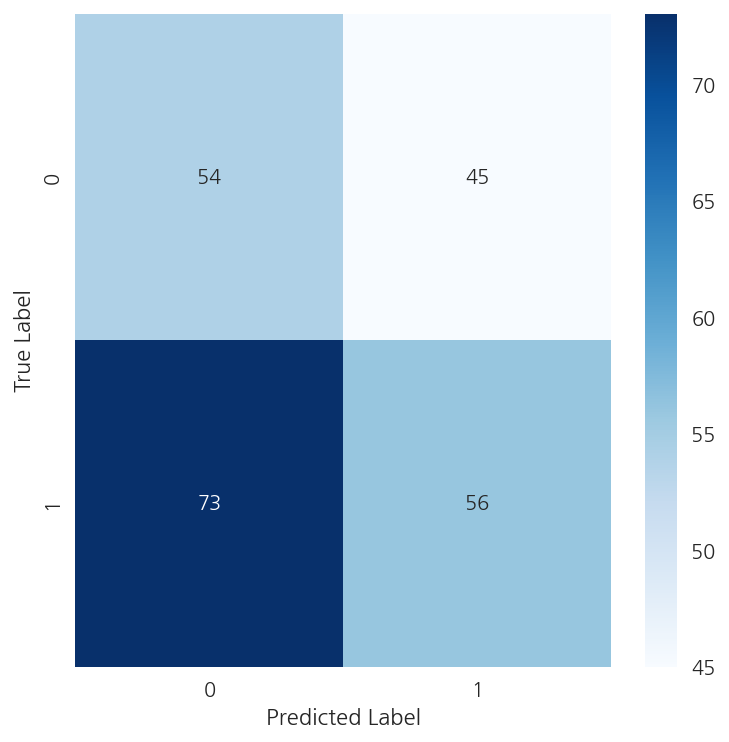

In [340]:
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. 분류 보고서 확인
print(classification_report(test['target'], backtest_df['p']))

# 2. 히트맵 시각화
plt.figure(figsize=(6, 6))
cm2 = confusion_matrix(test['target'], backtest_df['p'])
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 표본 외 경제적 성능 평가

In [341]:
# 매매 포지션 진입, 변경, 청산이 발생한 시점 횟수
sum(backtest_df['p'].diff() != 0) + 1

31

In [342]:
# 포지션 변경에 따른 증권사 수수료 / 거래세
pc = (0.00015 * 2  + 0.0018)

# 슬리피지 적용
sp = 0.001

In [343]:
backtest_df['p'] = np.where(backtest_df['p'] == 0, -1, 1)
backtest_df['r'] = df_test.loc[test.index]['r']
backtest_df['s'] = backtest_df['p'] * backtest_df['r']
backtest_df['s_'] = np.where(backtest_df['p'].diff() != 0,
                      backtest_df['s'] - pc - sp, backtest_df['s'])
backtest_df['s_'].iloc[0] -= pc
backtest_df['s_'].iloc[-1] -= pc
backtest_df

p           r           s          s_
Date                                             
2023-06-01  1 -3.0896e-03 -3.0896e-03 -8.2896e-03
2023-06-02  1  1.2451e-02  1.2451e-02  1.2451e-02
2023-06-05  1  5.3865e-03  5.3865e-03  5.3865e-03
2023-06-07  1  7.2644e-05  7.2644e-05  7.2644e-05
2023-06-08  1 -1.8177e-03 -1.8177e-03 -1.8177e-03
...        ..         ...         ...         ...
2024-04-29 -1  1.1644e-02 -1.1644e-02 -1.1644e-02
2024-04-30 -1  1.7176e-03 -1.7176e-03 -1.7176e-03
2024-05-02 -1 -3.1289e-03  3.1289e-03  3.1289e-03
2024-05-03 -1 -2.6193e-03  2.6193e-03  2.6193e-03
2024-05-07 -1  2.1339e-02 -2.1339e-02 -2.3439e-02

[228 rows x 4 columns]

In [344]:
backtest_df[['r', 's', 's_']].sum().apply(np.exp)

r     1.0610
s     0.7809
s_    0.7086
dtype: float64

In [345]:
backtest_df[['r', 's', 's_']].sum().apply(np.exp) - 1

r     0.0610
s    -0.2191
s_   -0.2914
dtype: float64

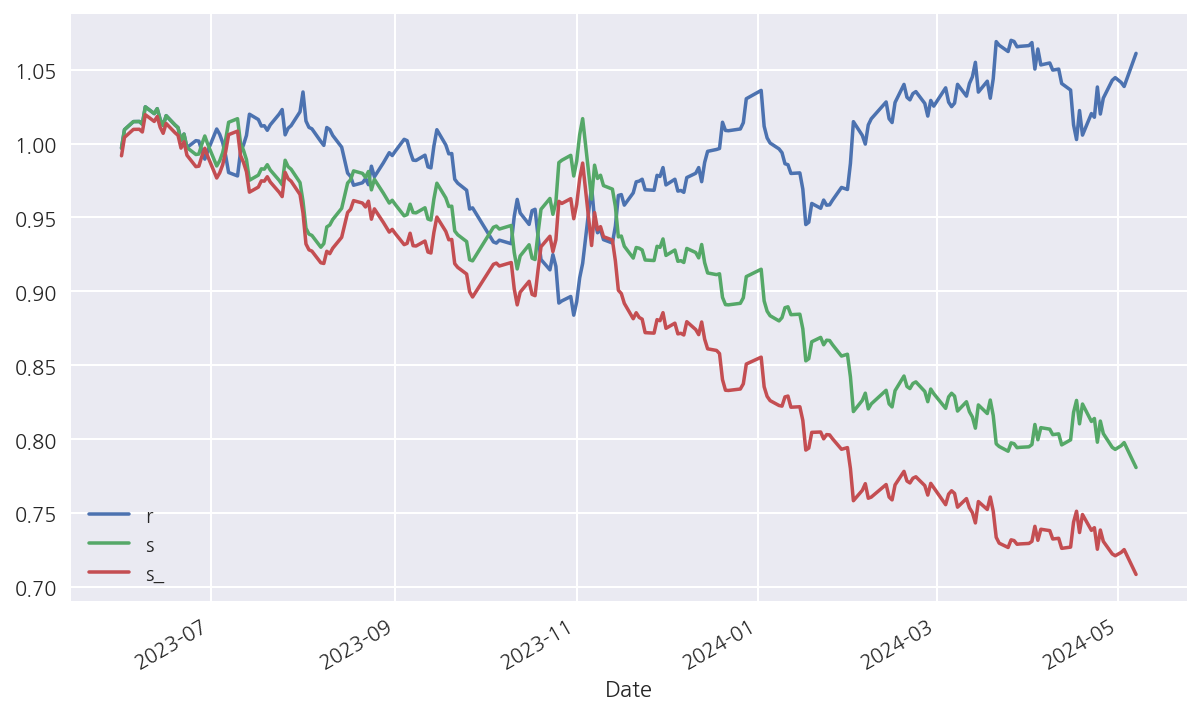

In [346]:
backtest_df[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6));

### 예측 추세

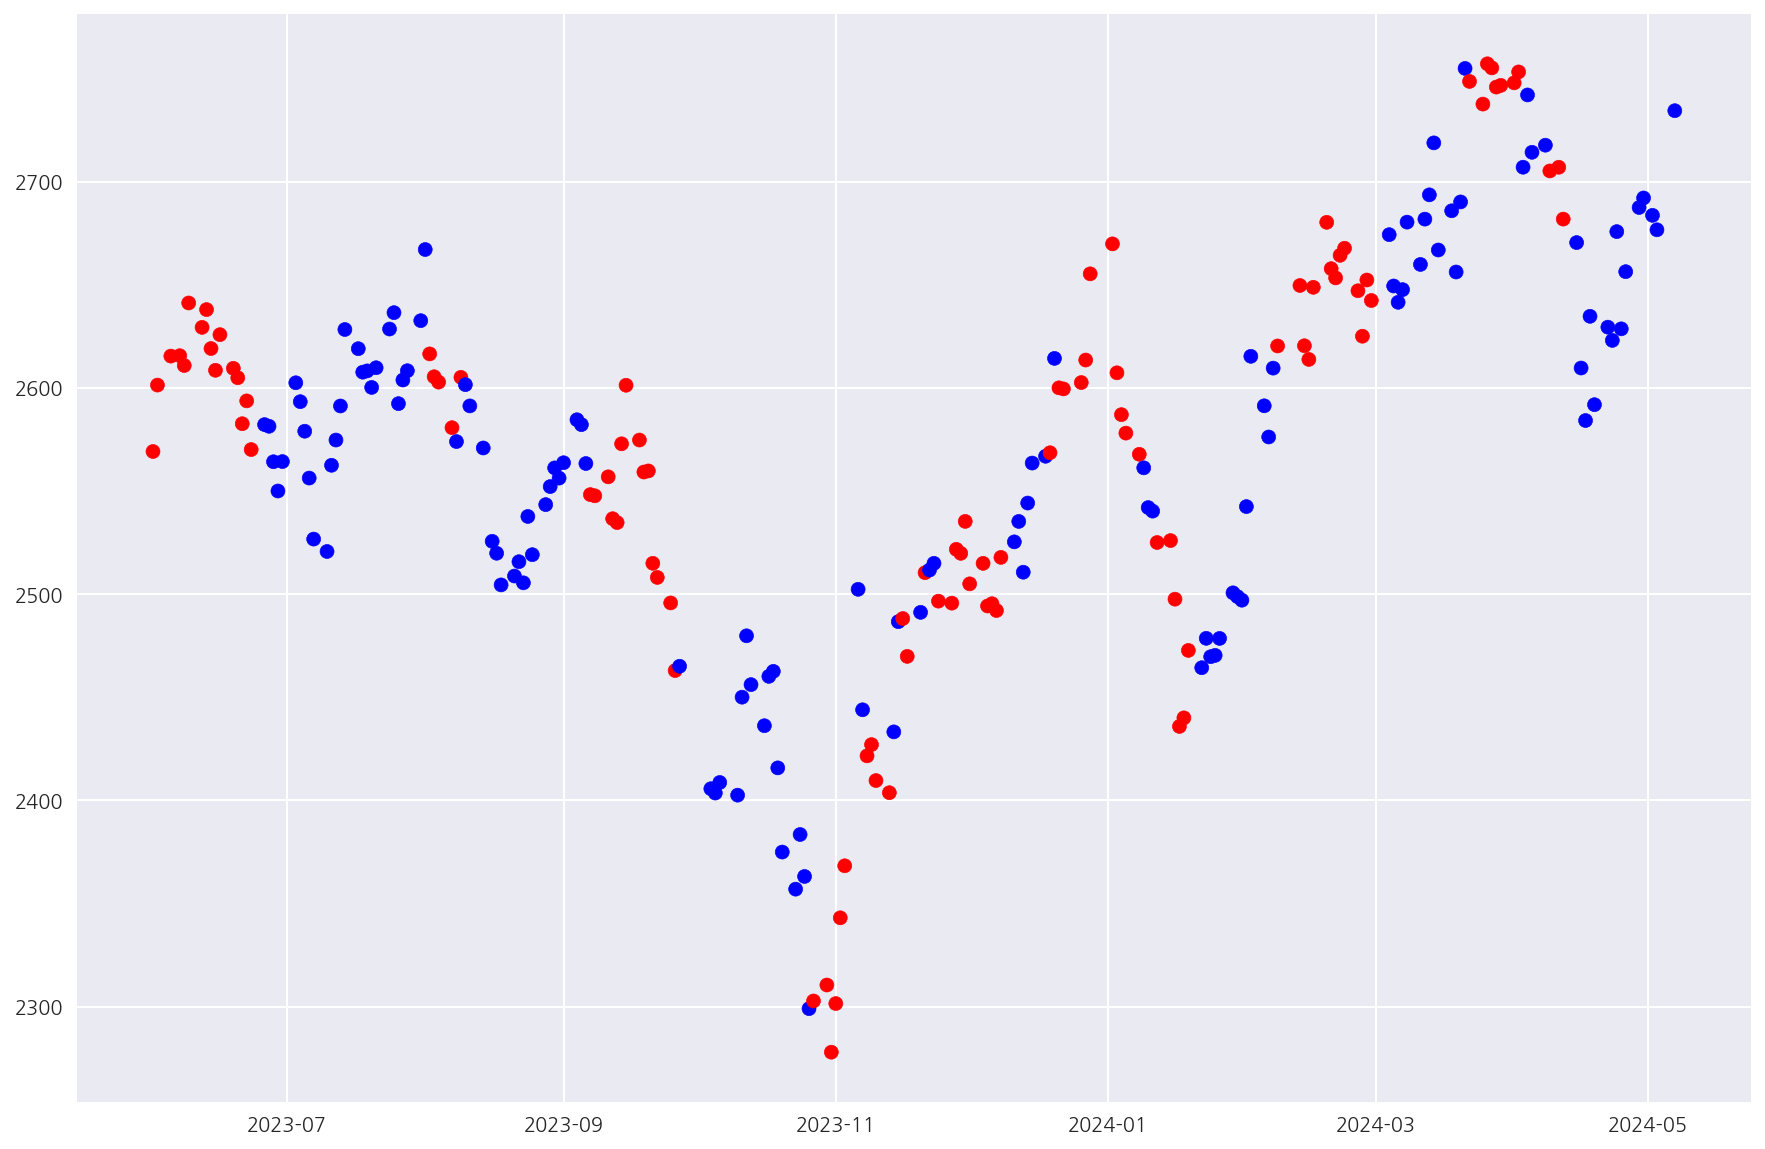

In [347]:
sub_data = df_test['Close'].loc[backtest_df['p'].index]
c_sig = backtest_df['p']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

### 실제 추세

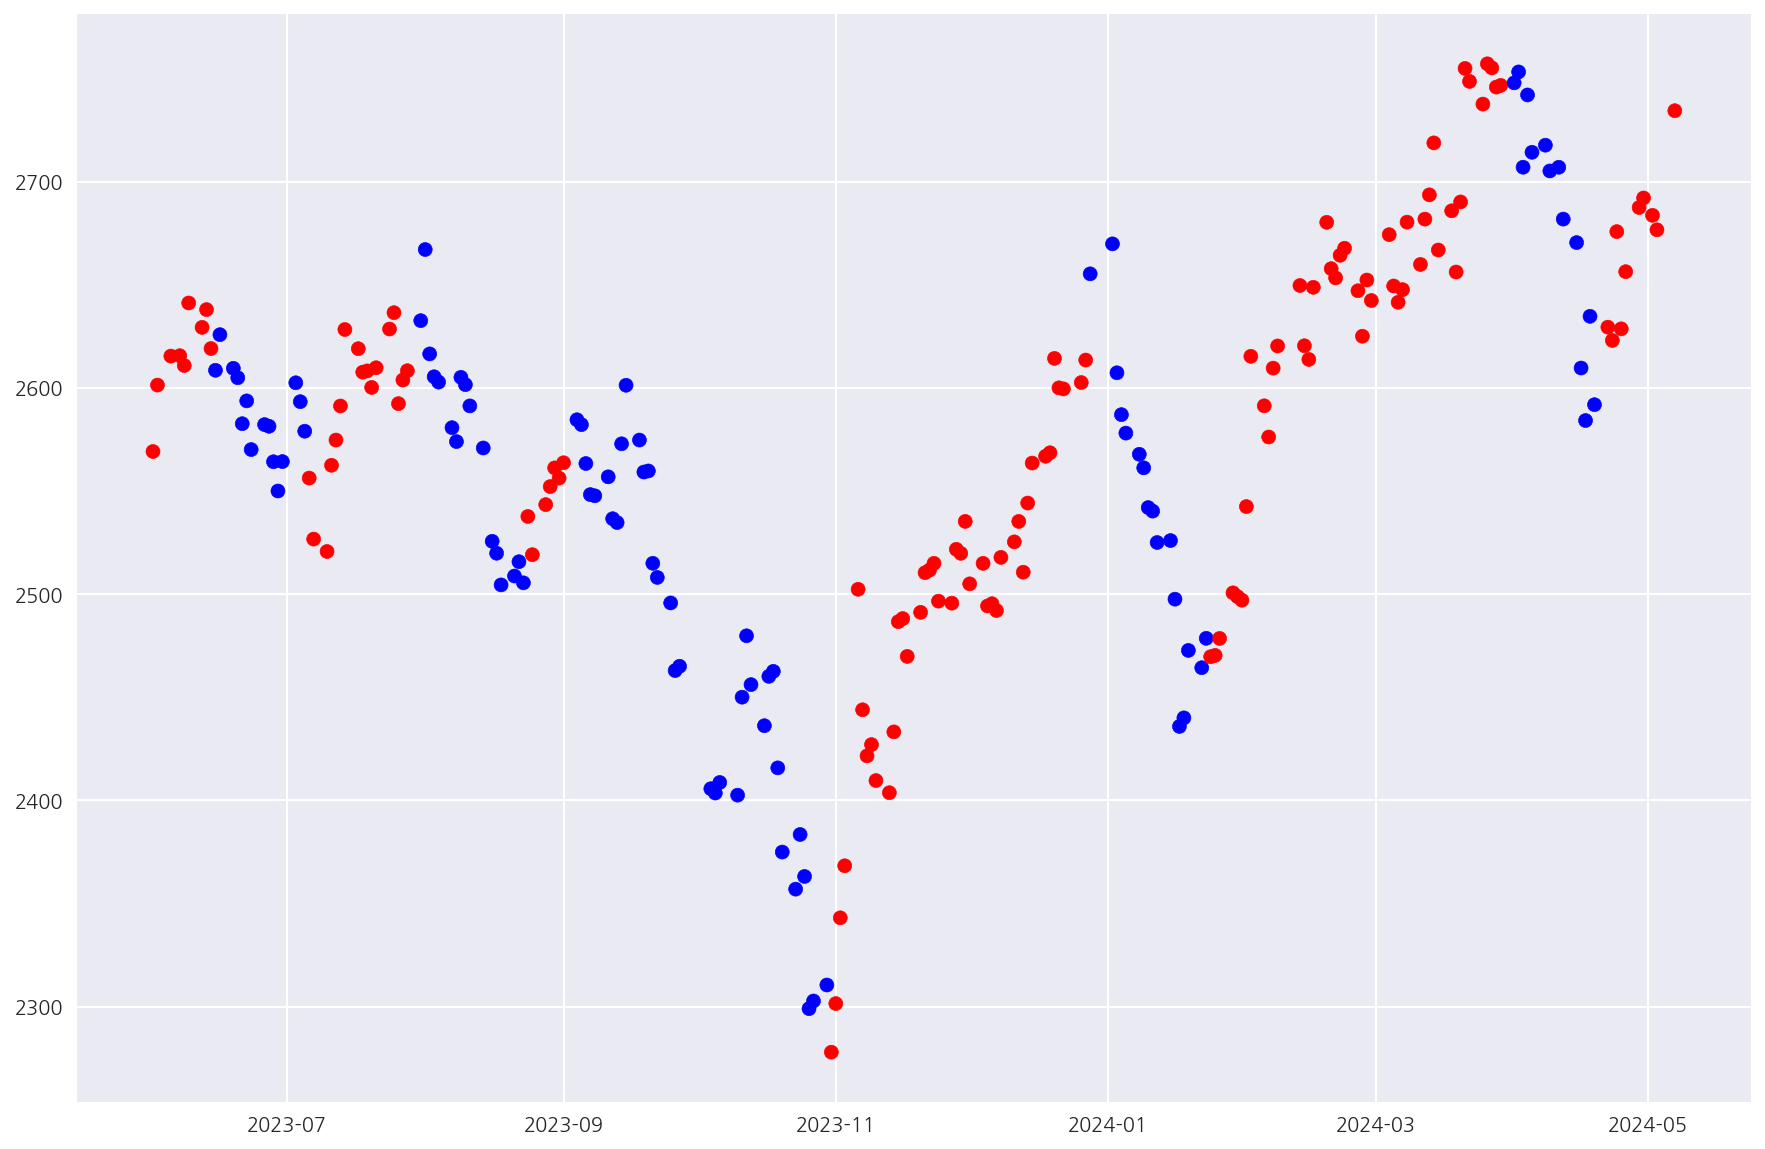

In [348]:
sub_data = df_test['Close'].loc[backtest_df['p'].index]
c_sig = df_test['target'].loc[backtest_df['p'].index]
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

### Advanced B CV

In [349]:
# 테스트 블록 크기, 훈련 블록의 배수, 스플릿 수 설정
test_block_size = 250
train_block_factor = 4
n_splits = 9

    
results = []
for i in range(n_splits):
    test_start = i * test_block_size
    test_end = test_start + test_block_size
    
    train_start = max(0, test_start - train_block_factor * test_block_size)
    train_end = test_start
    
    X_train_cv, X_test_cv = X_train_val[train_start:train_end], X_train_val[test_start:test_end]
    y_train_cv, y_test_cv = y_train_val[train_start:train_end], y_train_val[test_start:test_end]
    if len(X_train_cv) == 0 or len(X_test_cv) != test_block_size:
        continue
        
        
    set_seeds()
    model = create_deep_rnn_model(layer='LSTM', optimizer='adam', features=X_train_val.shape[2])
    model.fit(X_train_cv, y_train_cv, epochs=10, batch_size=16, verbose=1)#, class_weight=cw(y_train_cv)) #, callbacks=[early_stopping_cb])
    
    # 모델 평가
    loss = model.evaluate(X_test_cv, y_test_cv, verbose=1)
    results.append(loss[-2:])
    
    print(f'Block {i} Test Accuracy : {loss[-2:]}')

Epoch 1/10
16/16 [==============================] - 4s 10ms/step - loss: 0.7838 - binary_accuracy: 0.5200 - auc_76: 0.5501
Epoch 2/10
16/16 [==============================] - 0s 10ms/step - loss: 0.6332 - binary_accuracy: 0.6120 - auc_76: 0.7090
Epoch 3/10
16/16 [==============================] - 0s 10ms/step - loss: 0.5816 - binary_accuracy: 0.6960 - auc_76: 0.7790
Epoch 4/10
16/16 [==============================] - 0s 9ms/step - loss: 0.5665 - binary_accuracy: 0.6920 - auc_76: 0.7770
Epoch 5/10
16/16 [==============================] - 0s 10ms/step - loss: 0.5564 - binary_accuracy: 0.7400 - auc_76: 0.7733
Epoch 6/10
16/16 [==============================] - 0s 10ms/step - loss: 0.5344 - binary_accuracy: 0.7520 - auc_76: 0.8261
Epoch 7/10
16/16 [==============================] - 0s 10ms/step - loss: 0.4809 - binary_accuracy: 0.7880 - auc_76: 0.8897
Epoch 8/10
16/16 [==============================] - 0s 10ms/step - loss: 0.4704 - binary_accuracy: 0.8200 - auc_76: 0.9021
Epoch 9/10
16/16 

In [350]:
test_start, test_end 

(2000, 2250)

In [351]:
train_start, train_end

(1000, 2000)

In [352]:
len(X_train_cv), len(X_test_cv)

(1000, 232)

In [353]:
results

[[0.5960000157356262, 0.6522839665412903],
 [0.5839999914169312, 0.5848613381385803],
 [0.656000018119812, 0.6324064135551453],
 [0.5360000133514404, 0.5191543698310852],
 [0.7519999742507935, 0.7510999441146851],
 [0.6159999966621399, 0.5975660085678101],
 [0.46399998664855957, 0.5396770238876343]]

In [354]:
val_mu = np.mean(results, axis=0)[0]
val_mu

0.6005714280264718

In [355]:
val_std = np.std(results, axis=0, ddof=1)[0]
val_std

0.09069887031298025

### 홀드아웃 샘플(Test Set)에 대한 예측 성능 평가 방식은 질문으로

In [356]:
X_blocked = X_train_val[-test_block_size* train_block_factor:]
y_blocked = y_train_val[-test_block_size* train_block_factor:]

In [357]:
X_blocked.shape, y_blocked.shape

((1000, 20, 29), (1000,))

In [358]:
set_seeds()
model = create_deep_rnn_model(layer='LSTM', optimizer='adam', features=X_train_val.shape[2])

model.fit(X_blocked, y_blocked, epochs=10, batch_size=16, verbose=1)#, class_weight=cw(y_train_val))

Epoch 1/10
63/63 [==============================] - 4s 9ms/step - loss: 0.7409 - binary_accuracy: 0.5570 - auc_83: 0.5801
Epoch 2/10
63/63 [==============================] - 1s 9ms/step - loss: 0.6281 - binary_accuracy: 0.6250 - auc_83: 0.6869
Epoch 3/10
63/63 [==============================] - 1s 10ms/step - loss: 0.5678 - binary_accuracy: 0.6960 - auc_83: 0.7669
Epoch 4/10
63/63 [==============================] - 1s 9ms/step - loss: 0.5628 - binary_accuracy: 0.7130 - auc_83: 0.7728
Epoch 5/10
63/63 [==============================] - 1s 9ms/step - loss: 0.5246 - binary_accuracy: 0.7480 - auc_83: 0.8138
Epoch 6/10
63/63 [==============================] - 1s 9ms/step - loss: 0.4921 - binary_accuracy: 0.7730 - auc_83: 0.8454
Epoch 7/10
63/63 [==============================] - 1s 9ms/step - loss: 0.4626 - binary_accuracy: 0.7800 - auc_83: 0.8604
Epoch 8/10
63/63 [==============================] - 1s 9ms/step - loss: 0.4223 - binary_accuracy: 0.8250 - auc_83: 0.8957
Epoch 9/10
63/63 [=====

In [359]:
evl = model.evaluate(X_test, y_test, verbose=1)
evl

8/8 [==============================] - 1s 4ms/step - loss: 1.2836 - binary_accuracy: 0.5044 - auc_83: 0.5005


[1.2836463451385498, 0.5043859481811523, 0.5004698038101196]

In [360]:
(evl[1] - val_mu) / val_std

-1.0604925895262665

In [361]:
len(y_test)

228

In [362]:
test = df_test.iloc[-len(y_test):]
test['target'] = test['target'].apply(lambda x: 1 if x > 0 else 0)
backtest_df = pd.DataFrame(index=test.index)
backtest_df['p'] = model.predict(X_test)
backtest_df['p'] = (backtest_df['p'] > 0.5).astype(int)

In [363]:
# 예측값 비율
backtest_df['p'].value_counts()

1    146
0     82
Name: p, dtype: int64

In [364]:
# 실제 타겟값의 비율
test['target'].value_counts()

1    129
0     99
Name: target, dtype: int64

              precision    recall  f1-score   support

           0       0.39      0.32      0.35        99
           1       0.54      0.61      0.57       129

    accuracy                           0.49       228
   macro avg       0.47      0.47      0.46       228
weighted avg       0.48      0.49      0.48       228



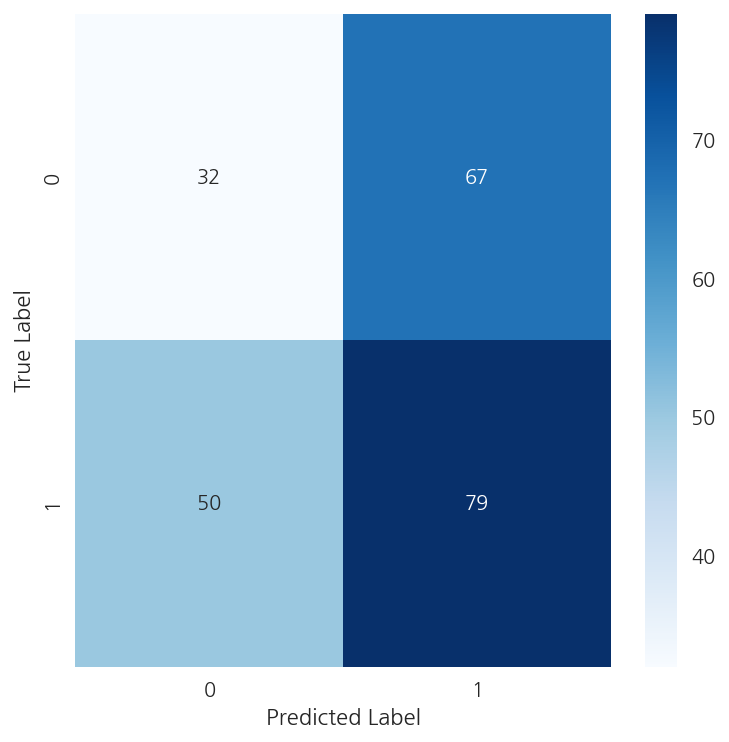

In [365]:
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. 분류 보고서 확인
print(classification_report(test['target'], backtest_df['p']))

# 2. 히트맵 시각화
plt.figure(figsize=(6, 6))
cm2 = confusion_matrix(test['target'], backtest_df['p'])
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 표본 외 경제적 성능 평가

In [366]:
# 매매 포지션 진입, 변경, 청산이 발생한 시점 횟수
sum(backtest_df['p'].diff() != 0) + 1

22

In [367]:
# 포지션 변경에 따른 증권사 수수료 / 거래세
pc = (0.00015 * 2  + 0.0018)

# 슬리피지 적용
sp = 0.001

In [368]:
backtest_df['p'] = np.where(backtest_df['p'] == 0, -1, 1)
backtest_df['r'] = df_test.loc[test.index]['r']
backtest_df['s'] = backtest_df['p'] * backtest_df['r']
backtest_df['s_'] = np.where(backtest_df['p'].diff() != 0,
                      backtest_df['s'] - pc - sp, backtest_df['s'])
backtest_df['s_'].iloc[0] -= pc
backtest_df['s_'].iloc[-1] -= pc
backtest_df

p           r           s          s_
Date                                             
2023-06-01  1 -3.0896e-03 -3.0896e-03 -8.2896e-03
2023-06-02  1  1.2451e-02  1.2451e-02  1.2451e-02
2023-06-05  1  5.3865e-03  5.3865e-03  5.3865e-03
2023-06-07  1  7.2644e-05  7.2644e-05  7.2644e-05
2023-06-08  1 -1.8177e-03 -1.8177e-03 -1.8177e-03
...        ..         ...         ...         ...
2024-04-29  1  1.1644e-02  1.1644e-02  8.5436e-03
2024-04-30  1  1.7176e-03  1.7176e-03  1.7176e-03
2024-05-02  1 -3.1289e-03 -3.1289e-03 -3.1289e-03
2024-05-03  1 -2.6193e-03 -2.6193e-03 -2.6193e-03
2024-05-07  1  2.1339e-02  2.1339e-02  1.9239e-02

[228 rows x 4 columns]

In [369]:
backtest_df[['r', 's', 's_']].sum().apply(np.exp)

r     1.0610
s     0.8405
s_    0.7843
dtype: float64

In [370]:
backtest_df[['r', 's', 's_']].sum().apply(np.exp) - 1

r     0.0610
s    -0.1595
s_   -0.2157
dtype: float64

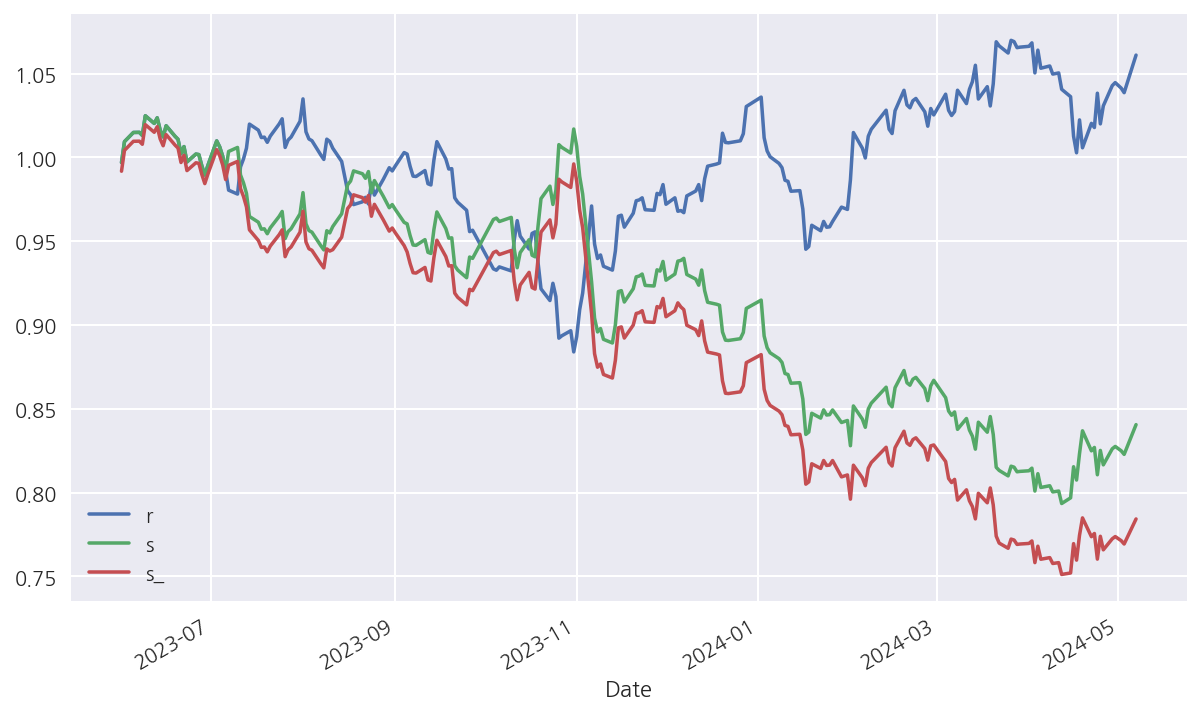

In [371]:
backtest_df[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6));

### 예측 추세

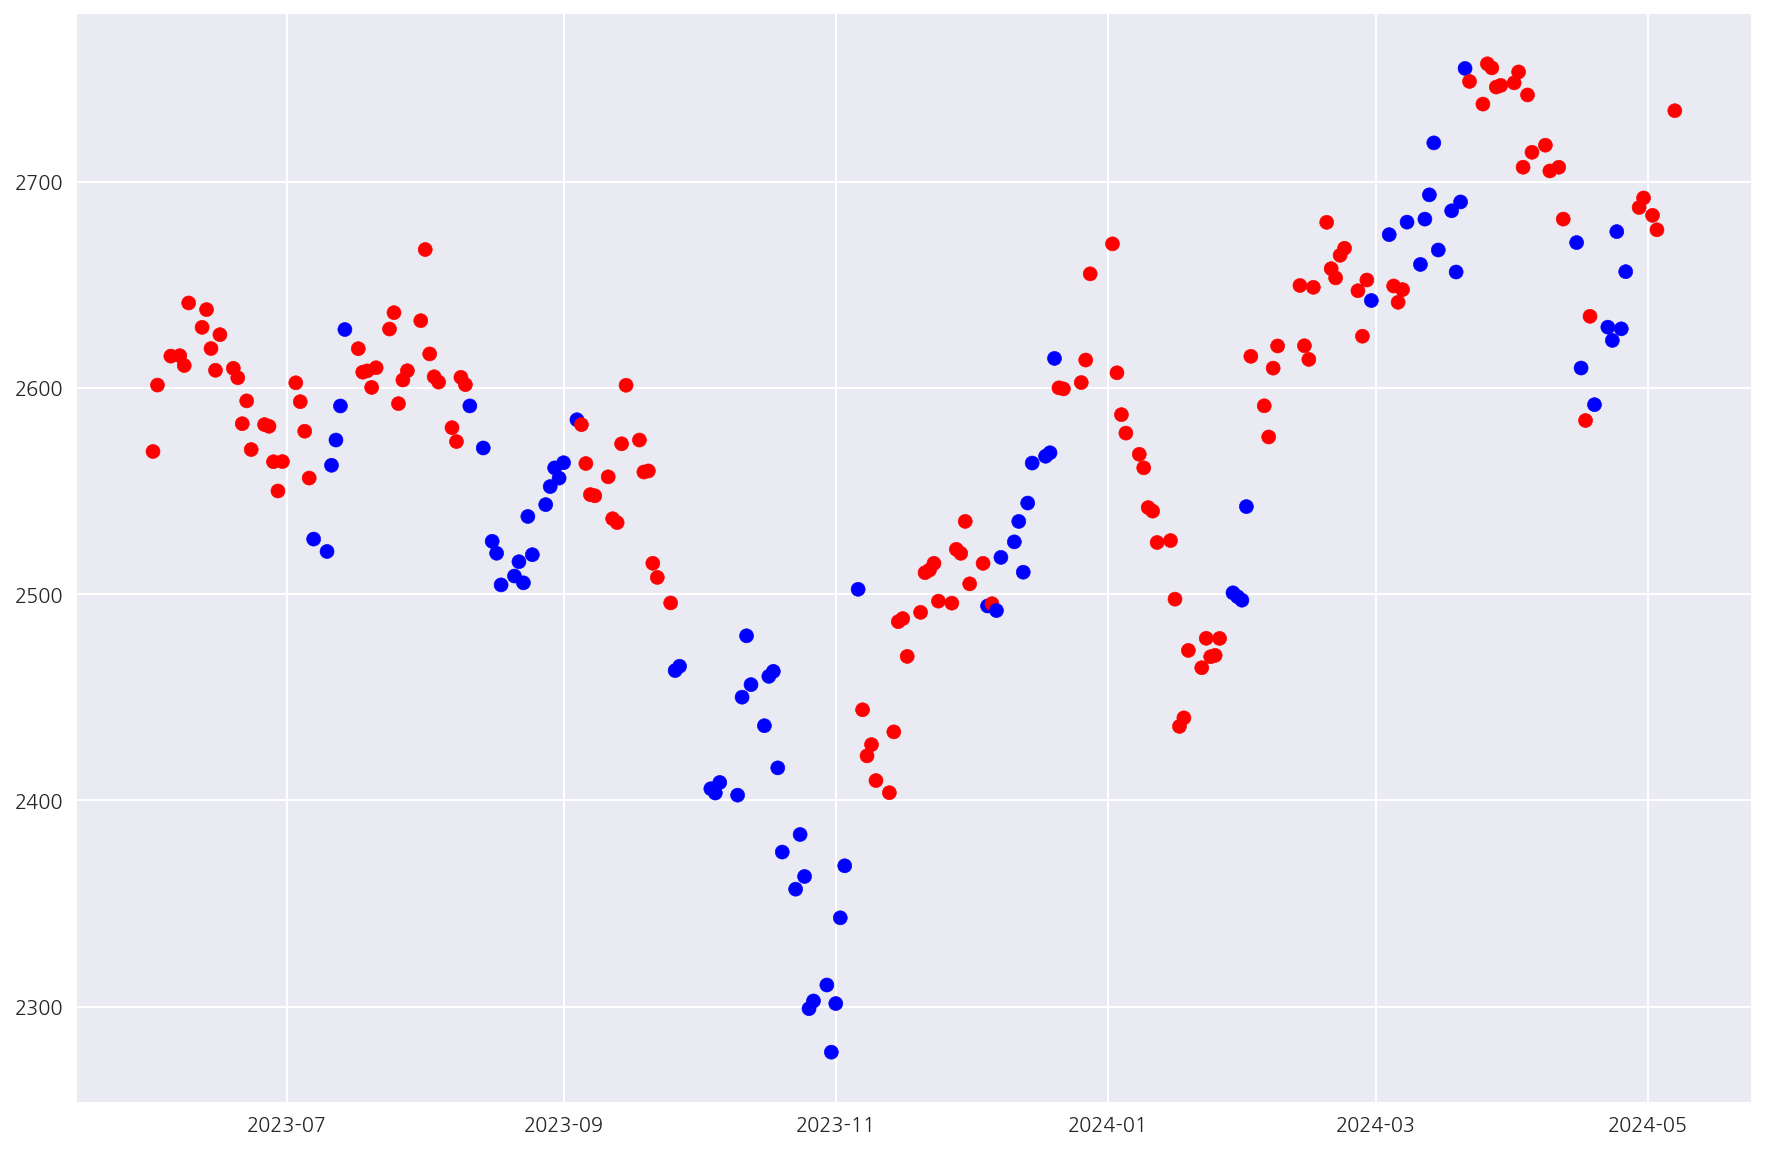

In [372]:
sub_data = df_test['Close'].loc[backtest_df['p'].index]
c_sig = backtest_df['p']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

### 실제 추세

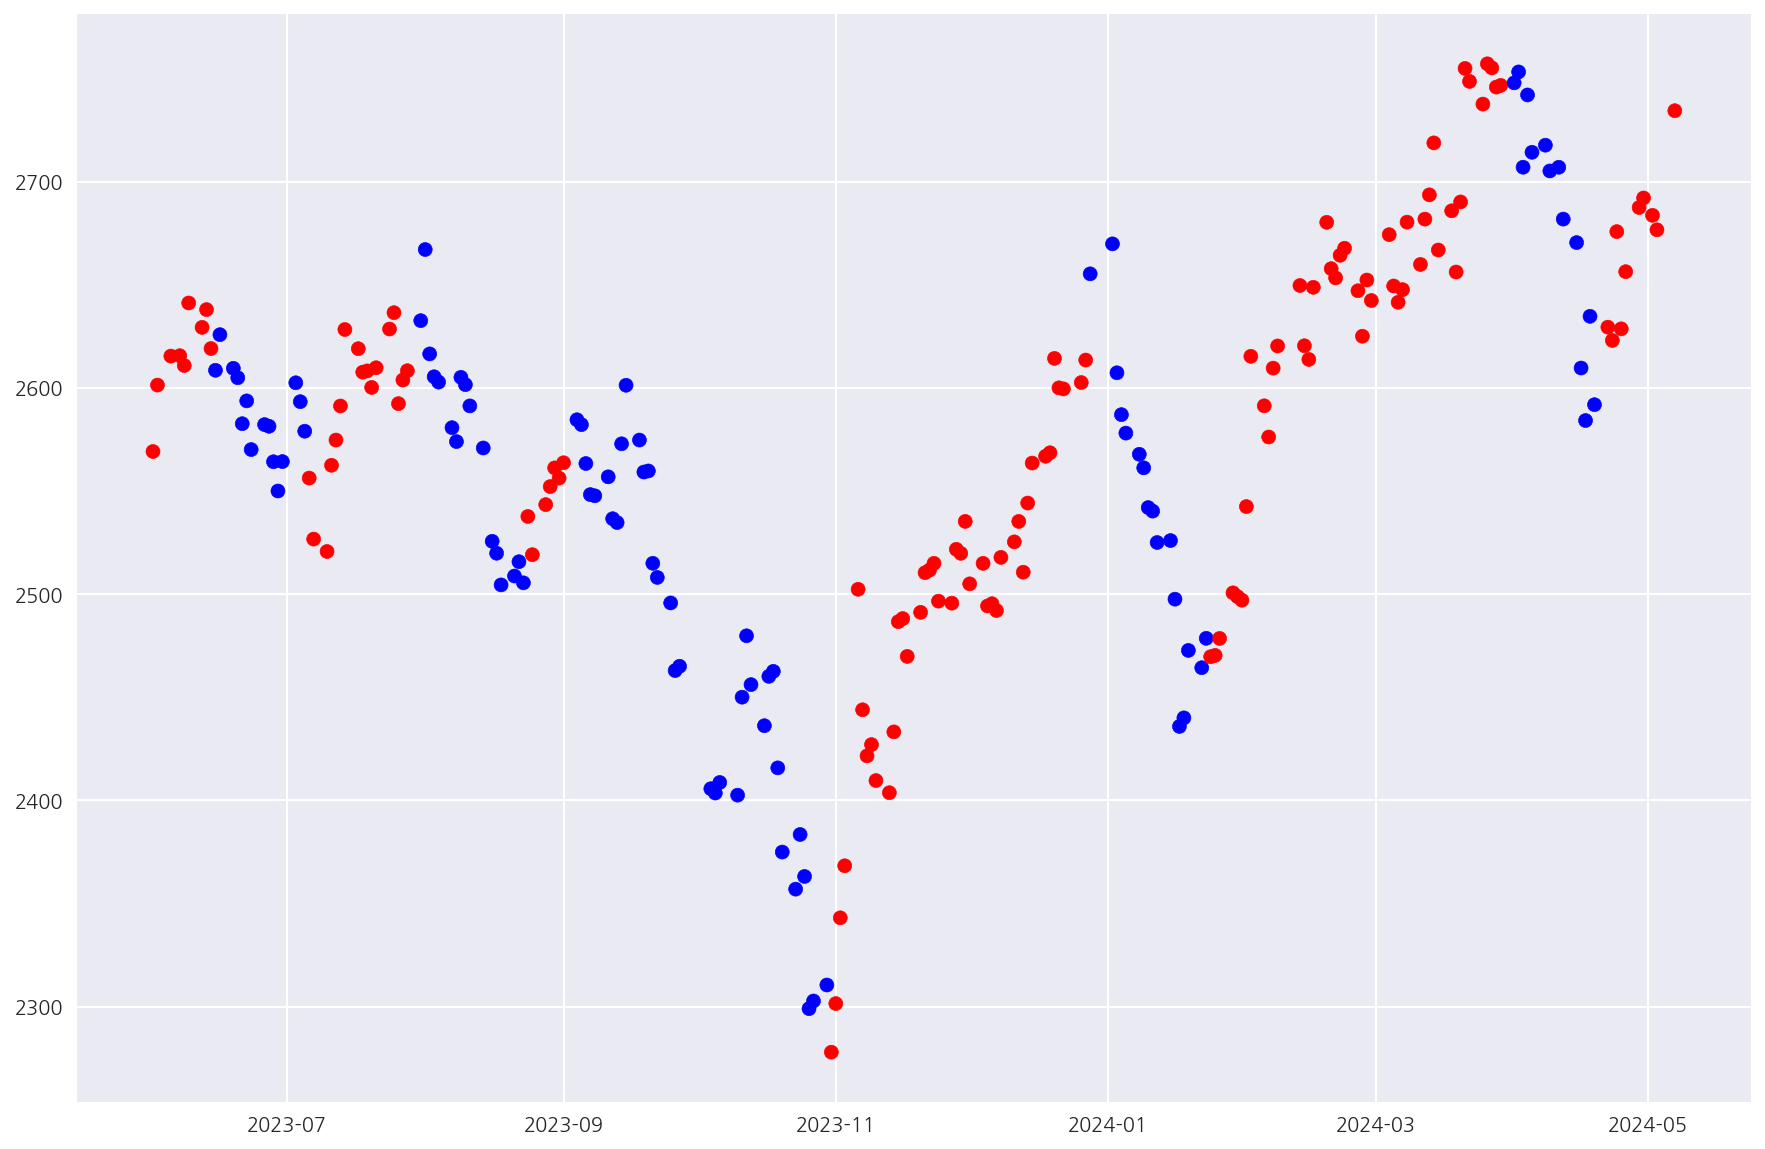

In [373]:
sub_data = df_test['Close'].loc[backtest_df['p'].index]
c_sig = df_test['target'].loc[backtest_df['p'].index]
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])